Experimentation on the CIFAR simmulated annotators
* batch = 128
* delta convergence = 1e-2
* Optimizer = ADAM

* Our proposed: Pre-train base model with hard-MV (5 epochs?) as Rodrigues: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 1e-2 #tolerance for relative variation of parameters

### Load Data and preprocess

In [3]:
folder = "."
X_train = np.loadtxt(folder+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(folder+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth

print("Input shape:",X_train.shape)

Input shape: (2457, 2)


In [4]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2457, 2)

### Load annotations / Generate

In [5]:
scenario = 2
path = "."

In [12]:
from code.generate_data import SinteticData

GenerateData = SinteticData()

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario == 6:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_normal.csv',file_groups =path+'/synthetic/simple/groups_datasim_normal.csv')

elif scenario == 2 or scenario == 7: #bad MV
    #GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')
    GenerateData.set_probas(asfile=False,file_matrix=aux1,file_groups =aux2)

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario == 7:
    Tmax = 2000
    T_data = 20 
elif scenario == 5:
    Tmax = 5000
    T_data = 25
elif scenario == 6:
    Tmax = 10000
    T_data = 40
    
#GenerateData.set_probas(asfile=False,file_matrix=real_conf_matrix,file_groups =aux)

print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

print("Accuracy of MV on train: ",np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.5641025641025641
Shape (data,annotators):  (2457, 100)
Classes:  3


In [34]:
GenerateData.prob_groups

array([0.2 , 0.45, 0.35])

In [11]:
aux2 = [0.15,0.4,0.45]
aux1 = GenerateData.conf_matrix.copy()

#### Delta Convergence criteria

In [8]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model

In [16]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],8,1,BN=False,drop=0.2)
#model_UB = clone_model(raykarMC.base_model)

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])

In [9]:
from code.representation import *
from code.utils import *

### Infer Labels (without predictive model)

In [41]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')
#label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'all')

mv_onehot = label_I.mv_labels('onehot')
mv_probas = label_I.mv_labels('probas')

ds_labels,ds_conf_M = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -16982.106852852135
2 	 -16055.119551551155 	0.5934	0.194807	0.054586
3 	 -15815.252605487487 	0.1723	0.139680	0.014940
4 	 -15628.060040231181 	0.0723	0.132828	0.011836
5 	 -15504.63230494781 	0.0552	0.104531	0.007898
6 	 -15447.361469508925 	0.0606	0.079513	0.003694
7 	 -15421.794734450386 	0.0477	0.062201	0.001655
8 	 -15408.52250273299 	0.0346	0.046602	0.000861
9 	 -15401.148276001979 	0.0251	0.033304	0.000479
10 	 -15397.040948889846 	0.0182	0.022533	0.000267
11 	 -15394.684810764631 	0.0132	0.014821	0.000153
12 	 -15393.190018001947 	0.0097	0.011001	0.000097
13 	 -15392.024738231177 	0.0073	0.007729	0.000076
Class marginals
[0.37 0.34 0.29]


In [42]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.5734635734635735
ACC D&S on train: 0.9226699226699226


In [43]:
model_mvsoft = MLP_Keras(Xstd_train.shape[1:],mv_probas.shape[1],8,1,BN=False,drop=0.2)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over soft-MV")

Trained model over soft-MV


In [44]:
model_mvhard = MLP_Keras(Xstd_train.shape[1:],mv_onehot.shape[1],8,1,BN=False,drop=0.2)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over hard-MV")

Trained model over hard-MV


In [45]:
model_ds = MLP_Keras(Xstd_train.shape[1:],ds_labels.shape[1],8,1,BN=False,drop=0.2)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over D&S")

Trained model over D&S


In [13]:
from code.baseline import RaykarMC

#get representation needed for Raykar
#y_obs_categorical = label_I.y_obs_categ
y_obs_categorical = set_representation(y_obs,'onehot') 

### Raykar Model (joint predict model)

In [11]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                           ,relative=True,val=False)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 2.05 sec)	logL: -19204.592	
Iter 2/50 
M step: done,  E step: done //  (in 0.24 sec)	logL: -17826.641	Tol1: 0.07175	Tol2: 0.26210	
Iter 3/50 
M step: done,  E step: done //  (in 0.17 sec)	logL: -17345.211	Tol1: 0.02701	Tol2: 0.12063	
Iter 4/50 
M step: done,  E step: done //  (in 0.18 sec)	logL: -17088.066	Tol1: 0.01483	Tol2: 0.06843	
Iter 5/50 
M step: done,  E step: done //  (in 0.15 sec)	logL: -16907.961	Tol1: 0.01054	Tol2: 0.03040	
Iter 6/50 
M step: done,  E step: done //  (in 0.19 sec)	logL: -16751.262	Tol1: 0.00927	Tol2: 0.01243	
Iter 7/50 
M step: done,  E step: done //  (in 0.17 sec)	logL: -16604.973	Tol1: 0.00873	Tol2: 0.00521	
Finished training!


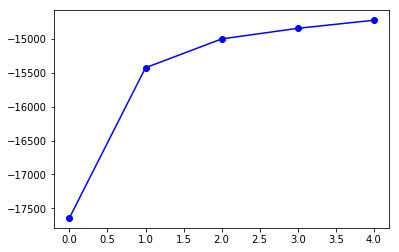

In [37]:
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.show()

In [14]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
#raykarMC.define_model("keras_shallow") 
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

logL_hists,i = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.71 sec)	logL: -16573.861	
Iter 2/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -15652.877	Tol1: 0.05557	Tol2: 0.29819	
Iter 3/50 
M step: done,  E step: done //  (in 0.08 sec)	logL: -15252.674	Tol1: 0.02557	Tol2: 0.08838	
Iter 4/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -14927.959	Tol1: 0.02129	Tol2: 0.08851	
Iter 5/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -14719.458	Tol1: 0.01397	Tol2: 0.06398	
Iter 6/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -14583.697	Tol1: 0.00922	Tol2: 0.03886	
Iter 7/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -14481.594	Tol1: 0.00700	Tol2: 0.02102	
Iter 8/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -14399.148	Tol1: 0.00569	Tol2: 0.01113	
Iter 9/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -14328.139	Tol1: 0.0049

M step: done,  E step: done //  (in 0.06 sec)	logL: -15422.422	Tol1: 0.01935	Tol2: 0.08873	
Iter 5/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -15236.004	Tol1: 0.01209	Tol2: 0.04597	
Iter 6/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -15089.523	Tol1: 0.00961	Tol2: 0.02274	
Iter 7/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -14965.918	Tol1: 0.00819	Tol2: 0.01226	
Iter 8/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -14858.142	Tol1: 0.00720	Tol2: 0.00732	
Finished training!
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.83 sec)	logL: -16769.541	
Iter 2/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -15871.871	Tol1: 0.05353	Tol2: 0.27649	
Iter 3/50 
M step: done,  E step: done //  (in 0.07 sec)	logL: -15511.039	Tol1: 0.02273	Tol2: 0.08932	
Iter 4/50 
M step: done,  E step: done //  (in 0.07 sec)	logL: -15214.411	Tol1: 0.01912	Tol2: 0.09046	
Iter 5/50 
M st

M step: done,  E step: done //  (in 0.06 sec)	logL: -15029.280	Tol1: 0.00665	Tol2: 0.01951	
Iter 9/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -14937.301	Tol1: 0.00612	Tol2: 0.01343	
Iter 10/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -14855.955	Tol1: 0.00545	Tol2: 0.01041	
Iter 11/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -14778.007	Tol1: 0.00525	Tol2: 0.00791	
Finished training!
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 1.23 sec)	logL: -17215.588	
Iter 2/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -16425.930	Tol1: 0.04587	Tol2: 0.25717	
Iter 3/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -16202.916	Tol1: 0.01358	Tol2: 0.04155	
Iter 4/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -16007.706	Tol1: 0.01205	Tol2: 0.02979	
Iter 5/50 
M step: done,  E step: done //  (in 0.08 sec)	logL: -15804.074	Tol1: 0.01272	Tol2: 0.04027	
Iter 6/50 
M 

### Our Proposed

In [15]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs_categorical,"repeat")
#r_obs = set_representation(y_obs,"repeat")
print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[2 0 5]
 [1 2 4]
 [6 0 5]
 ...
 [5 0 5]
 [7 0 1]
 [8 0 0]]
shape: (2457, 3)


In [16]:
%%time

#pre analysis
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

Bayesian gaussian mixture say is 4 clusters 


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


DBSCAN say is 1 clusters
Affinity Propagation say is 2 clusters
Annotators PCA of annotations shape:  (100, 4)
Normalized entropy (0-1) of repeats annotations: 0.5697045760067673
CPU times: user 5.26 s, sys: 845 ms, total: 6.11 s
Wall time: 1.35 s


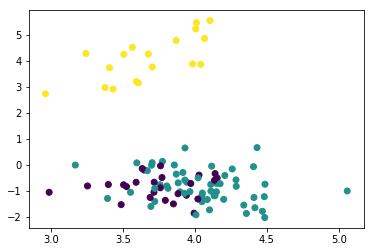

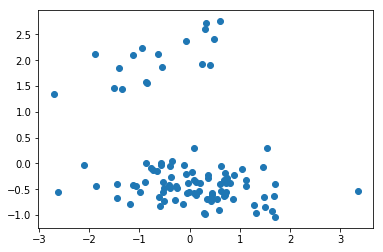

In [119]:
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c=groups_annot.argmax(axis=1))
plt.show()

std = StandardScaler()
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

In [17]:
M_seted = 3

In [18]:
gMixture1 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=5,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture1.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture1.lambda_random = False #lambda=1     
logL_hists,i_r = gMixture1.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.000379 mins
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 1.28 sec)	logL: -22081.131	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21550.083	Tol1: 0.02405	Tol2: 0.20154	Tol3: 0.04897	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21238.600	Tol1: 0.01445	Tol2: 0.15739	Tol3: 0.00505	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20917.890	Tol1: 0.01510	Tol2: 0.14358	Tol3: 0.00074	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20597.797	Tol1: 0.01530	Tol2: 0.13546	Tol3: 0.00076	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20287.444	Tol1: 0.01507	Tol2: 0.13086	Tol3: 0.00095	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19993.677	Tol1: 0.014

M step: done,  E step: done //  (in 0.08 sec)	logL: -19067.019	Tol1: 0.00119	Tol2: 0.01729	Tol3: 0.00011	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 1.58 sec)	logL: -22771.102	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22447.658	Tol1: 0.01420	Tol2: 0.16084	Tol3: 0.01208	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22150.361	Tol1: 0.01324	Tol2: 0.11086	Tol3: 0.00246	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21826.660	Tol1: 0.01461	Tol2: 0.09739	Tol3: 0.00059	
Iter 5/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21482.999	Tol1: 0.01575	Tol2: 0.09651	Tol3: 0.00044	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21138.277	Tol1: 0.01605	Tol2: 0.09863	Tol3: 0.00064	
Iter 7/50
M step: done,  E step: done //  (in 0.1

M step: done,  E step: done //  (in 0.09 sec)	logL: -18564.263	Tol1: 0.00090	Tol2: 0.02098	Tol3: 0.00262	
Iter 28/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -18550.169	Tol1: 0.00076	Tol2: 0.02032	Tol3: 0.00304	
Iter 29/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -18538.044	Tol1: 0.00065	Tol2: 0.01884	Tol3: 0.00333	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 1.54 sec)	logL: -22597.790	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22282.775	Tol1: 0.01394	Tol2: 0.16245	Tol3: 0.02411	
Iter 3/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22041.750	Tol1: 0.01082	Tol2: 0.11327	Tol3: 0.00402	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21781.990	Tol1: 0.01178	Tol2: 0.10491	Tol3: 0.00236	
Iter 5/50
M step: done,  E step: done //  (in 0

M step: done,  E step: done //  (in 0.09 sec)	logL: -18442.070	Tol1: 0.00046	Tol2: 0.02323	Tol3: 0.00233	
Iter 31/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -18433.091	Tol1: 0.00049	Tol2: 0.02345	Tol3: 0.00253	
Iter 32/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -18427.058	Tol1: 0.00033	Tol2: 0.02022	Tol3: 0.00251	
Iter 33/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -18421.211	Tol1: 0.00032	Tol2: 0.01849	Tol3: 0.00208	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 1.69 sec)	logL: -22251.703	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21822.805	Tol1: 0.01927	Tol2: 0.18695	Tol3: 0.02393	
Iter 3/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21470.331	Tol1: 0.01615	Tol2: 0.13168	Tol3: 0.00453	
Iter 4/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.09 sec)	logL: -18681.494	Tol1: 0.00104	Tol2: 0.02061	Tol3: 0.00073	
Iter 29/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -18673.920	Tol1: 0.00041	Tol2: 0.01820	Tol3: 0.00051	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 1.82 sec)	logL: -21897.887	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21311.886	Tol1: 0.02676	Tol2: 0.21074	Tol3: 0.02725	
Iter 3/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20893.658	Tol1: 0.01962	Tol2: 0.15263	Tol3: 0.00392	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20529.697	Tol1: 0.01742	Tol2: 0.13184	Tol3: 0.00123	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20212.725	Tol1: 0.01544	Tol2: 0.11550	Tol3: 0.00118	
Iter 6/50
M step: done,  E step: done //  (in 0.

M step: done,  E step: done //  (in 0.11 sec)	logL: -19879.343	Tol1: 0.00996	Tol2: 0.11680	Tol3: 0.00377	
Iter 8/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19709.048	Tol1: 0.00857	Tol2: 0.10804	Tol3: 0.00432	
Iter 9/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19558.738	Tol1: 0.00763	Tol2: 0.09774	Tol3: 0.00392	
Iter 10/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19424.901	Tol1: 0.00684	Tol2: 0.08780	Tol3: 0.00461	
Iter 11/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19311.686	Tol1: 0.00583	Tol2: 0.07774	Tol3: 0.00536	
Iter 12/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19209.785	Tol1: 0.00528	Tol2: 0.06798	Tol3: 0.00502	
Iter 13/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19112.056	Tol1: 0.00509	Tol2: 0.06489	Tol3: 0.00561	
Iter 14/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19025.737	Tol1: 0.00452	Tol2: 0.06531	Tol3: 0.00572	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -18947.294	Tol

M step: done,  E step: done //  (in 0.15 sec)	logL: -18829.831	Tol1: 0.00129	Tol2: 0.03750	Tol3: 0.00429	
Iter 20/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -18807.315	Tol1: 0.00120	Tol2: 0.03445	Tol3: 0.00396	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -18788.539	Tol1: 0.00100	Tol2: 0.03351	Tol3: 0.00390	
Iter 22/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -18765.244	Tol1: 0.00124	Tol2: 0.03326	Tol3: 0.00433	
Iter 23/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -18740.780	Tol1: 0.00130	Tol2: 0.03067	Tol3: 0.00389	
Iter 24/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -18723.587	Tol1: 0.00092	Tol2: 0.03052	Tol3: 0.00416	
Iter 25/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -18703.881	Tol1: 0.00105	Tol2: 0.02882	Tol3: 0.00443	
Iter 26/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -18691.051	Tol1: 0.00069	Tol2: 0.02560	Tol3: 0.00371	
Iter 27/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -18675.280	T

M step: done,  E step: done //  (in 0.11 sec)	logL: -18971.254	Tol1: 0.00138	Tol2: 0.04336	Tol3: 0.00241	
Iter 25/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -18947.592	Tol1: 0.00125	Tol2: 0.04049	Tol3: 0.00227	
Iter 26/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -18923.288	Tol1: 0.00128	Tol2: 0.04051	Tol3: 0.00260	
Iter 27/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -18897.370	Tol1: 0.00137	Tol2: 0.03672	Tol3: 0.00239	
Iter 28/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -18878.067	Tol1: 0.00102	Tol2: 0.03268	Tol3: 0.00209	
Iter 29/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -18860.534	Tol1: 0.00093	Tol2: 0.02866	Tol3: 0.00178	
Iter 30/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18842.554	Tol1: 0.00095	Tol2: 0.02920	Tol3: 0.00237	
Iter 31/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -18824.602	Tol1: 0.00095	Tol2: 0.02801	Tol3: 0.00245	
Iter 32/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -18809.336	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -18762.953	Tol1: 0.00064	Tol2: 0.01908	Tol3: 0.00080	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 2.88 sec)	logL: -22011.487	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21480.922	Tol1: 0.02410	Tol2: 0.18273	Tol3: 0.03876	
Iter 3/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21086.481	Tol1: 0.01836	Tol2: 0.14208	Tol3: 0.00548	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20718.924	Tol1: 0.01743	Tol2: 0.13075	Tol3: 0.00117	
Iter 5/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20378.512	Tol1: 0.01643	Tol2: 0.12249	Tol3: 0.00105	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20071.067	Tol1: 0.01509	Tol2: 0.11690	Tol3: 0.00094	
Iter 7/50
M step: done,  E step: done //  (in 0.2

M step: done,  E step: done //  (in 0.10 sec)	logL: -18521.382	Tol1: 0.00056	Tol2: 0.02472	Tol3: 0.00277	
Iter 43/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18519.457	Tol1: 0.00010	Tol2: 0.02340	Tol3: 0.00222	
Iter 44/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18513.684	Tol1: 0.00031	Tol2: 0.02257	Tol3: 0.00252	
Iter 45/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -18504.288	Tol1: 0.00051	Tol2: 0.02299	Tol3: 0.00255	
Iter 46/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -18496.530	Tol1: 0.00042	Tol2: 0.02210	Tol3: 0.00240	
Iter 47/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -18492.271	Tol1: 0.00023	Tol2: 0.02118	Tol3: 0.00198	
Iter 48/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -18490.115	Tol1: 0.00012	Tol2: 0.02144	Tol3: 0.00213	
Iter 49/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -18489.340	Tol1: 0.00004	Tol2: 0.01964	Tol3: 0.00184	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... 

In [19]:
gMixture2 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=5,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture2.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture2.lambda_random = True #lambda random
logL_hists,i_r = gMixture2.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.000450 mins
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [0.31158257 0.760957   0.5662354 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 3.60 sec)	logL: -22985.546	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22615.348	Tol1: 0.01611	Tol2: 0.17783	Tol3: 0.02570	
Iter 3/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22375.637	Tol1: 0.01060	Tol2: 0.08567	Tol3: 0.01012	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22149.075	Tol1: 0.01013	Tol2: 0.06441	Tol3: 0.00451	
Iter 5/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21921.921	Tol1: 0.01026	Tol2: 0.06153	Tol3: 0.00328	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21689.223	Tol1: 0.01061	Tol2: 0.06537	Tol3: 0.00296	
Iter 7/50
M step: done,  E step: done //  (in 0.11 sec)	logL

M step: done,  E step: done //  (in 0.10 sec)	logL: -18902.816	Tol1: 0.00120	Tol2: 0.01785	Tol3: 0.00034	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [0.5212975  0.85827005 0.7190062 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 3.12 sec)	logL: -22435.113	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21943.588	Tol1: 0.02191	Tol2: 0.19867	Tol3: 0.00854	
Iter 3/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21525.322	Tol1: 0.01906	Tol2: 0.14337	Tol3: 0.00119	
Iter 4/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21128.727	Tol1: 0.01842	Tol2: 0.12364	Tol3: 0.00152	
Iter 5/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20785.587	Tol1: 0.01624	Tol2: 0.11540	Tol3: 0.00283	
Iter 6/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20488.743	Tol1: 0.01428	Tol2: 0.11274	Tol3: 0.00291	
Iter 7/50
M step: done,  

M step: done,  E step: done //  (in 0.11 sec)	logL: -19582.757	Tol1: 0.01208	Tol2: 0.06666	Tol3: 0.00399	
Iter 8/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19389.478	Tol1: 0.00987	Tol2: 0.06327	Tol3: 0.00286	
Iter 9/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19227.330	Tol1: 0.00836	Tol2: 0.05531	Tol3: 0.00265	
Iter 10/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19104.400	Tol1: 0.00639	Tol2: 0.05072	Tol3: 0.00248	
Iter 11/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19002.477	Tol1: 0.00534	Tol2: 0.04131	Tol3: 0.00266	
Iter 12/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -18917.283	Tol1: 0.00448	Tol2: 0.03754	Tol3: 0.00217	
Iter 13/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -18851.428	Tol1: 0.00348	Tol2: 0.03699	Tol3: 0.00212	
Iter 14/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18793.618	Tol1: 0.00307	Tol2: 0.03225	Tol3: 0.00209	
Iter 15/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -18747.255	Tol

M step: done,  E step: done //  (in 0.17 sec)	logL: -18569.291	Tol1: 0.00114	Tol2: 0.03090	Tol3: 0.00107	
Iter 40/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -18550.039	Tol1: 0.00104	Tol2: 0.03044	Tol3: 0.00166	
Iter 41/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -18535.788	Tol1: 0.00077	Tol2: 0.02803	Tol3: 0.00147	
Iter 42/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -18516.909	Tol1: 0.00102	Tol2: 0.02661	Tol3: 0.00216	
Iter 43/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -18500.551	Tol1: 0.00088	Tol2: 0.02330	Tol3: 0.00139	
Iter 44/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -18485.057	Tol1: 0.00084	Tol2: 0.02178	Tol3: 0.00111	
Iter 45/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -18472.532	Tol1: 0.00068	Tol2: 0.01941	Tol3: 0.00116	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [0.61396205 0.9711436  0.4424451 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q esti

M step: done,  E step: done //  (in 0.12 sec)	logL: -19399.660	Tol1: 0.00434	Tol2: 0.06679	Tol3: 0.01713	
Iter 15/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19324.918	Tol1: 0.00385	Tol2: 0.06312	Tol3: 0.01640	
Iter 16/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19260.936	Tol1: 0.00331	Tol2: 0.06192	Tol3: 0.01628	
Iter 17/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19199.025	Tol1: 0.00321	Tol2: 0.05832	Tol3: 0.01515	
Iter 18/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19145.924	Tol1: 0.00277	Tol2: 0.05717	Tol3: 0.01459	
Iter 19/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19093.472	Tol1: 0.00274	Tol2: 0.05604	Tol3: 0.01402	
Iter 20/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19043.960	Tol1: 0.00259	Tol2: 0.05291	Tol3: 0.01266	
Iter 21/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18998.742	Tol1: 0.00237	Tol2: 0.04900	Tol3: 0.01073	
Iter 22/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18960.748	T

M step: done,  E step: done //  (in 0.21 sec)	logL: -19065.006	Tol1: 0.00436	Tol2: 0.04962	Tol3: 0.00314	
Iter 14/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -18994.510	Tol1: 0.00370	Tol2: 0.04886	Tol3: 0.00341	
Iter 15/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -18928.587	Tol1: 0.00347	Tol2: 0.04584	Tol3: 0.00253	
Iter 16/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -18866.711	Tol1: 0.00327	Tol2: 0.04365	Tol3: 0.00235	
Iter 17/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -18812.776	Tol1: 0.00286	Tol2: 0.04113	Tol3: 0.00250	
Iter 18/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -18764.342	Tol1: 0.00257	Tol2: 0.03854	Tol3: 0.00250	
Iter 19/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -18721.939	Tol1: 0.00226	Tol2: 0.03530	Tol3: 0.00240	
Iter 20/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -18682.890	Tol1: 0.00209	Tol2: 0.03276	Tol3: 0.00221	
Iter 21/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -18648.984	T

M step: done,  E step: done //  (in 0.11 sec)	logL: -19089.448	Tol1: 0.00540	Tol2: 0.04579	Tol3: 0.00525	
Iter 19/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18998.632	Tol1: 0.00476	Tol2: 0.04583	Tol3: 0.00487	
Iter 20/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18919.628	Tol1: 0.00416	Tol2: 0.04665	Tol3: 0.00466	
Iter 21/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18851.719	Tol1: 0.00359	Tol2: 0.04711	Tol3: 0.00437	
Iter 22/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18788.513	Tol1: 0.00335	Tol2: 0.04866	Tol3: 0.00394	
Iter 23/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18735.253	Tol1: 0.00283	Tol2: 0.04981	Tol3: 0.00389	
Iter 24/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18690.117	Tol1: 0.00241	Tol2: 0.05040	Tol3: 0.00374	
Iter 25/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18650.814	Tol1: 0.00210	Tol2: 0.04427	Tol3: 0.00268	
Iter 26/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -18620.496	T

M step: done,  E step: done //  (in 0.20 sec)	logL: -19795.666	Tol1: 0.00562	Tol2: 0.03862	Tol3: 0.00559	
Iter 12/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -19701.720	Tol1: 0.00475	Tol2: 0.03187	Tol3: 0.00463	
Iter 13/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -19622.015	Tol1: 0.00405	Tol2: 0.03044	Tol3: 0.00347	
Iter 14/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19549.366	Tol1: 0.00370	Tol2: 0.02907	Tol3: 0.00270	
Iter 15/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -19483.693	Tol1: 0.00336	Tol2: 0.02825	Tol3: 0.00197	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19423.110	Tol1: 0.00311	Tol2: 0.02747	Tol3: 0.00145	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19369.591	Tol1: 0.00276	Tol2: 0.02846	Tol3: 0.00073	
Iter 18/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19315.910	Tol1: 0.00277	Tol2: 0.02758	Tol3: 0.00073	
Iter 19/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19273.479	T

M step: done,  E step: done //  (in 0.11 sec)	logL: -18654.645	Tol1: 0.00132	Tol2: 0.03208	Tol3: 0.00378	
Iter 17/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -18628.859	Tol1: 0.00138	Tol2: 0.03105	Tol3: 0.00404	
Iter 18/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18603.708	Tol1: 0.00135	Tol2: 0.02694	Tol3: 0.00353	
Iter 19/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18581.240	Tol1: 0.00121	Tol2: 0.02404	Tol3: 0.00254	
Iter 20/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18565.388	Tol1: 0.00085	Tol2: 0.02325	Tol3: 0.00257	
Iter 21/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18551.247	Tol1: 0.00076	Tol2: 0.02426	Tol3: 0.00321	
Iter 22/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18537.290	Tol1: 0.00075	Tol2: 0.02204	Tol3: 0.00329	
Iter 23/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -18522.530	Tol1: 0.00080	Tol2: 0.02090	Tol3: 0.00298	
Iter 24/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -18509.397	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -18675.340	Tol1: 0.00135	Tol2: 0.03051	Tol3: 0.00092	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -18653.352	Tol1: 0.00118	Tol2: 0.02805	Tol3: 0.00088	
Iter 22/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -18635.402	Tol1: 0.00096	Tol2: 0.02595	Tol3: 0.00085	
Iter 23/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18619.175	Tol1: 0.00087	Tol2: 0.02468	Tol3: 0.00100	
Iter 24/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -18606.047	Tol1: 0.00071	Tol2: 0.02285	Tol3: 0.00128	
Iter 25/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -18594.334	Tol1: 0.00063	Tol2: 0.02145	Tol3: 0.00147	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -18581.132	Tol1: 0.00071	Tol2: 0.01959	Tol3: 0.00128	
Finished training!


In [20]:
gMixture3 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=5,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture3.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture3.lambda_random = True #with lambda random --necessary
logL_hists,i_r = gMixture3.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.098317 mins
Initializing new EM...
Pre-train network on 5 epochs...

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


 Done!
Lambda by group:  [0.2422948 0.886543  0.8022947]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.26 sec)	logL: -22033.671	
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21504.790	Tol1: 0.02400	Tol2: 0.32548	Tol3: 0.01841	
Iter 3/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21120.923	Tol1: 0.01785	Tol2: 0.19111	Tol3: 0.00991	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20778.305	Tol1: 0.01622	Tol2: 0.14990	Tol3: 0.00620	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20465.604	Tol1: 0.01505	Tol2: 0.13662	Tol3: 0.00443	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20186.454	Tol1: 0.01364	Tol2: 0.13082	Tol3: 0.00218	
Iter 7/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19944.946	Tol1: 0.01196	Tol2: 0.12320	Tol3: 0.00047	
Iter 8/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19742.354	Tol1: 0.01016	Tol2:

M step: done,  E step: done //  (in 4.75 sec)	logL: -21566.095	
Iter 2/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21098.393	Tol1: 0.02169	Tol2: 0.45853	Tol3: 0.09521	
Iter 3/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20703.786	Tol1: 0.01870	Tol2: 0.21521	Tol3: 0.06279	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20407.260	Tol1: 0.01432	Tol2: 0.12658	Tol3: 0.03856	
Iter 5/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20162.068	Tol1: 0.01201	Tol2: 0.09113	Tol3: 0.02339	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -19945.939	Tol1: 0.01072	Tol2: 0.08404	Tol3: 0.01460	
Iter 7/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -19770.836	Tol1: 0.00878	Tol2: 0.07786	Tol3: 0.00925	
Iter 8/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -19617.241	Tol1: 0.00777	Tol2: 0.07353	Tol3: 0.00623	
Iter 9/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -19484.368	Tol1: 0.00677	Tol2: 0.06650	Tol3: 0.00433	
Iter 10/

Pre-train network on 5 epochs... Done!
Lambda by group:  [0.35333052 0.6563636  0.5435342 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 4.92 sec)	logL: -21115.501	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20785.237	Tol1: 0.01564	Tol2: 0.36268	Tol3: 0.05223	
Iter 3/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20511.566	Tol1: 0.01317	Tol2: 0.17961	Tol3: 0.01760	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20263.548	Tol1: 0.01209	Tol2: 0.13526	Tol3: 0.01101	
Iter 5/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20044.729	Tol1: 0.01080	Tol2: 0.11562	Tol3: 0.00966	
Iter 6/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -19854.964	Tol1: 0.00947	Tol2: 0.10373	Tol3: 0.00863	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19684.593	Tol1: 0.00858	Tol2: 0.09395	Tol3: 0.00730	
Iter 8/50
M step: done,  E step: done //  (in 0.19 sec)	l

M step: done,  E step: done //  (in 0.15 sec)	logL: -18511.406	Tol1: 0.00038	Tol2: 0.01995	Tol3: 0.00279	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [0.5907488  0.56987727 0.6831993 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.26 sec)	logL: -21260.805	
Iter 2/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20814.316	Tol1: 0.02100	Tol2: 0.32498	Tol3: 0.02015	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20497.715	Tol1: 0.01521	Tol2: 0.19406	Tol3: 0.01469	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20228.968	Tol1: 0.01311	Tol2: 0.14960	Tol3: 0.01253	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20004.728	Tol1: 0.01109	Tol2: 0.12834	Tol3: 0.01099	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19816.925	Tol1: 0.00939	Tol2: 0.11454	Tol3: 0.00901	
Iter 7/50
M step: done,  

M step: done,  E step: done //  (in 0.25 sec)	logL: -21982.898	Tol1: 0.01758	Tol2: 0.20868	Tol3: 0.01267	
Iter 5/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21599.664	Tol1: 0.01743	Tol2: 0.18223	Tol3: 0.01290	
Iter 6/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21224.545	Tol1: 0.01737	Tol2: 0.16875	Tol3: 0.01004	
Iter 7/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20859.642	Tol1: 0.01719	Tol2: 0.15592	Tol3: 0.00621	
Iter 8/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20503.696	Tol1: 0.01706	Tol2: 0.14191	Tol3: 0.00344	
Iter 9/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20174.594	Tol1: 0.01605	Tol2: 0.12736	Tol3: 0.00720	
Iter 10/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -19892.430	Tol1: 0.01399	Tol2: 0.11216	Tol3: 0.01004	
Iter 11/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19674.551	Tol1: 0.01095	Tol2: 0.09523	Tol3: 0.01039	
Iter 12/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -19517.111	Tol1: 

M step: done,  E step: done //  (in 0.15 sec)	logL: -19449.462	Tol1: 0.00390	Tol2: 0.04003	Tol3: 0.00474	
Iter 19/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19380.835	Tol1: 0.00353	Tol2: 0.04038	Tol3: 0.00598	
Iter 20/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19323.122	Tol1: 0.00298	Tol2: 0.04001	Tol3: 0.00700	
Iter 21/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19275.014	Tol1: 0.00249	Tol2: 0.03798	Tol3: 0.00728	
Iter 22/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19221.906	Tol1: 0.00276	Tol2: 0.03416	Tol3: 0.00734	
Iter 23/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19166.602	Tol1: 0.00288	Tol2: 0.03245	Tol3: 0.00715	
Iter 24/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19122.659	Tol1: 0.00229	Tol2: 0.03202	Tol3: 0.00555	
Iter 25/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19081.640	Tol1: 0.00215	Tol2: 0.03070	Tol3: 0.00575	
Iter 26/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19034.156	T

M step: done,  E step: done //  (in 0.20 sec)	logL: -19197.974	Tol1: 0.00666	Tol2: 0.04907	Tol3: 0.00516	
Iter 14/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -19085.189	Tol1: 0.00587	Tol2: 0.04605	Tol3: 0.00456	
Iter 15/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -18985.128	Tol1: 0.00524	Tol2: 0.04297	Tol3: 0.00422	
Iter 16/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -18899.354	Tol1: 0.00452	Tol2: 0.04099	Tol3: 0.00391	
Iter 17/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -18826.720	Tol1: 0.00384	Tol2: 0.03926	Tol3: 0.00397	
Iter 18/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -18766.987	Tol1: 0.00317	Tol2: 0.03609	Tol3: 0.00369	
Iter 19/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -18716.246	Tol1: 0.00270	Tol2: 0.03291	Tol3: 0.00329	
Iter 20/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -18674.835	Tol1: 0.00221	Tol2: 0.03001	Tol3: 0.00260	
Iter 21/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -18639.772	T

M step: done,  E step: done //  (in 6.01 sec)	logL: -22204.117	
Iter 2/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21510.081	Tol1: 0.03126	Tol2: 0.50011	Tol3: 0.08546	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21055.397	Tol1: 0.02114	Tol2: 0.18709	Tol3: 0.03691	
Iter 4/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20687.544	Tol1: 0.01747	Tol2: 0.11327	Tol3: 0.01487	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20361.678	Tol1: 0.01575	Tol2: 0.09401	Tol3: 0.00783	
Iter 6/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20075.879	Tol1: 0.01404	Tol2: 0.09054	Tol3: 0.00686	
Iter 7/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -19833.168	Tol1: 0.01209	Tol2: 0.08432	Tol3: 0.00618	
Iter 8/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19621.160	Tol1: 0.01069	Tol2: 0.07603	Tol3: 0.00562	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -19454.602	Tol1: 0.00849	Tol2: 0.06678	Tol3: 0.00478	
Iter 10/

M step: done,  E step: done //  (in 0.13 sec)	logL: -20765.828	Tol1: 0.01714	Tol2: 0.10842	Tol3: 0.00327	
Iter 8/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20446.388	Tol1: 0.01538	Tol2: 0.10936	Tol3: 0.00425	
Iter 9/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20180.477	Tol1: 0.01301	Tol2: 0.10873	Tol3: 0.00505	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19976.429	Tol1: 0.01011	Tol2: 0.10300	Tol3: 0.00572	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19824.529	Tol1: 0.00760	Tol2: 0.09350	Tol3: 0.00607	
Iter 12/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19707.149	Tol1: 0.00592	Tol2: 0.08233	Tol3: 0.00600	
Iter 13/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19617.243	Tol1: 0.00456	Tol2: 0.07287	Tol3: 0.00568	
Iter 14/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19543.989	Tol1: 0.00373	Tol2: 0.06563	Tol3: 0.00518	
Iter 15/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -19488.525	Tol

M step: done,  E step: done //  (in 0.15 sec)	logL: -18588.965	Tol1: 0.00127	Tol2: 0.02892	Tol3: 0.00112	
Iter 38/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -18568.410	Tol1: 0.00111	Tol2: 0.02878	Tol3: 0.00224	
Iter 39/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -18551.128	Tol1: 0.00093	Tol2: 0.02889	Tol3: 0.00262	
Iter 40/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -18534.671	Tol1: 0.00089	Tol2: 0.02653	Tol3: 0.00223	
Iter 41/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18522.471	Tol1: 0.00066	Tol2: 0.02236	Tol3: 0.00142	
Iter 42/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -18511.596	Tol1: 0.00059	Tol2: 0.01962	Tol3: 0.00129	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [0.4999465  0.39832893 0.4803436 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.94 sec)	logL: -20928.207	
Iter 2/50
M step: do

M step: done,  E step: done //  (in 0.12 sec)	logL: -18687.721	Tol1: 0.00216	Tol2: 0.03808	Tol3: 0.00354	
Iter 21/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18654.648	Tol1: 0.00177	Tol2: 0.03559	Tol3: 0.00288	
Iter 22/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18626.296	Tol1: 0.00152	Tol2: 0.03512	Tol3: 0.00220	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18598.434	Tol1: 0.00150	Tol2: 0.03325	Tol3: 0.00159	
Iter 24/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18576.063	Tol1: 0.00120	Tol2: 0.03317	Tol3: 0.00134	
Iter 25/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18554.681	Tol1: 0.00115	Tol2: 0.03118	Tol3: 0.00124	
Iter 26/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18537.189	Tol1: 0.00094	Tol2: 0.02990	Tol3: 0.00108	
Iter 27/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18520.322	Tol1: 0.00091	Tol2: 0.02733	Tol3: 0.00099	
Iter 28/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18505.912	T

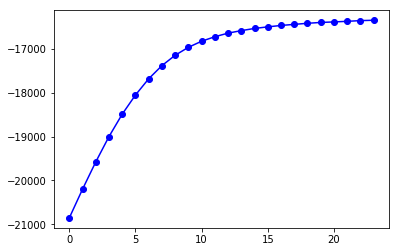

In [23]:
plt.plot(range(len(logL_hists[i])),logL_hists[i],'bo-')
plt.show()

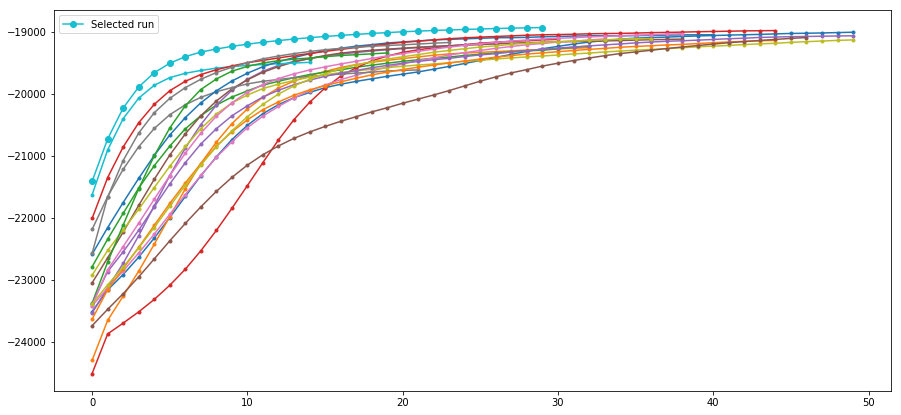

In [74]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [21]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [25]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.923077 |     0.923077 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.93895 |      0.93895 |
+----+--------+------------+--------------+


#### 1st configuration: Normal ($T$ = 100, $T_{max}$ = 10 )

In [32]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7639397639397639


*** Soft-Majority (Train with softMV) ***
Train


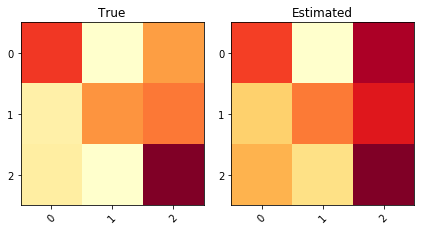

KL divergence: 0.1298	Pearson Correlation between diagonals: 0.9918


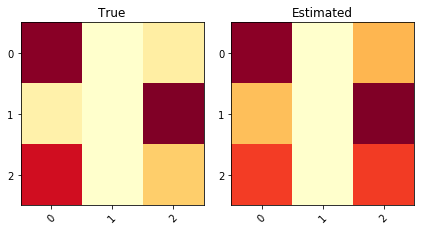

KL divergence: 0.0992	Pearson Correlation between diagonals: 0.8988


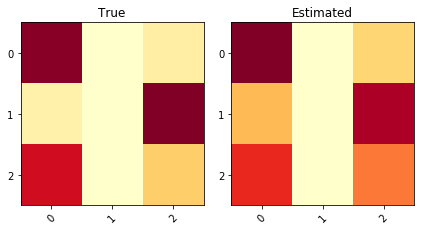

KL divergence: 0.0717	Pearson Correlation between diagonals: 0.9589


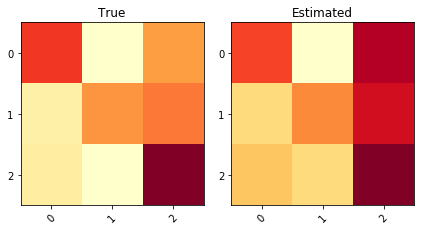

KL divergence: 0.1421	Pearson Correlation between diagonals: 0.9944


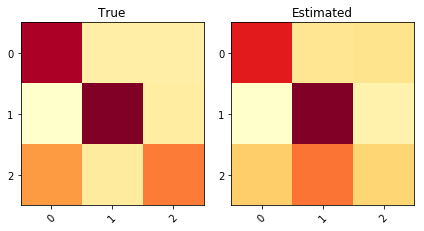

KL divergence: 0.1713	Pearson Correlation between diagonals: 0.9888


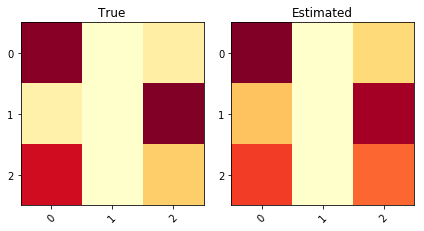

KL divergence: 0.0714	Pearson Correlation between diagonals: 0.9470


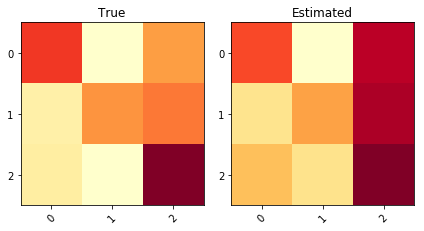

KL divergence: 0.1390	Pearson Correlation between diagonals: 0.9996


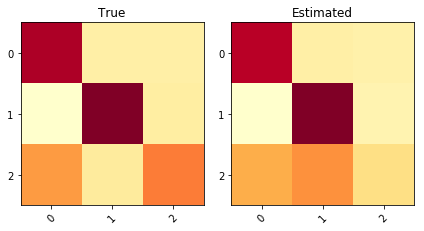

KL divergence: 0.1707	Pearson Correlation between diagonals: 0.9986


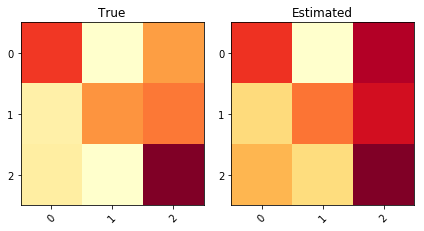

KL divergence: 0.1293	Pearson Correlation between diagonals: 0.9969


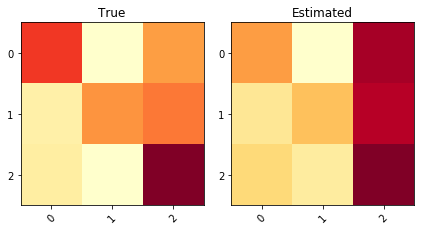

KL divergence: 0.1422	Pearson Correlation between diagonals: 0.9737


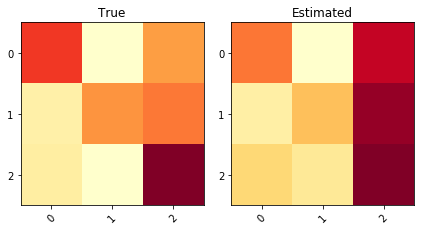

KL divergence: 0.1317	Pearson Correlation between diagonals: 0.9971


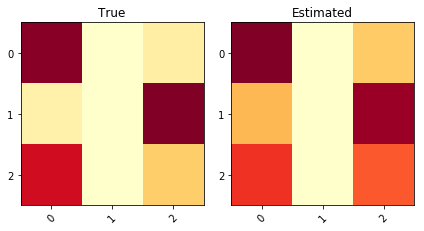

KL divergence: 0.0836	Pearson Correlation between diagonals: 0.9370


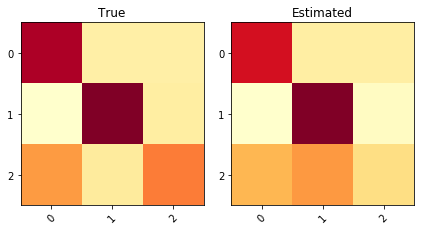

KL divergence: 0.1621	Pearson Correlation between diagonals: 0.9986


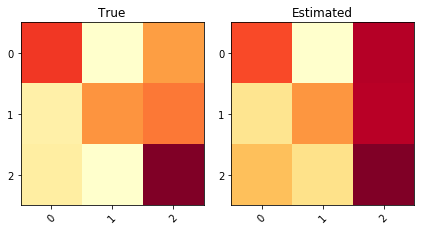

KL divergence: 0.1284	Pearson Correlation between diagonals: 0.9962


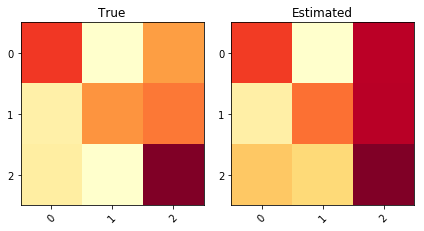

KL divergence: 0.1325	Pearson Correlation between diagonals: 0.9893
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.681319 |     0.681319 |     0.132734 |              0.971539 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.686203 |     0.686203 |
+----+--------+------------+--------------+


In [33]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


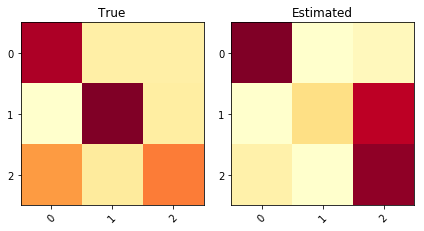

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6286


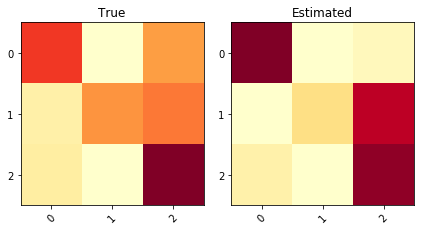

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7722


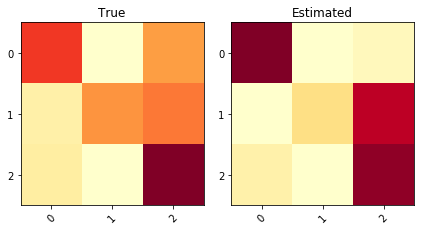

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7722


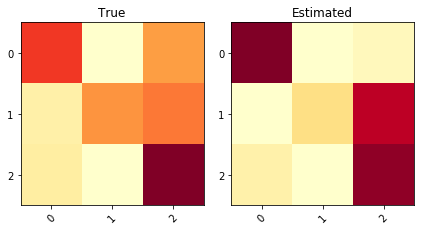

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7722


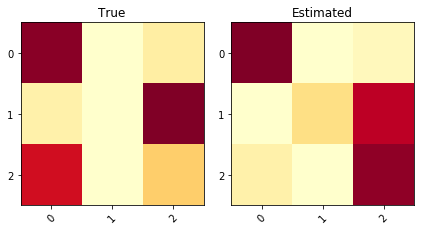

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7486


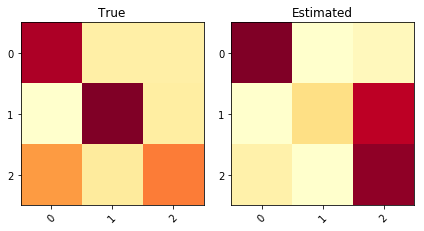

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6286


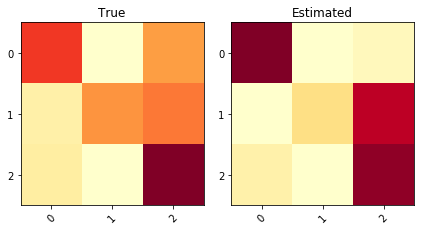

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7722


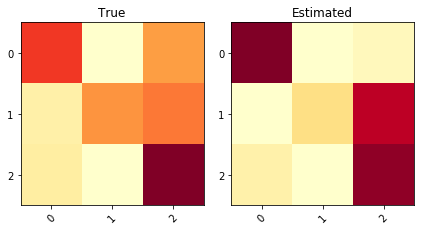

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7722


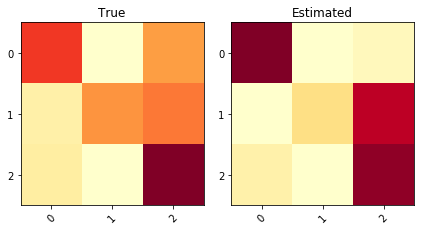

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7722


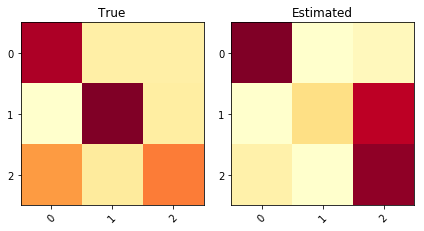

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6286


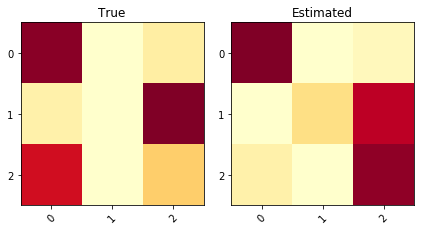

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7486


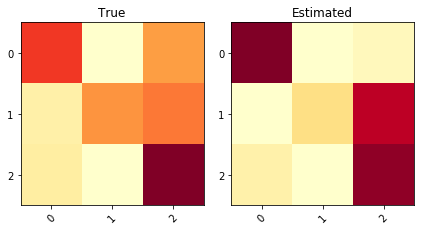

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7722


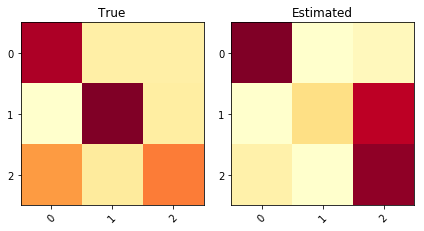

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6286


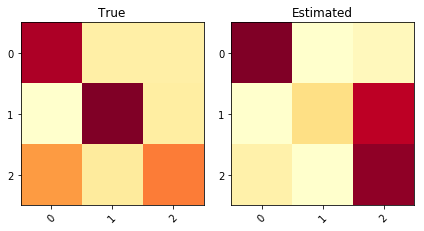

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6286


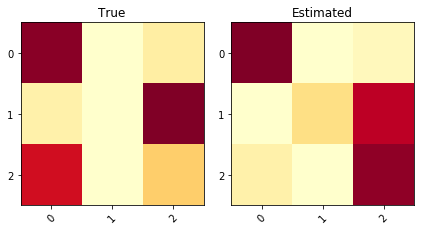

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7486
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.681319 |     0.681319 |      0.59983 |              0.332536 |
+----+--------+------------+--------------+--------------+-----------------------+


In [34]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


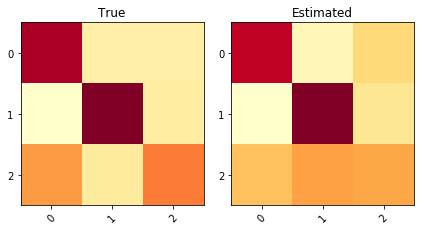

KL divergence: 0.1032	Pearson Correlation between diagonals: 0.9994


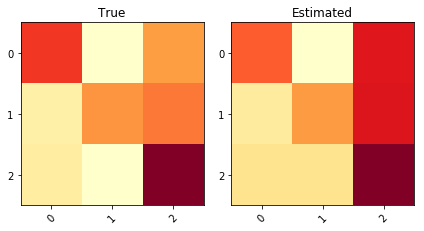

KL divergence: 0.0844	Pearson Correlation between diagonals: 0.9908


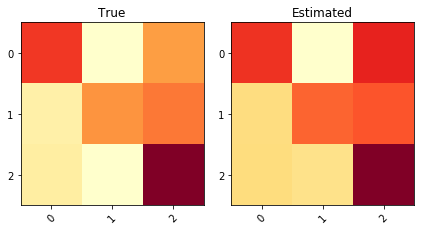

KL divergence: 0.0809	Pearson Correlation between diagonals: 0.9897


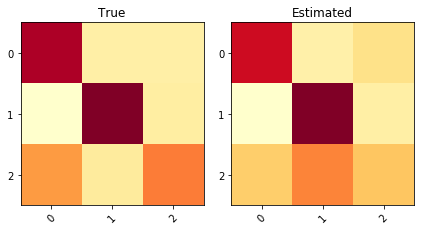

KL divergence: 0.1235	Pearson Correlation between diagonals: 0.9980


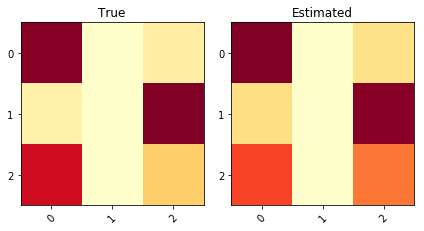

KL divergence: 0.0427	Pearson Correlation between diagonals: 0.9585


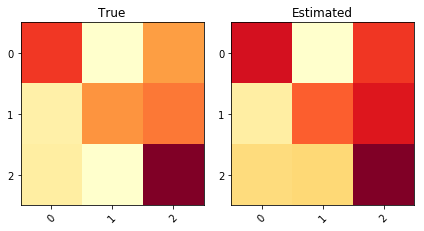

KL divergence: 0.0963	Pearson Correlation between diagonals: 0.9917


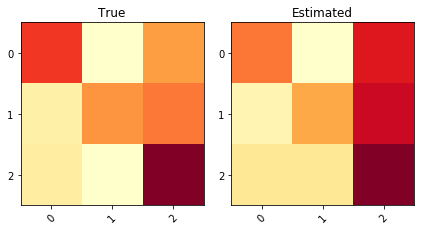

KL divergence: 0.0888	Pearson Correlation between diagonals: 0.9858


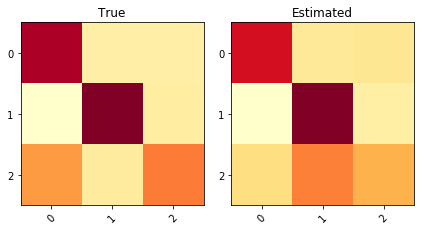

KL divergence: 0.1240	Pearson Correlation between diagonals: 0.9926


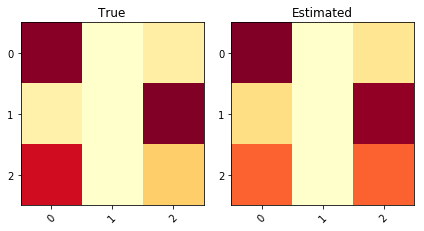

KL divergence: 0.0542	Pearson Correlation between diagonals: 0.9445


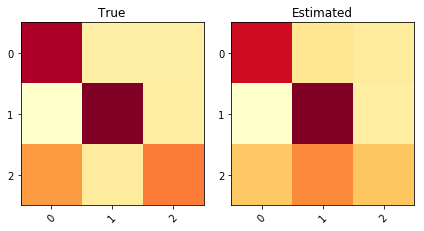

KL divergence: 0.1258	Pearson Correlation between diagonals: 0.9980


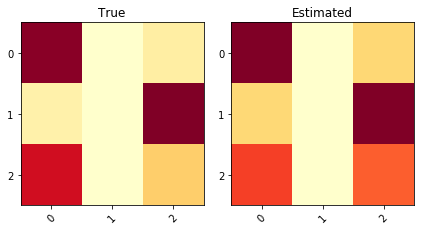

KL divergence: 0.0600	Pearson Correlation between diagonals: 0.9406


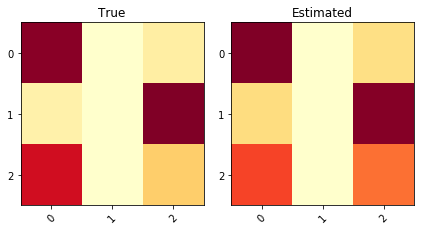

KL divergence: 0.0470	Pearson Correlation between diagonals: 0.9545


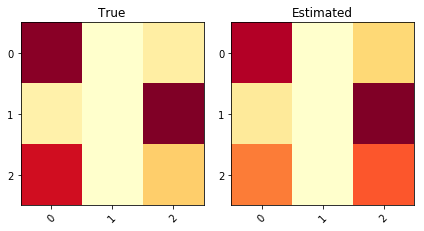

KL divergence: 0.0689	Pearson Correlation between diagonals: 0.9027


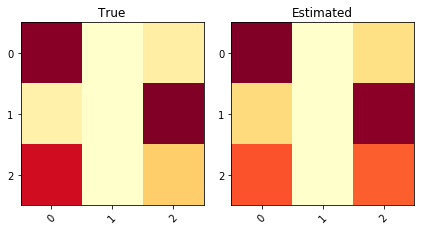

KL divergence: 0.0575	Pearson Correlation between diagonals: 0.9412


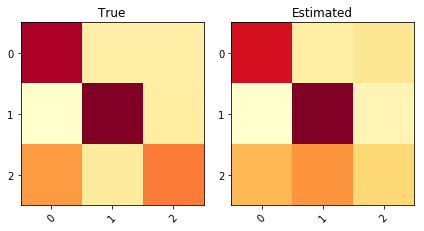

KL divergence: 0.1210	Pearson Correlation between diagonals: 0.9975
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.843712 |     0.843712 |    0.0907799 |              0.974686 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.835165 |     0.835165 |
+----+--------+------------+--------------+


In [35]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


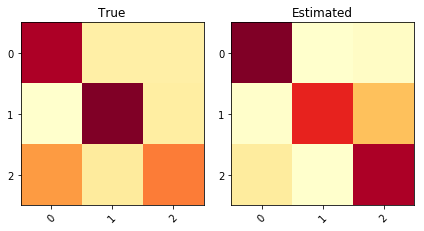

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.3680


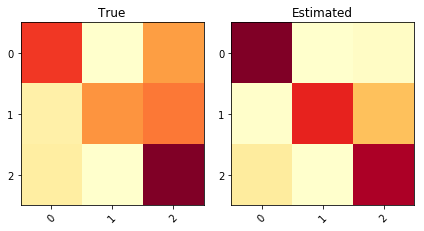

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.5476


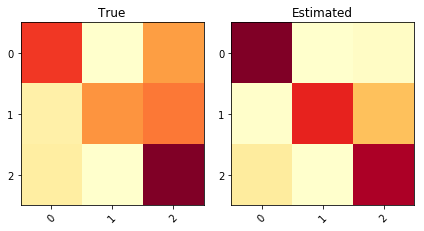

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.5476


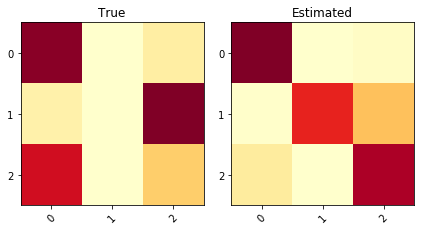

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.9123


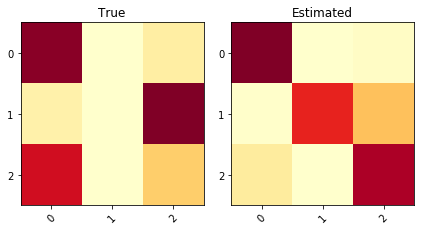

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.9123


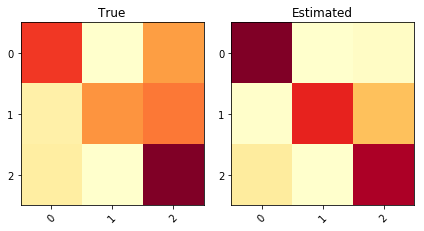

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.5476


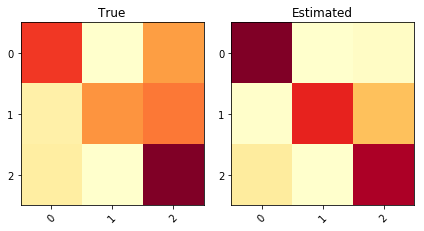

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.5476


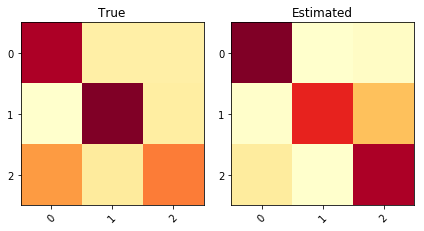

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.3680


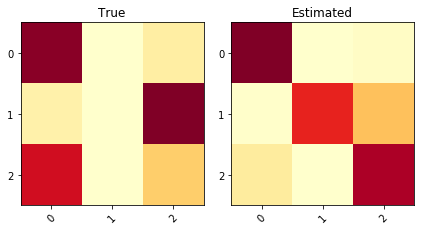

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.9123


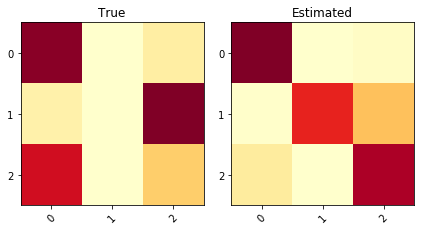

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.9123


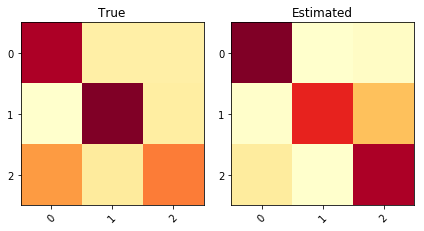

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.3680


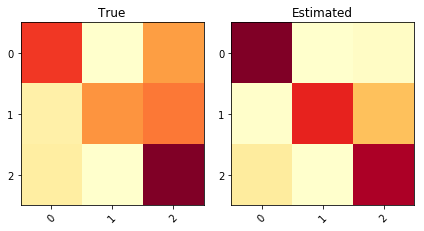

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.5476


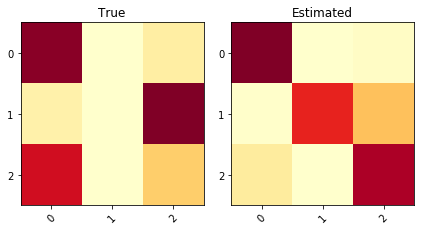

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.9123


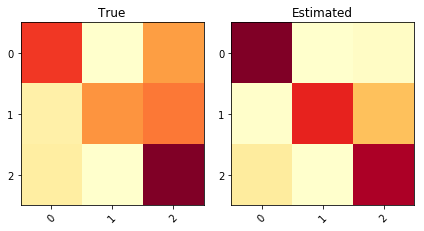

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.5476


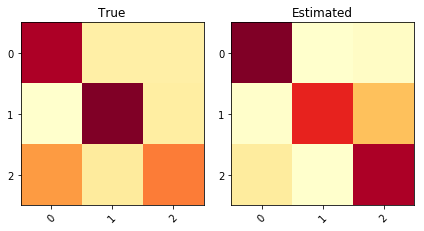

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.3680
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.843712 |     0.843712 |     0.533007 |              0.347628 |
+----+--------+------------+--------------+--------------+-----------------------+


In [36]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


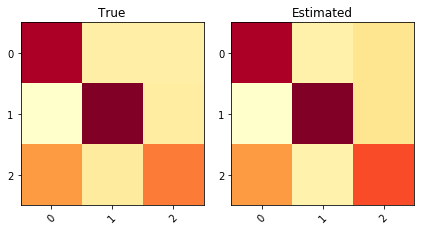

KL divergence: 0.0117	Pearson Correlation between diagonals: 0.9985


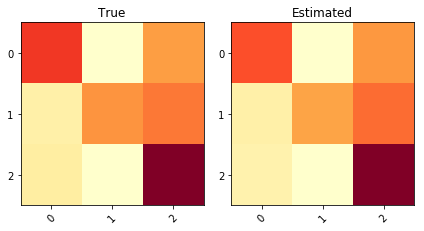

KL divergence: 0.0031	Pearson Correlation between diagonals: 0.9992


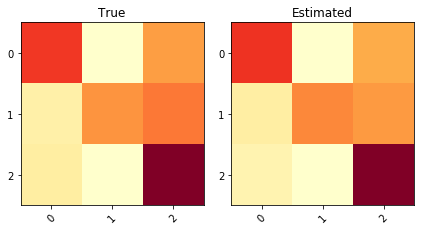

KL divergence: 0.0054	Pearson Correlation between diagonals: 0.9996


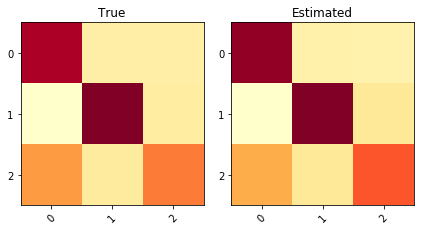

KL divergence: 0.0047	Pearson Correlation between diagonals: 0.9956


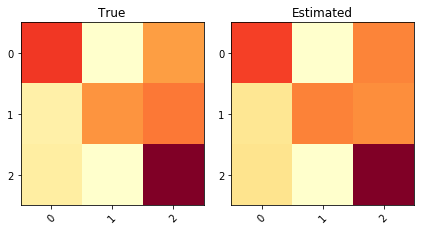

KL divergence: 0.0090	Pearson Correlation between diagonals: 0.9937


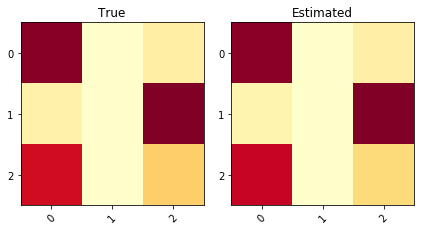

KL divergence: 0.0018	Pearson Correlation between diagonals: 0.9988


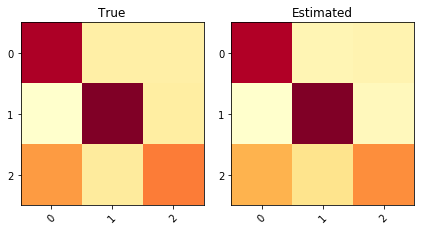

KL divergence: 0.0193	Pearson Correlation between diagonals: 1.0000


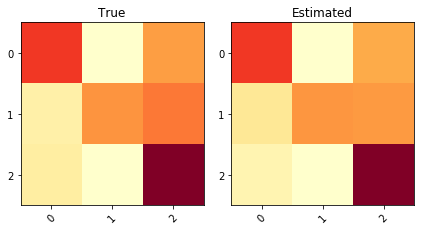

KL divergence: 0.0077	Pearson Correlation between diagonals: 1.0000


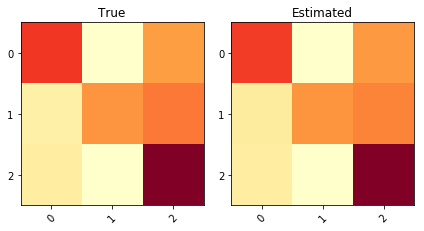

KL divergence: 0.0014	Pearson Correlation between diagonals: 0.9997


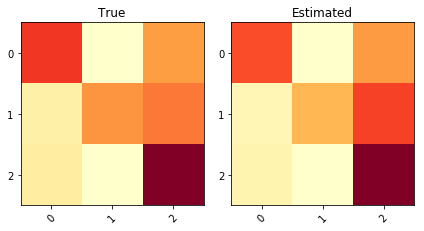

KL divergence: 0.0133	Pearson Correlation between diagonals: 0.9994


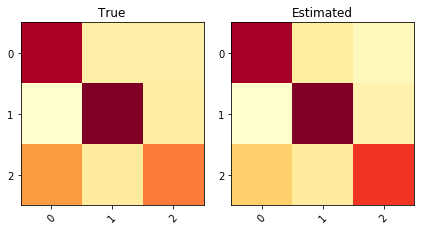

KL divergence: 0.0286	Pearson Correlation between diagonals: 0.9984


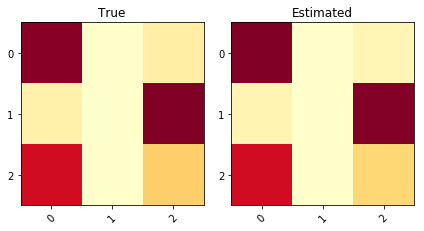

KL divergence: 0.0058	Pearson Correlation between diagonals: 0.9991


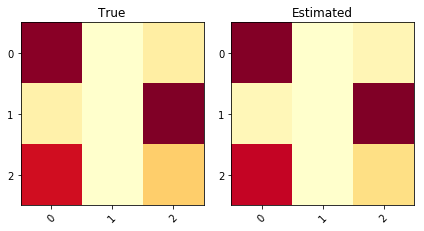

KL divergence: 0.0116	Pearson Correlation between diagonals: 0.9963


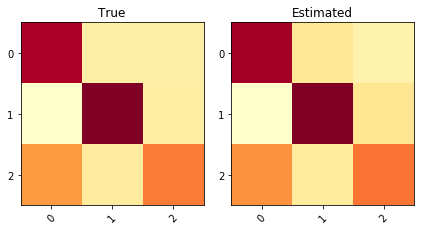

KL divergence: 0.0047	Pearson Correlation between diagonals: 0.9995


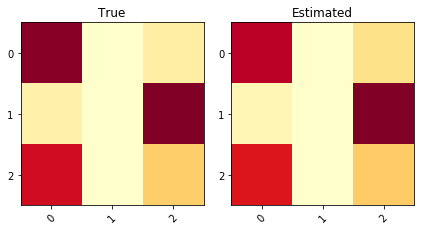

KL divergence: 0.0088	Pearson Correlation between diagonals: 0.9987
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.935694 |     0.935694 |    0.0105937 |              0.992496 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.948718 |     0.948718 |
+----+--------+------------+--------------+


In [37]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


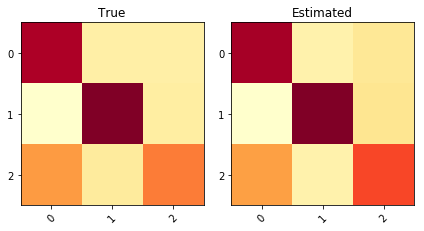

KL divergence: 0.0138	Pearson Correlation between diagonals: 0.9999


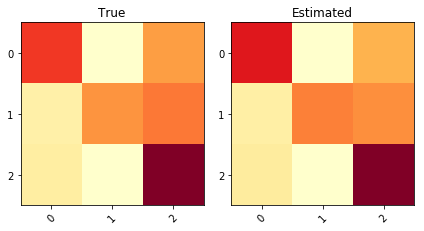

KL divergence: 0.0144	Pearson Correlation between diagonals: 0.9935


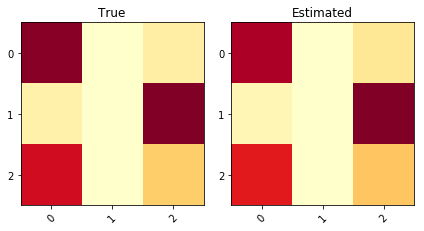

KL divergence: 0.0172	Pearson Correlation between diagonals: 0.9981


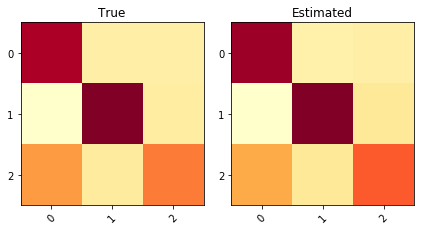

KL divergence: 0.0072	Pearson Correlation between diagonals: 0.9985


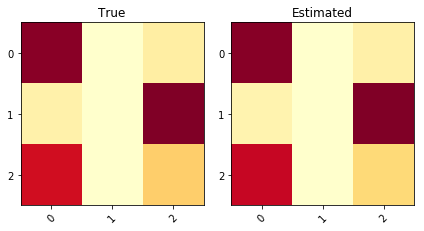

KL divergence: 0.0122	Pearson Correlation between diagonals: 0.9989


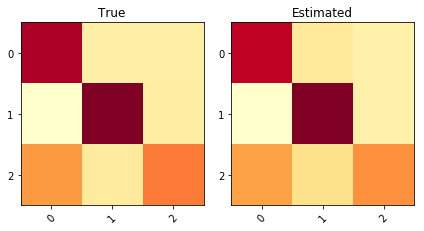

KL divergence: 0.0103	Pearson Correlation between diagonals: 0.9973


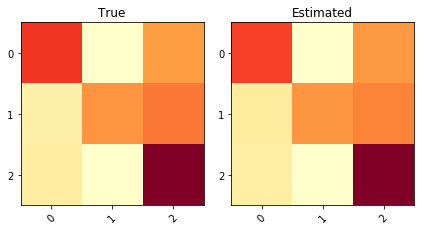

KL divergence: 0.0102	Pearson Correlation between diagonals: 0.9995


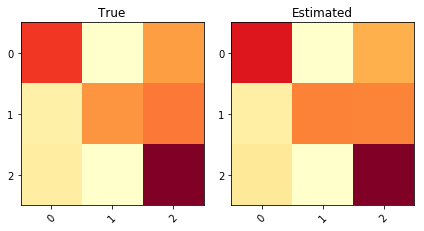

KL divergence: 0.0123	Pearson Correlation between diagonals: 0.9902


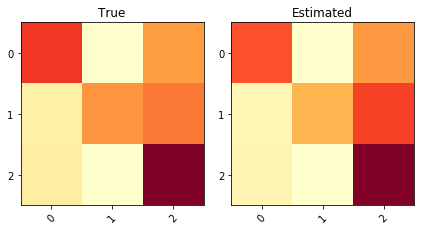

KL divergence: 0.0189	Pearson Correlation between diagonals: 0.9999


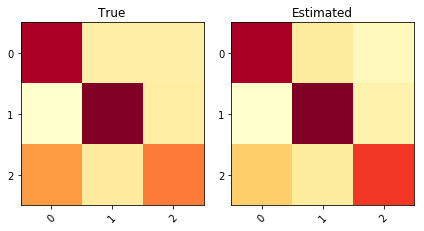

KL divergence: 0.0268	Pearson Correlation between diagonals: 0.9973


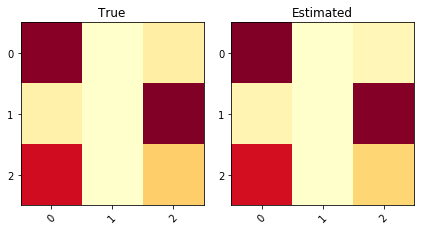

KL divergence: 0.0155	Pearson Correlation between diagonals: 0.9993


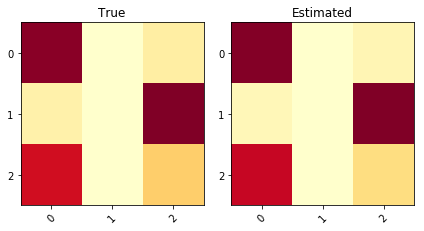

KL divergence: 0.0174	Pearson Correlation between diagonals: 0.9970


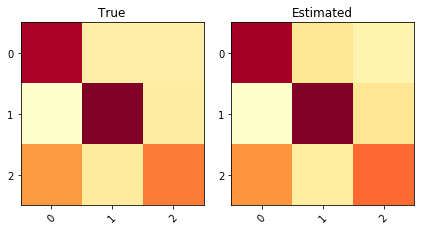

KL divergence: 0.0116	Pearson Correlation between diagonals: 0.9996


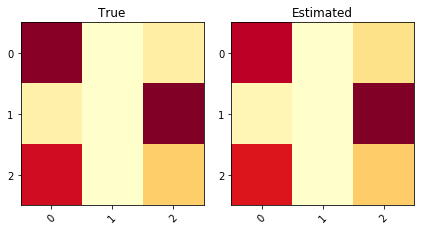

KL divergence: 0.0208	Pearson Correlation between diagonals: 0.9987


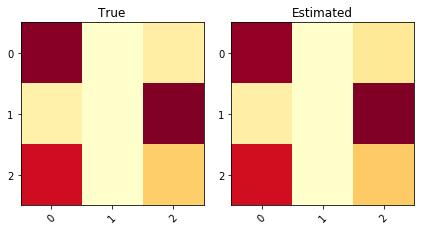

KL divergence: 0.0141	Pearson Correlation between diagonals: 0.9997
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.929182 |     0.929182 |    0.0154835 |              0.992634 |       0.134198 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.693702 |               0.727043 |
+----+-------------------------+------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+----

In [38]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


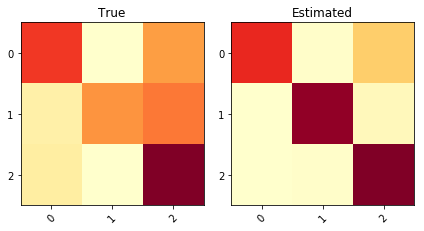

KL divergence: 0.4957	Pearson Correlation between diagonals: 0.2512


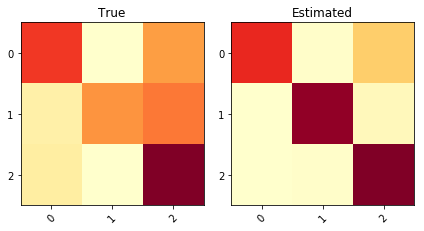

KL divergence: 0.4957	Pearson Correlation between diagonals: 0.2512


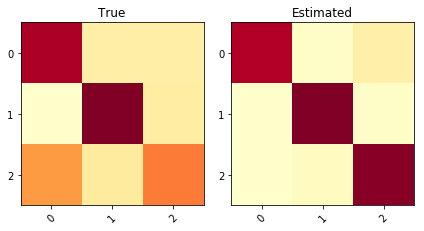

KL divergence: 0.6088	Pearson Correlation between diagonals: -0.1200


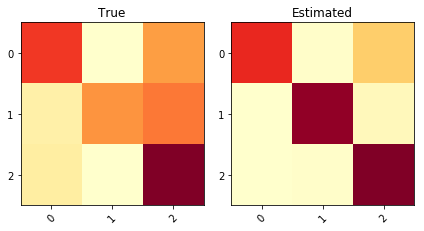

KL divergence: 0.4957	Pearson Correlation between diagonals: 0.2512


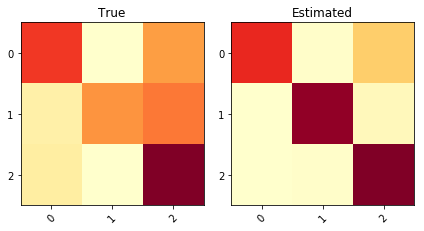

KL divergence: 0.4957	Pearson Correlation between diagonals: 0.2512


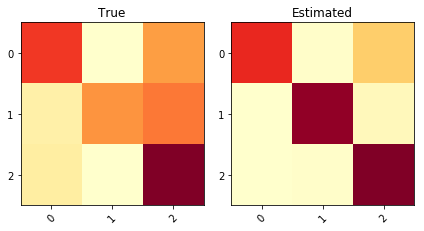

KL divergence: 0.4957	Pearson Correlation between diagonals: 0.2512


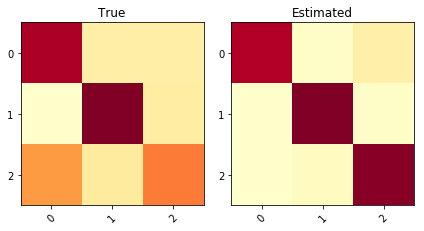

KL divergence: 0.6088	Pearson Correlation between diagonals: -0.1200


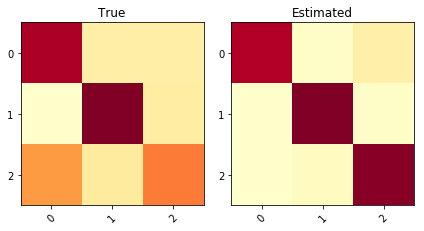

KL divergence: 0.6088	Pearson Correlation between diagonals: -0.1200


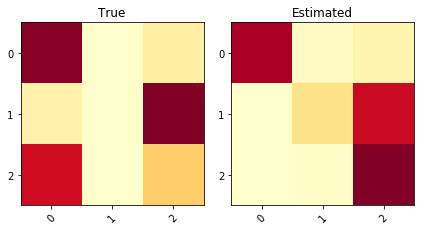

KL divergence: 1.1330	Pearson Correlation between diagonals: 0.6530


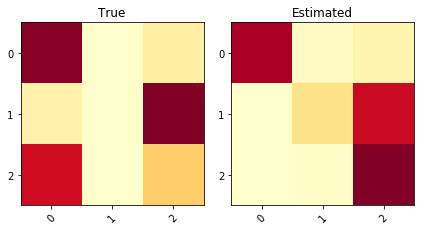

KL divergence: 1.1330	Pearson Correlation between diagonals: 0.6530


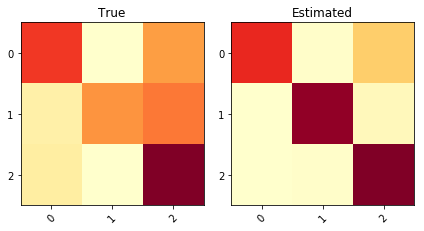

KL divergence: 0.4957	Pearson Correlation between diagonals: 0.2512


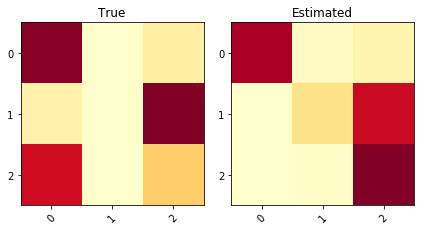

KL divergence: 1.1330	Pearson Correlation between diagonals: 0.6530


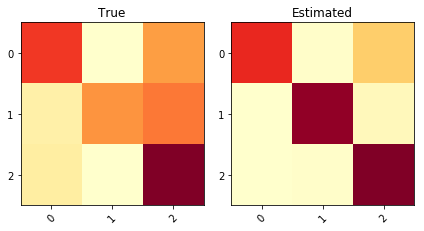

KL divergence: 0.4957	Pearson Correlation between diagonals: 0.2512


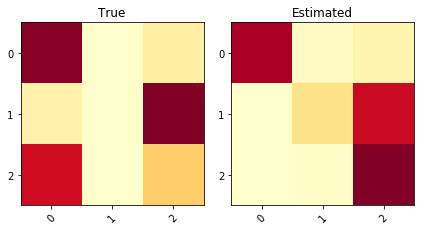

KL divergence: 1.1330	Pearson Correlation between diagonals: 0.6530


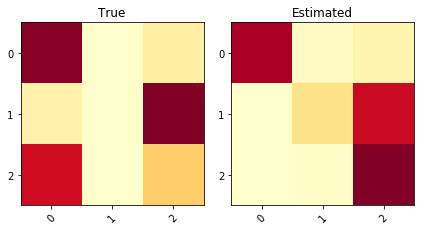

KL divergence: 1.1330	Pearson Correlation between diagonals: 0.6530
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.888889 |     0.888889 |     0.677308 |              0.228571 |      0.0931869 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.660621 |               0.738277 |
+----+-------------------------+------------------------+
Test


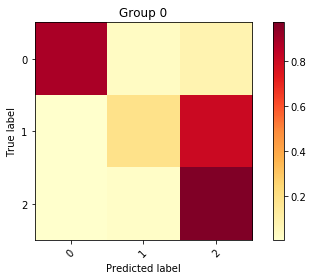

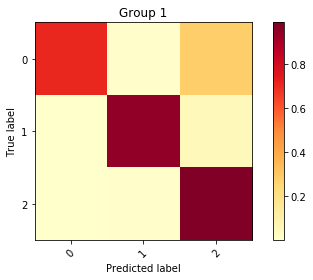

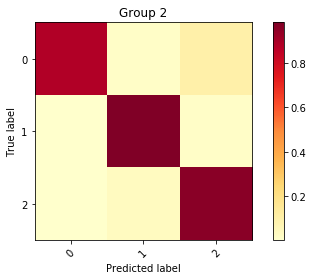

Inertia: 0.09037786722183228
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.152617 |     15 |  0.359516 |    0.682495 | 0.606585  |           0.767116 |   0.639805 |     0.639805 |
|  1 |        1 | 0.52355  |     52 |  0.310779 |    0.881808 | 0.136216  |           0.934776 |   0.862027 |     0.862027 |
|  2 |        2 | 0.323834 |     32 |  0.229734 |    0.941381 | 0.0615064 |           0.96967  |   0.913309 |     0.913309 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F

In [39]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


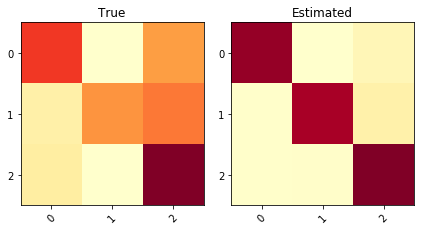

KL divergence: 0.4245	Pearson Correlation between diagonals: 0.9967


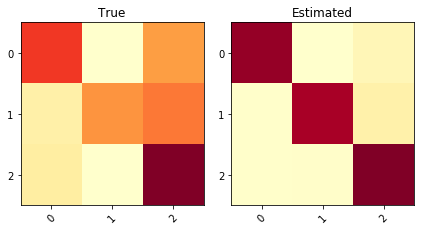

KL divergence: 0.4241	Pearson Correlation between diagonals: 0.9967


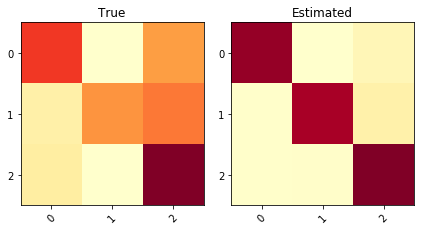

KL divergence: 0.4239	Pearson Correlation between diagonals: 0.9967


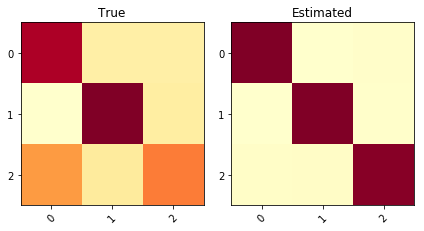

KL divergence: 0.5083	Pearson Correlation between diagonals: 0.9800


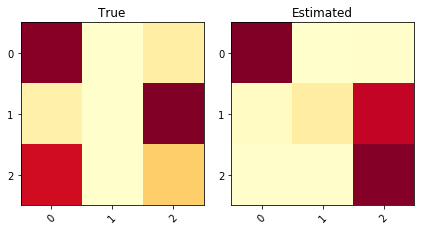

KL divergence: 0.8591	Pearson Correlation between diagonals: 0.7319


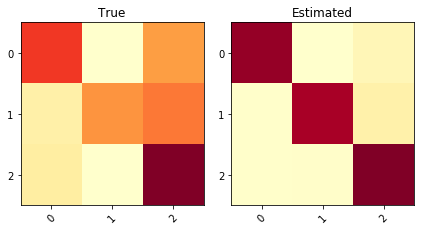

KL divergence: 0.4239	Pearson Correlation between diagonals: 0.9967


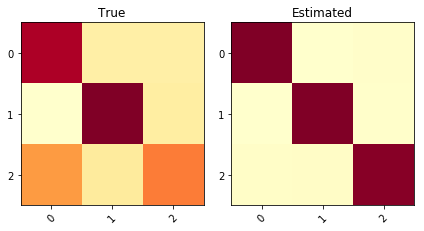

KL divergence: 0.5083	Pearson Correlation between diagonals: 0.9800


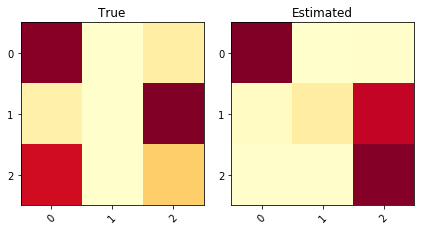

KL divergence: 0.8591	Pearson Correlation between diagonals: 0.7319


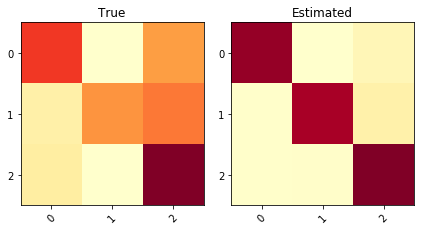

KL divergence: 0.4240	Pearson Correlation between diagonals: 0.9967


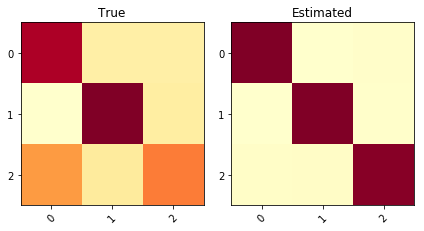

KL divergence: 0.5083	Pearson Correlation between diagonals: 0.9800


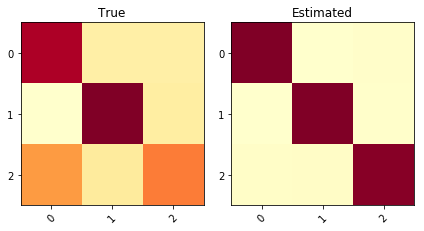

KL divergence: 0.5083	Pearson Correlation between diagonals: 0.9800


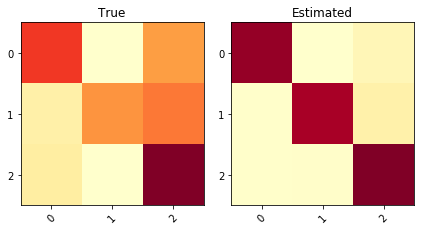

KL divergence: 0.4240	Pearson Correlation between diagonals: 0.9967


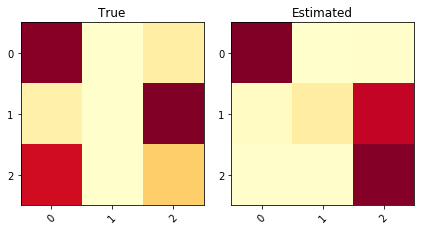

KL divergence: 0.8591	Pearson Correlation between diagonals: 0.7319


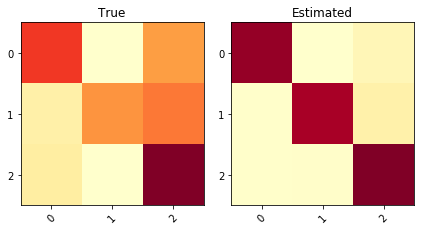

KL divergence: 0.4239	Pearson Correlation between diagonals: 0.9967


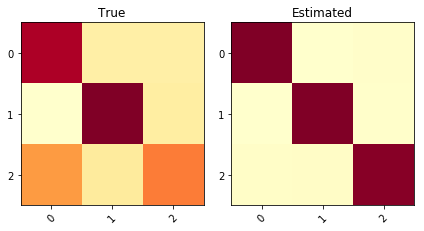

KL divergence: 0.5083	Pearson Correlation between diagonals: 0.9800
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.901506 |     0.901506 |     0.550205 |               0.93063 |      0.0927978 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                 0.65716 |               0.754489 |
+----+-------------------------+------------------------+
Test


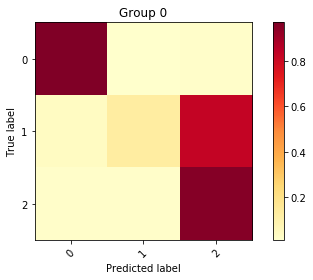

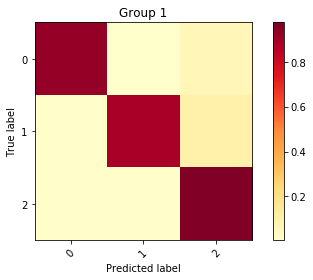

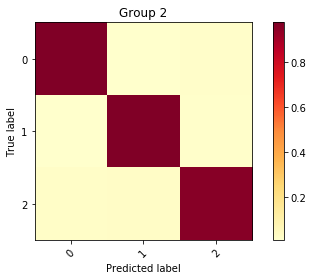

Inertia: 0.09043430079085131
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.183473 |     18 |  0.300149 |    0.686179 | 0.704452  |           0.751561 |   0.642247 |     0.642247 |
|  1 |        1 | 0.448877 |     44 |  0.258818 |    0.932679 | 0.0703481 |           0.965267 |   0.868132 |     0.868132 |
|  2 |        2 | 0.36765  |     36 |  0.14763  |    0.971332 | 0.0291253 |           0.985503 |   0.916972 |     0.916972 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F

In [40]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


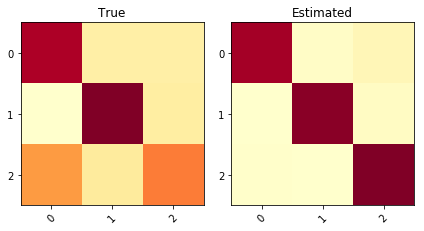

KL divergence: 0.5393	Pearson Correlation between diagonals: -0.5925


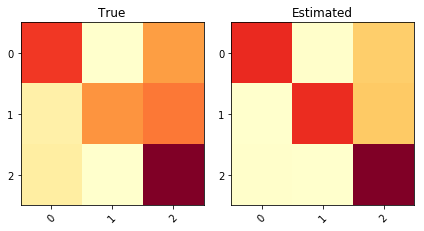

KL divergence: 0.1820	Pearson Correlation between diagonals: 0.9345


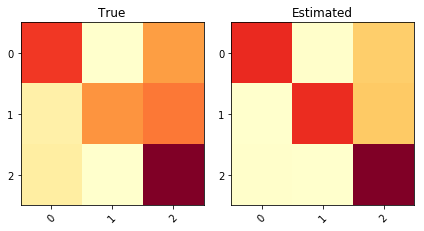

KL divergence: 0.1820	Pearson Correlation between diagonals: 0.9345


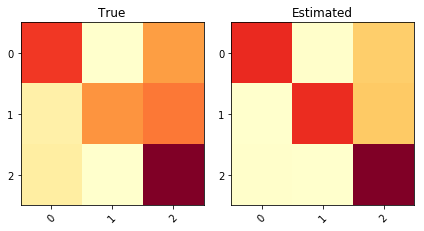

KL divergence: 0.1820	Pearson Correlation between diagonals: 0.9345


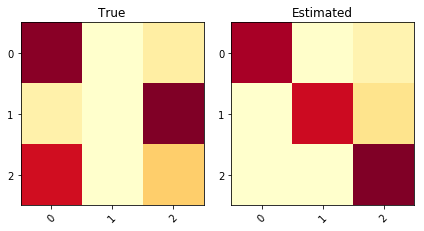

KL divergence: 1.6749	Pearson Correlation between diagonals: 0.3083


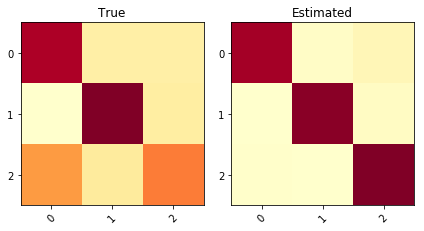

KL divergence: 0.5393	Pearson Correlation between diagonals: -0.5925


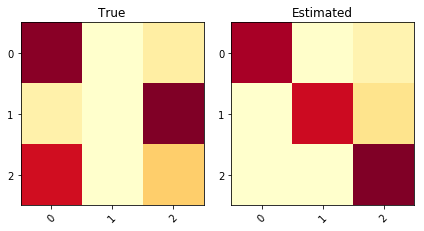

KL divergence: 1.6749	Pearson Correlation between diagonals: 0.3084


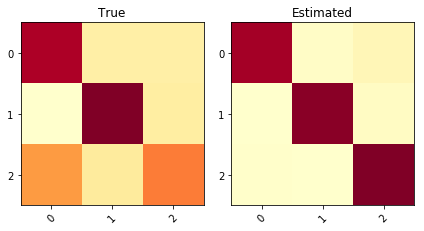

KL divergence: 0.5393	Pearson Correlation between diagonals: -0.5925


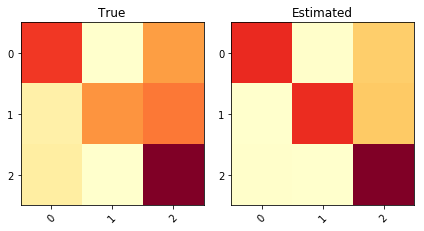

KL divergence: 0.1820	Pearson Correlation between diagonals: 0.9345


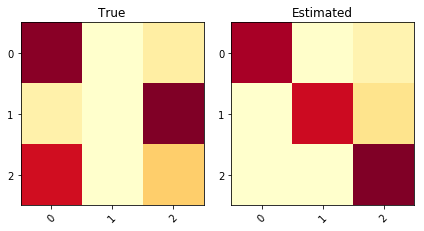

KL divergence: 1.6749	Pearson Correlation between diagonals: 0.3084


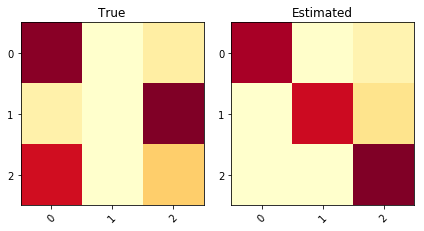

KL divergence: 1.6749	Pearson Correlation between diagonals: 0.3084


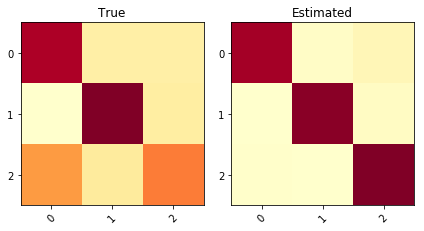

KL divergence: 0.5393	Pearson Correlation between diagonals: -0.5925


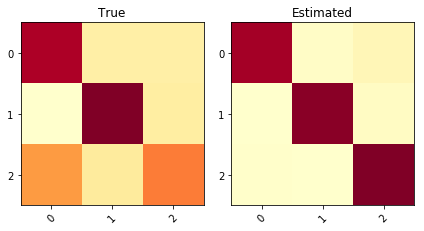

KL divergence: 0.5393	Pearson Correlation between diagonals: -0.5925


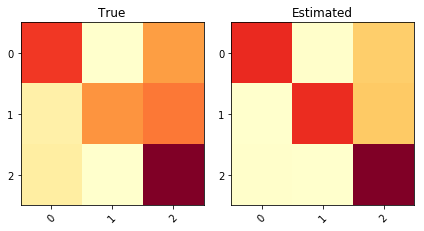

KL divergence: 0.1820	Pearson Correlation between diagonals: 0.9345


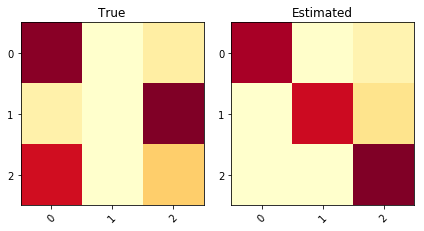

KL divergence: 1.6749	Pearson Correlation between diagonals: 0.3084
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.851038 |     0.851038 |     0.636107 |               0.31704 |      0.0801933 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.639267 |                0.77156 |
+----+-------------------------+------------------------+
Test


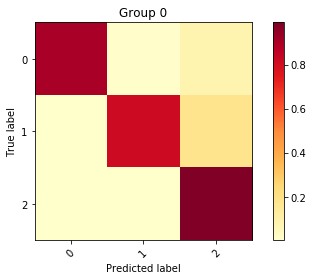

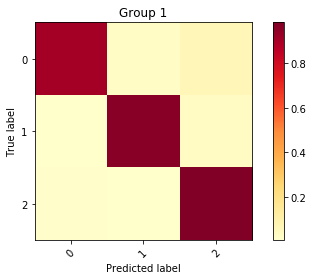

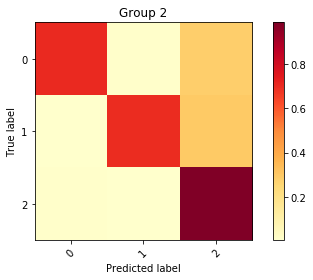

Inertia: 0.022313569206744432
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.427509 |     42 |  0.29512  |    0.904733 | 0.103354  |           0.949542 |   0.727717 |     0.727717 |
|  1 |        1 | 0.153228 |     15 |  0.213315 |    0.951157 | 0.0506054 |           0.974953 |   0.873016 |     0.873016 |
|  2 |        2 | 0.419264 |     41 |  0.449679 |    0.797954 | 0.239168  |           0.886398 |   0.648352 |     0.648352 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   

In [41]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 2) configuration: very bad MV ($T$ = 100, $T_{max}$ = 10 )

In [55]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.5734635734635735


*** Soft-Majority (Train with softMV) ***
Train


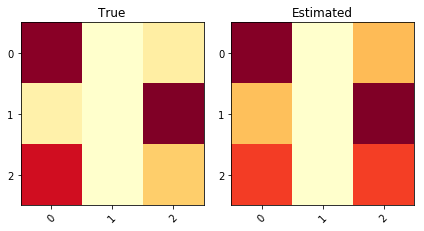

KL divergence: 0.0938	Pearson Correlation between diagonals: 0.9063


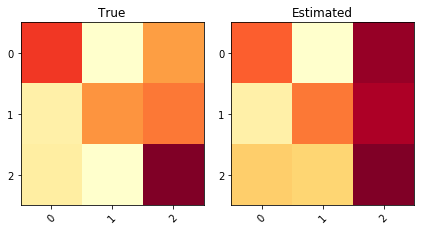

KL divergence: 0.1547	Pearson Correlation between diagonals: 0.9581


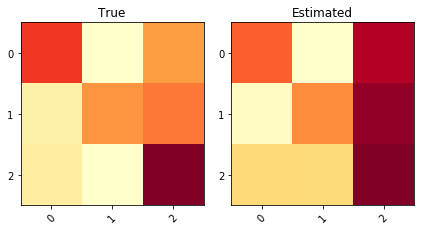

KL divergence: 0.1419	Pearson Correlation between diagonals: 0.9765


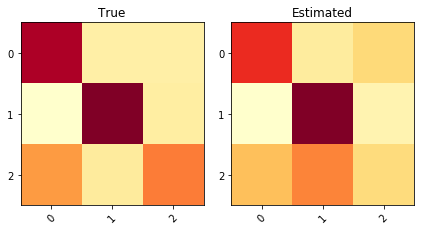

KL divergence: 0.1902	Pearson Correlation between diagonals: 0.9816


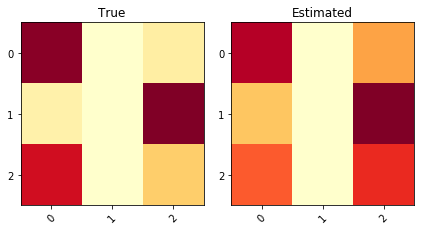

KL divergence: 0.1252	Pearson Correlation between diagonals: 0.8399


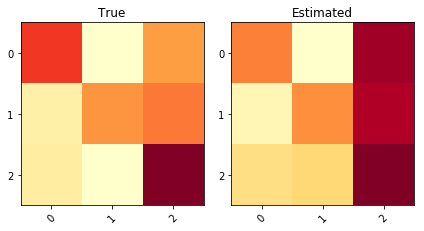

KL divergence: 0.1566	Pearson Correlation between diagonals: 0.9449


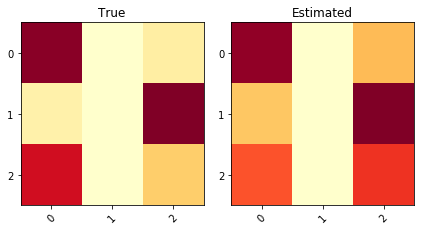

KL divergence: 0.1012	Pearson Correlation between diagonals: 0.8848


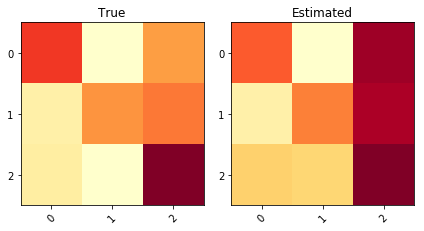

KL divergence: 0.1501	Pearson Correlation between diagonals: 0.9683


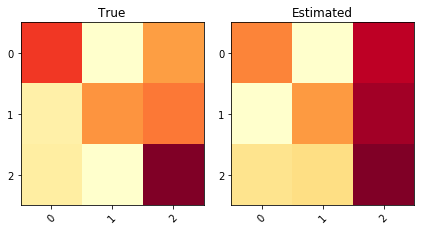

KL divergence: 0.1430	Pearson Correlation between diagonals: 0.9572


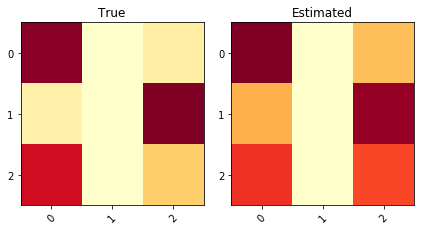

KL divergence: 0.0978	Pearson Correlation between diagonals: 0.9211


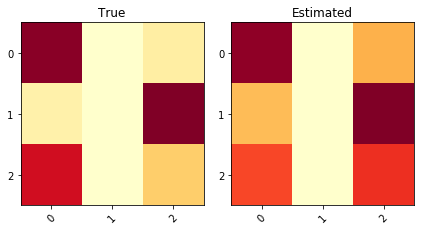

KL divergence: 0.1091	Pearson Correlation between diagonals: 0.8814


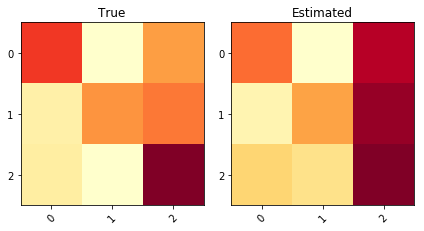

KL divergence: 0.1379	Pearson Correlation between diagonals: 0.9868


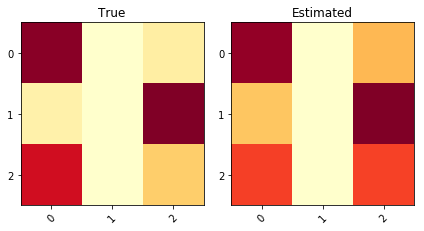

KL divergence: 0.0937	Pearson Correlation between diagonals: 0.9021


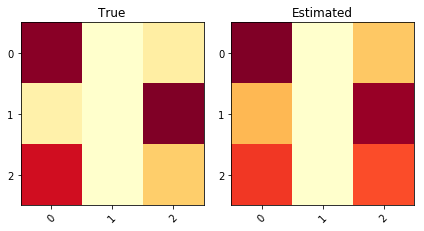

KL divergence: 0.0887	Pearson Correlation between diagonals: 0.9275


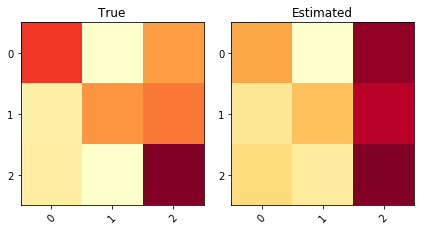

KL divergence: 0.1578	Pearson Correlation between diagonals: 0.9571
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.547416 |     0.547416 |     0.135122 |              0.931909 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.575092 |     0.575092 |
+----+--------+------------+--------------+


In [56]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


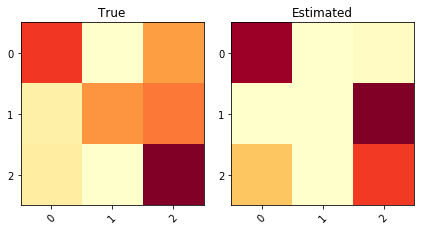

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.5993


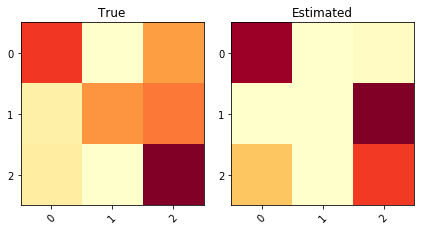

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.5993


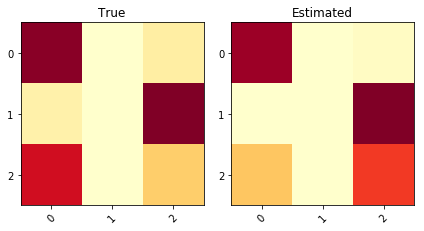

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8846


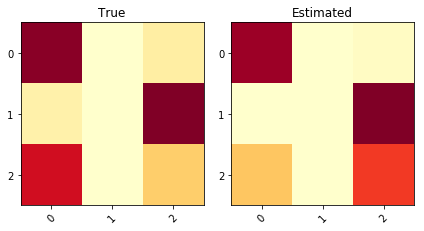

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8846


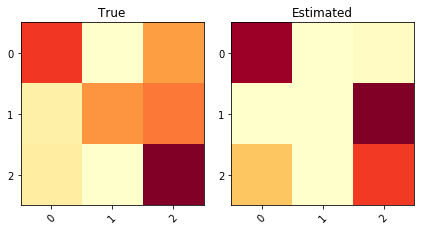

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.5993


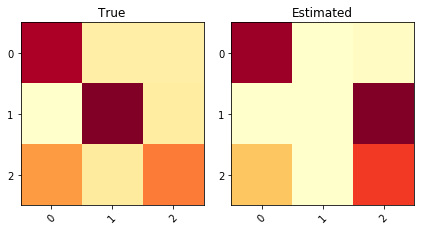

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.4259


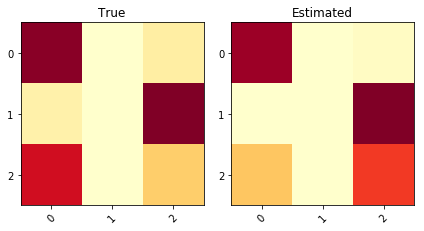

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8846


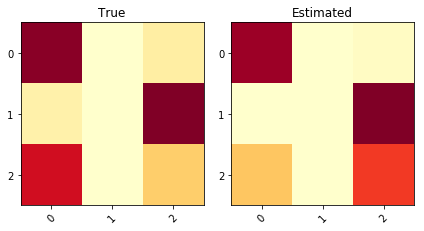

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8846


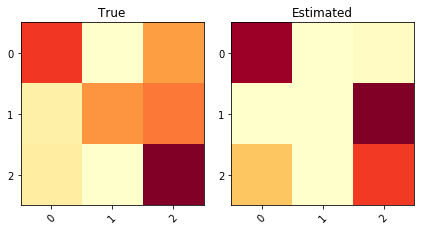

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.5993


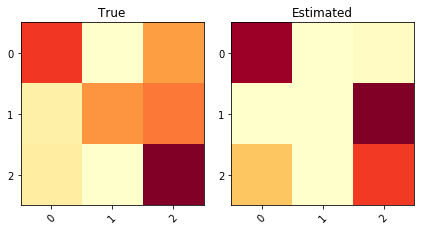

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.5993


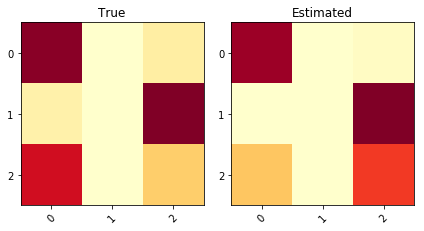

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8846


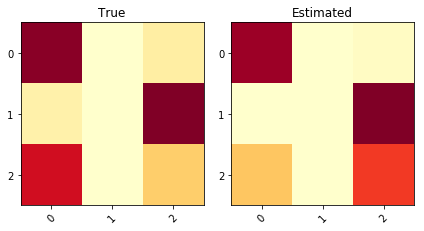

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8846


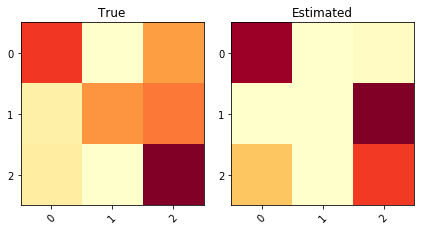

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.5993


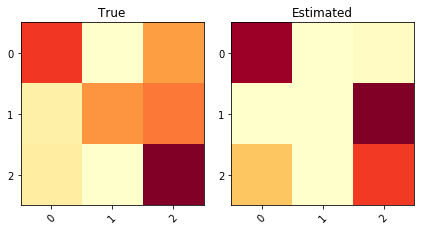

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.5993


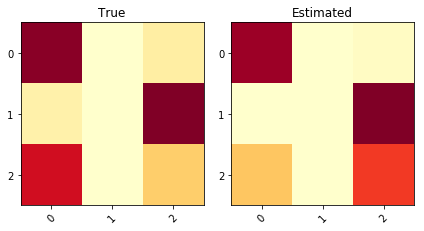

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8846
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.547416 |     0.547416 |      1.83324 |              0.607501 |
+----+--------+------------+--------------+--------------+-----------------------+


In [57]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


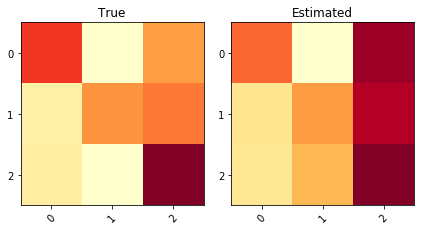

KL divergence: 0.1459	Pearson Correlation between diagonals: 0.9828


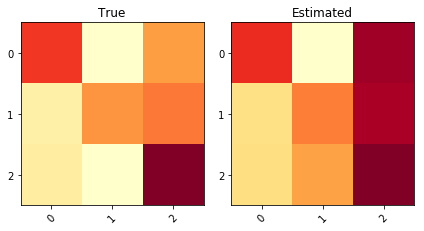

KL divergence: 0.1463	Pearson Correlation between diagonals: 1.0000


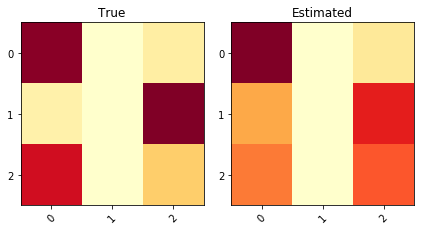

KL divergence: 0.1173	Pearson Correlation between diagonals: 0.9345


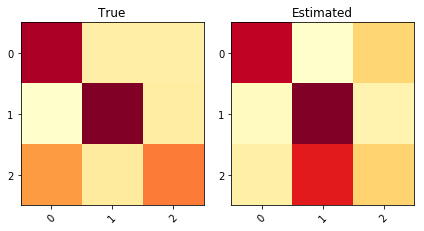

KL divergence: 0.2350	Pearson Correlation between diagonals: 0.9999


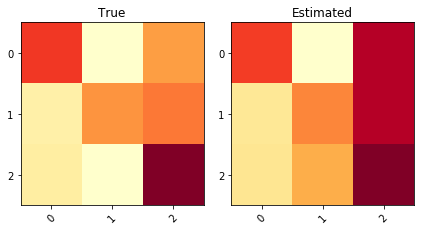

KL divergence: 0.1365	Pearson Correlation between diagonals: 0.9965


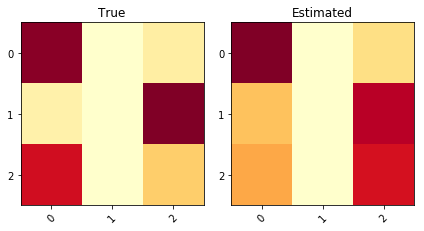

KL divergence: 0.1527	Pearson Correlation between diagonals: 0.8434


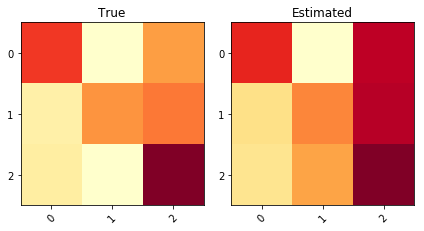

KL divergence: 0.1347	Pearson Correlation between diagonals: 0.9987


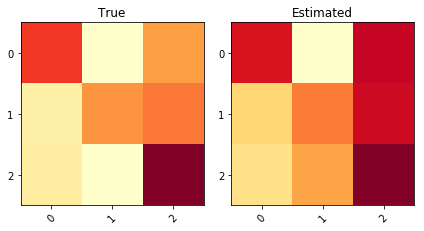

KL divergence: 0.1363	Pearson Correlation between diagonals: 0.9894


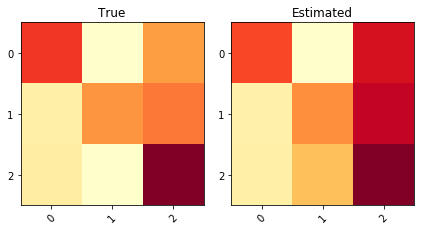

KL divergence: 0.1175	Pearson Correlation between diagonals: 0.9950


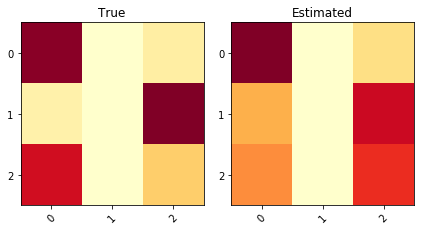

KL divergence: 0.1299	Pearson Correlation between diagonals: 0.8902


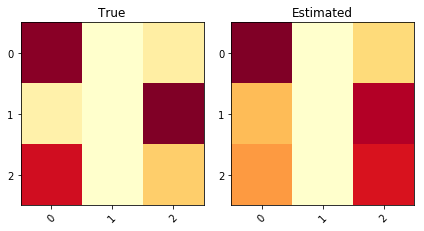

KL divergence: 0.1439	Pearson Correlation between diagonals: 0.8498


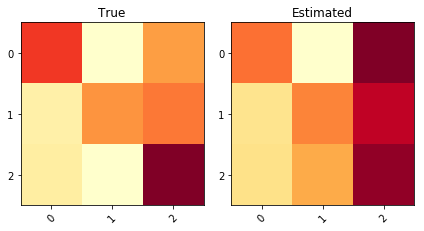

KL divergence: 0.1595	Pearson Correlation between diagonals: 0.9507


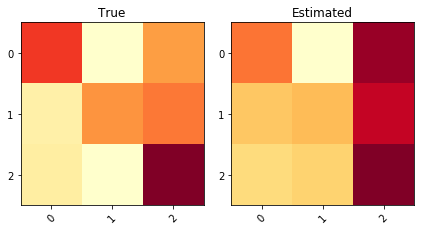

KL divergence: 0.1602	Pearson Correlation between diagonals: 0.9967


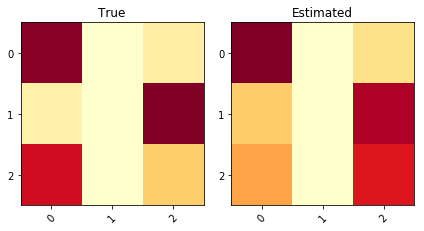

KL divergence: 0.1370	Pearson Correlation between diagonals: 0.8560


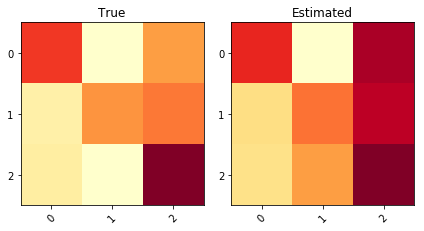

KL divergence: 0.1401	Pearson Correlation between diagonals: 0.9999
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.571429 |     0.571429 |     0.148251 |              0.929138 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.598291 |     0.598291 |
+----+--------+------------+--------------+


In [58]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


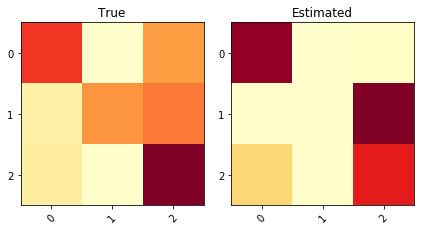

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6452


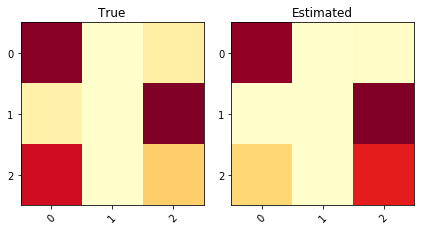

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8557


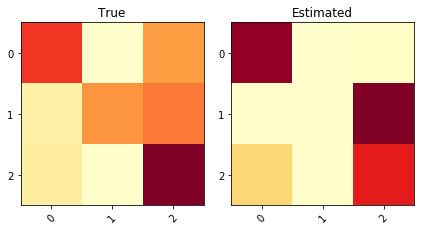

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6452


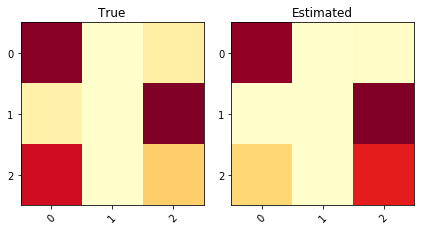

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8557


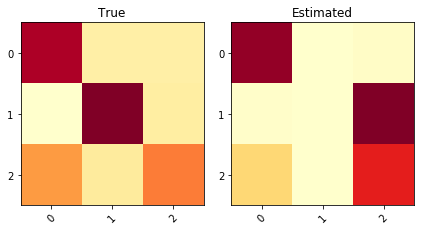

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.4783


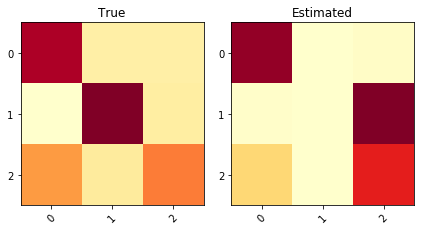

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.4783


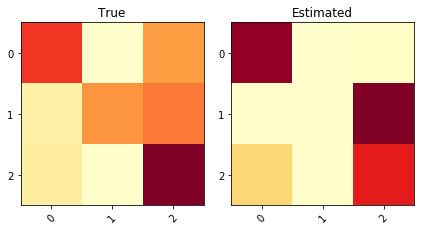

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6452


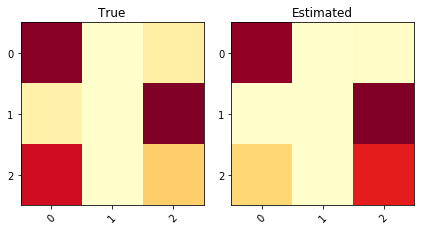

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8557


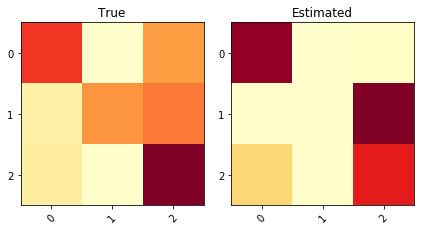

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6452


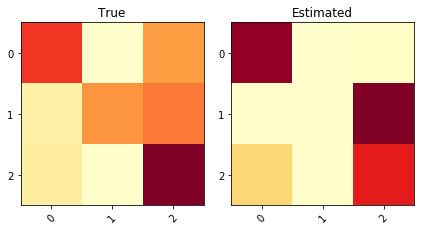

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6452


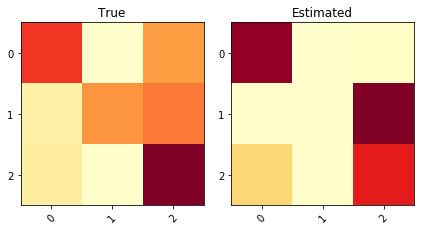

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6452


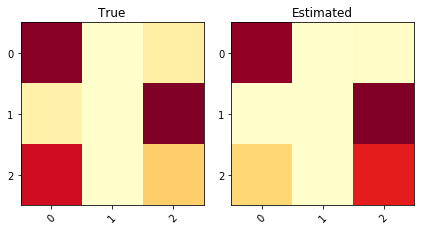

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8557


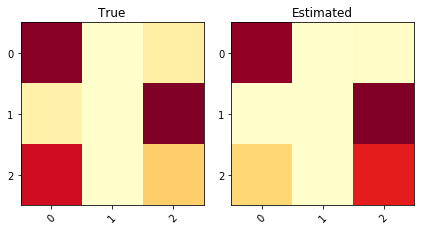

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8557


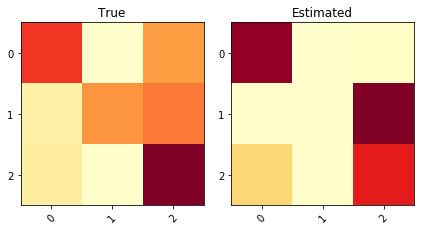

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6452


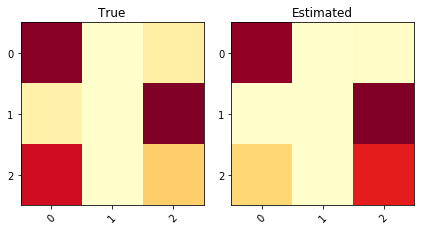

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8557
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.571429 |     0.571429 |      1.83324 |              0.607225 |
+----+--------+------------+--------------+--------------+-----------------------+


In [59]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


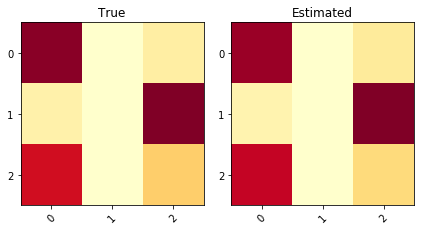

KL divergence: 0.0028	Pearson Correlation between diagonals: 0.9990


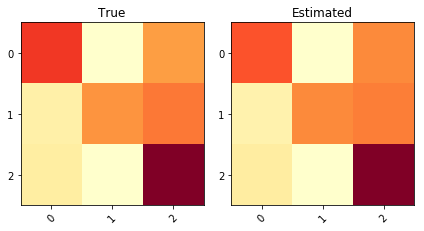

KL divergence: 0.0032	Pearson Correlation between diagonals: 0.9826


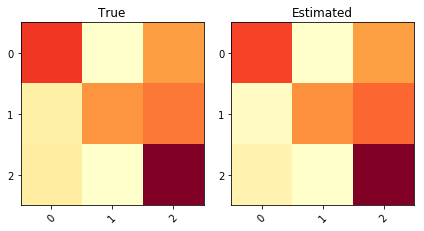

KL divergence: 0.0222	Pearson Correlation between diagonals: 0.9972


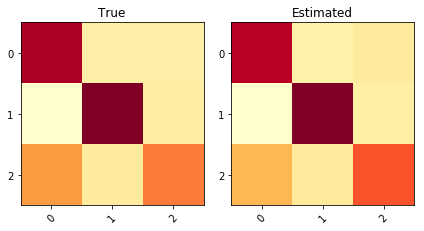

KL divergence: 0.0067	Pearson Correlation between diagonals: 0.9920


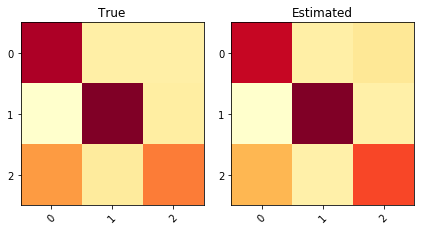

KL divergence: 0.0114	Pearson Correlation between diagonals: 0.9647


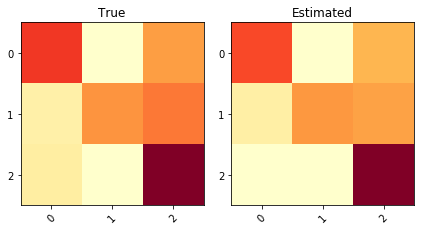

KL divergence: 0.1959	Pearson Correlation between diagonals: 0.9979


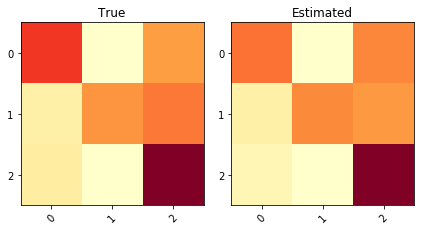

KL divergence: 0.0121	Pearson Correlation between diagonals: 0.9515


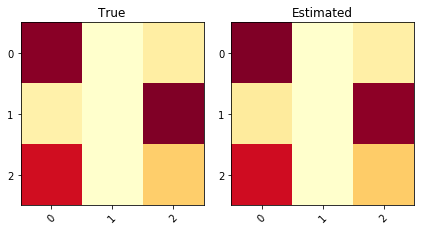

KL divergence: 0.0026	Pearson Correlation between diagonals: 1.0000


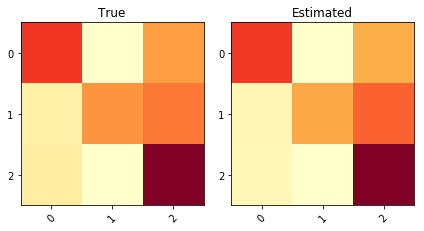

KL divergence: 0.0116	Pearson Correlation between diagonals: 0.9978


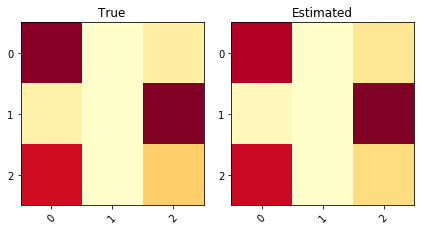

KL divergence: 0.0102	Pearson Correlation between diagonals: 0.9991


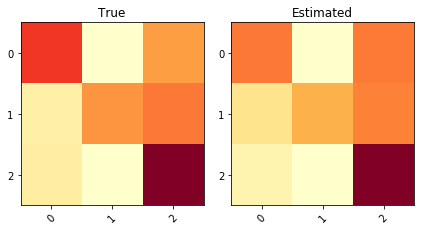

KL divergence: 0.0192	Pearson Correlation between diagonals: 0.9907


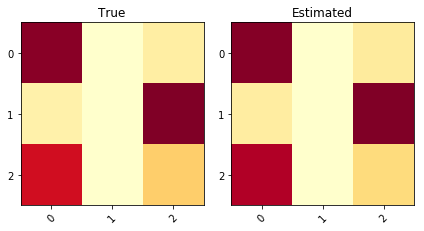

KL divergence: 0.0046	Pearson Correlation between diagonals: 0.9980


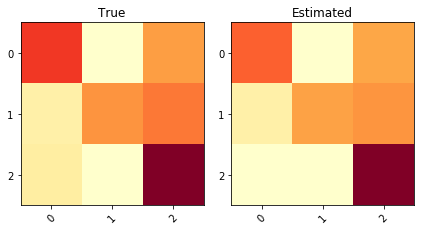

KL divergence: 0.2028	Pearson Correlation between diagonals: 0.9923


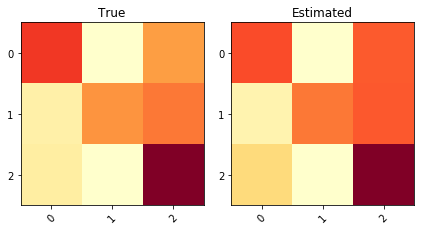

KL divergence: 0.0159	Pearson Correlation between diagonals: 0.9775


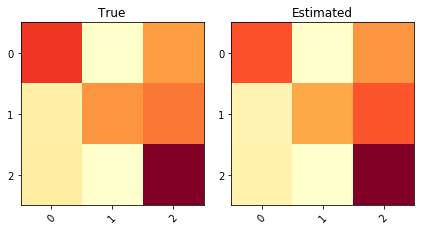

KL divergence: 0.0063	Pearson Correlation between diagonals: 0.9996
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.932031 |     0.932031 |    0.0227982 |              0.990658 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.95116 |      0.95116 |
+----+--------+------------+--------------+


In [60]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


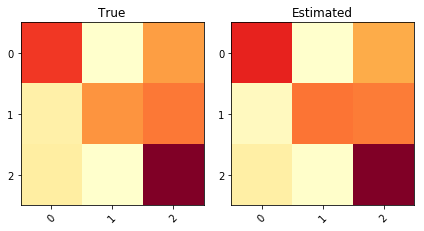

KL divergence: 0.0198	Pearson Correlation between diagonals: 1.0000


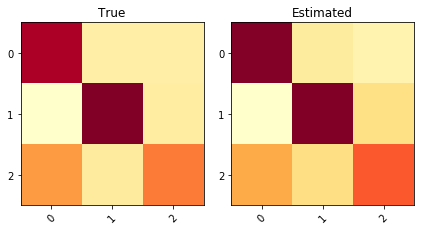

KL divergence: 0.0189	Pearson Correlation between diagonals: 0.9847


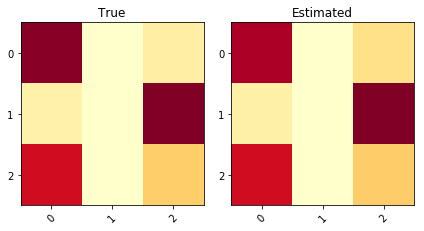

KL divergence: 0.0200	Pearson Correlation between diagonals: 0.9994


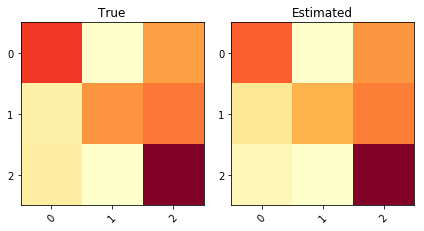

KL divergence: 0.0207	Pearson Correlation between diagonals: 0.9990


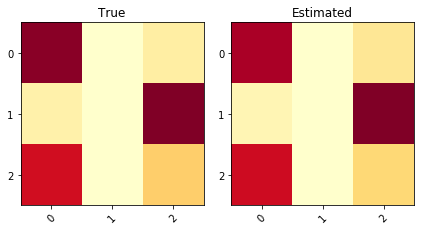

KL divergence: 0.0164	Pearson Correlation between diagonals: 0.9998


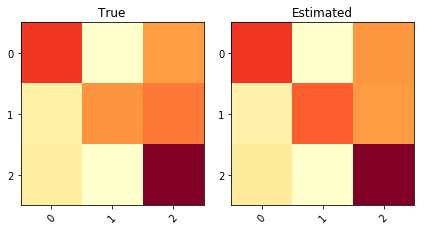

KL divergence: 0.0156	Pearson Correlation between diagonals: 0.9804


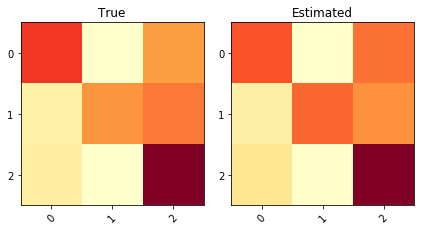

KL divergence: 0.0206	Pearson Correlation between diagonals: 0.9524


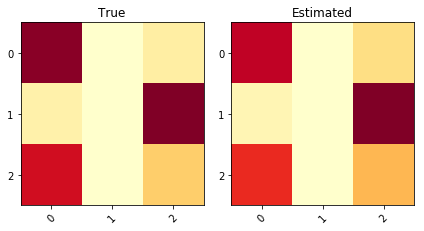

KL divergence: 0.0279	Pearson Correlation between diagonals: 0.9904


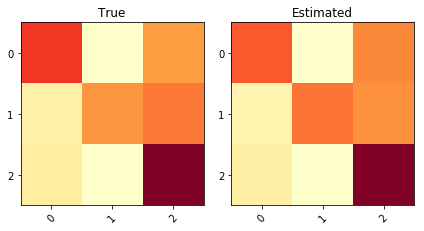

KL divergence: 0.0144	Pearson Correlation between diagonals: 0.9606


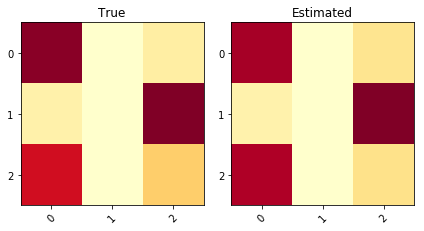

KL divergence: 0.0237	Pearson Correlation between diagonals: 0.9961


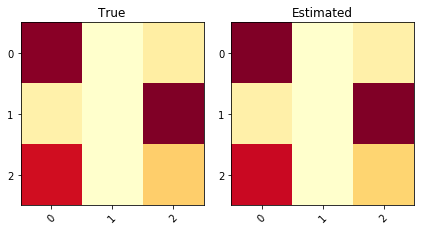

KL divergence: 0.0122	Pearson Correlation between diagonals: 0.9996


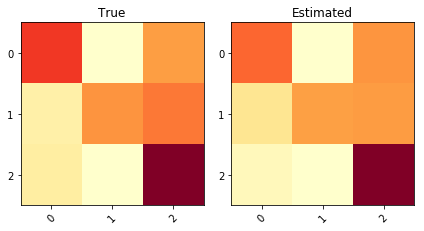

KL divergence: 0.0251	Pearson Correlation between diagonals: 0.9882


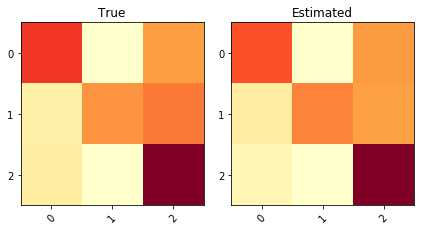

KL divergence: 0.0162	Pearson Correlation between diagonals: 0.9807


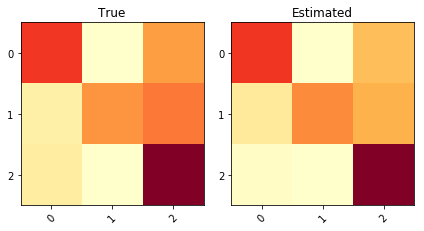

KL divergence: 0.0438	Pearson Correlation between diagonals: 0.9995


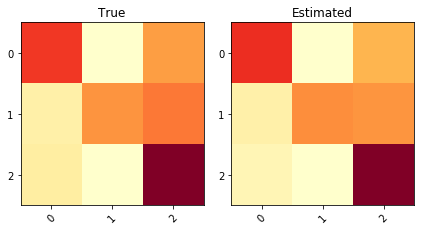

KL divergence: 0.0144	Pearson Correlation between diagonals: 0.9997
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.923077 |     0.923077 |    0.0173547 |              0.992159 |       0.234615 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.722518 |               0.638854 |
+----+-------------------------+------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+----

In [22]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


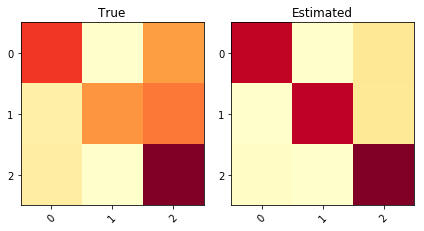

KL divergence: 0.2618	Pearson Correlation between diagonals: 0.9022


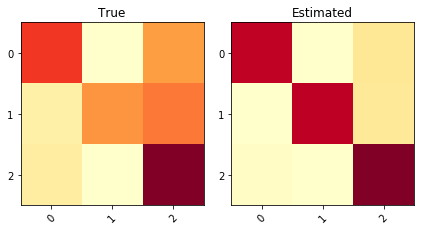

KL divergence: 0.2644	Pearson Correlation between diagonals: 0.8998


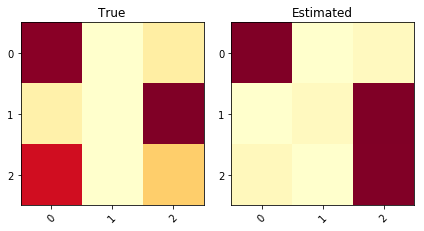

KL divergence: 0.6647	Pearson Correlation between diagonals: 0.7277


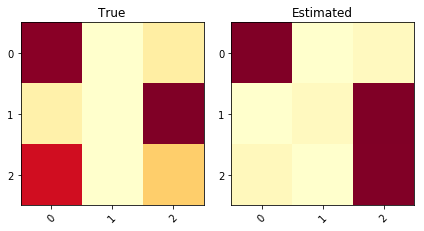

KL divergence: 0.6647	Pearson Correlation between diagonals: 0.7277


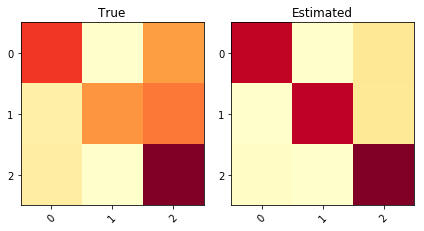

KL divergence: 0.2603	Pearson Correlation between diagonals: 0.9035


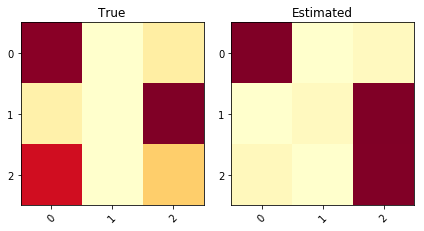

KL divergence: 0.6647	Pearson Correlation between diagonals: 0.7277


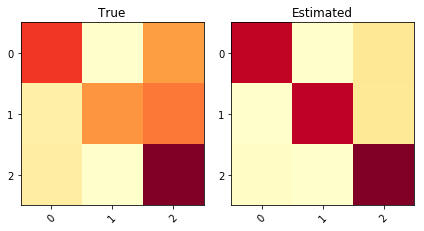

KL divergence: 0.2598	Pearson Correlation between diagonals: 0.9039


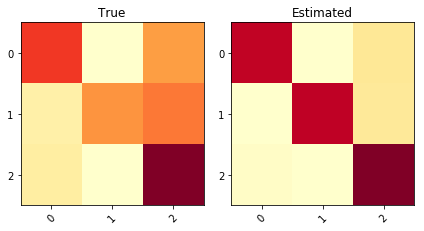

KL divergence: 0.2632	Pearson Correlation between diagonals: 0.9009


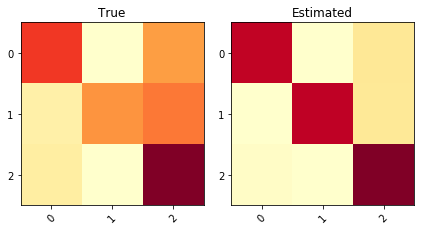

KL divergence: 0.2628	Pearson Correlation between diagonals: 0.9012


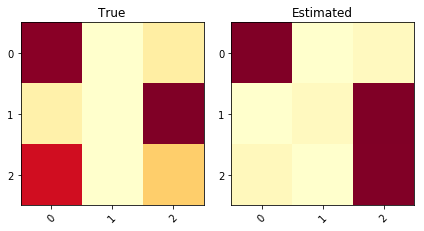

KL divergence: 0.6647	Pearson Correlation between diagonals: 0.7277


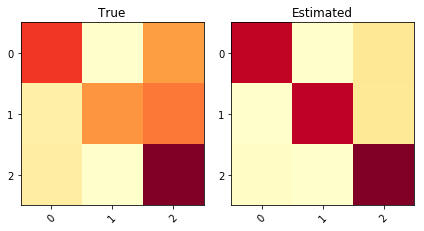

KL divergence: 0.2596	Pearson Correlation between diagonals: 0.9041


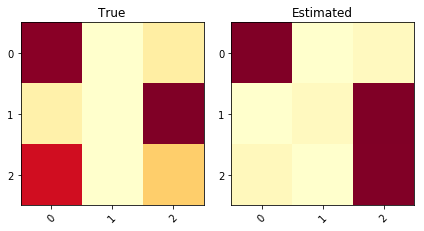

KL divergence: 0.6647	Pearson Correlation between diagonals: 0.7277


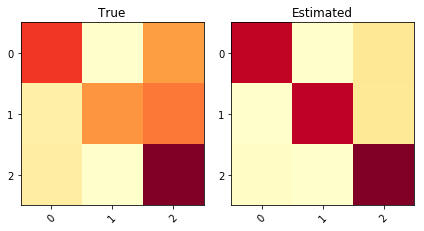

KL divergence: 0.2596	Pearson Correlation between diagonals: 0.9041


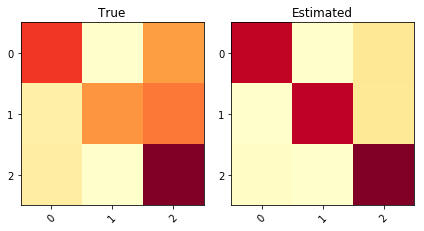

KL divergence: 0.2615	Pearson Correlation between diagonals: 0.9024


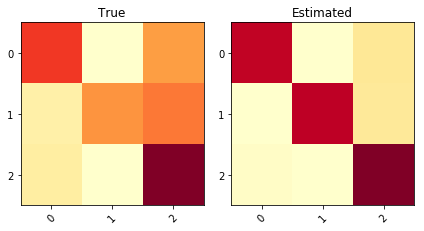

KL divergence: 0.2636	Pearson Correlation between diagonals: 0.9005
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.782255 |     0.782255 |     0.470311 |              0.675155 |       0.202414 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.672824 |               0.658894 |
+----+-------------------------+------------------------+
Test


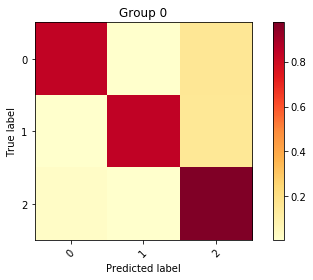

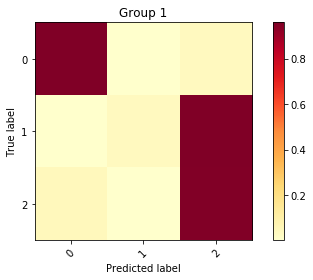

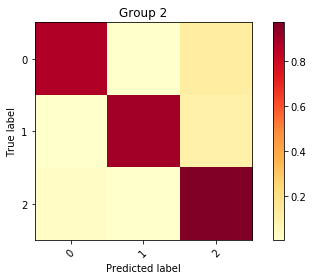

Inertia: 0.09819500557690237
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.24434  |     24 |  0.357063 |    0.883493 | 0.126452  |           0.938267 |   0.642247 |     0.642247 |
|  1 |        1 | 0.456138 |     45 |  0.190212 |    0.649936 | 1.11597   |           0.691226 |   0.562882 |     0.562882 |
|  2 |        2 | 0.299523 |     29 |  0.299117 |    0.914011 | 0.0909323 |           0.95526  |   0.730159 |     0.730159 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F

In [23]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


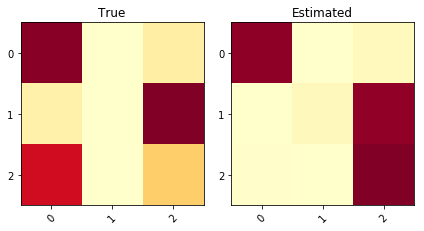

KL divergence: 1.0666	Pearson Correlation between diagonals: 0.7009


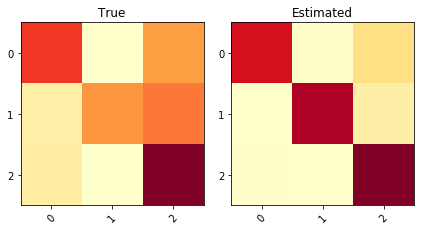

KL divergence: 0.3413	Pearson Correlation between diagonals: 0.5916


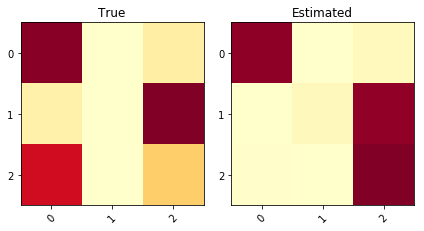

KL divergence: 1.0666	Pearson Correlation between diagonals: 0.7009


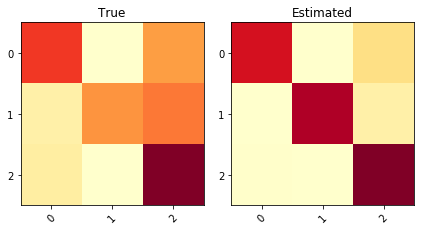

KL divergence: 0.3424	Pearson Correlation between diagonals: 0.5899


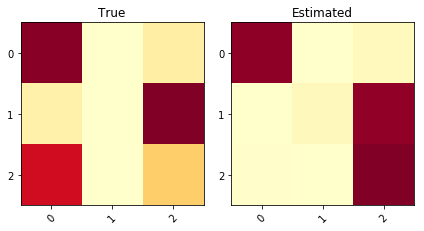

KL divergence: 1.0666	Pearson Correlation between diagonals: 0.7009


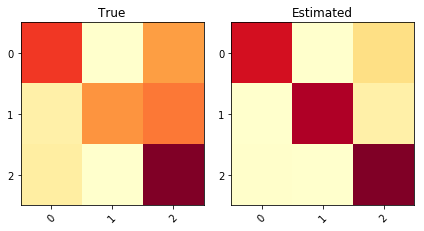

KL divergence: 0.3426	Pearson Correlation between diagonals: 0.5896


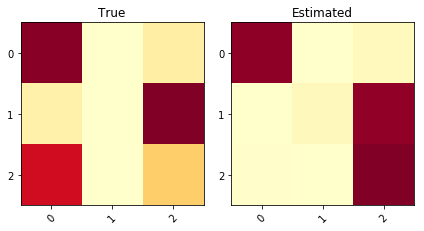

KL divergence: 1.0666	Pearson Correlation between diagonals: 0.7009


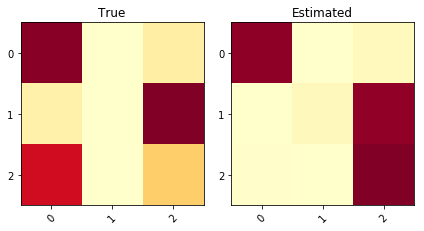

KL divergence: 1.0666	Pearson Correlation between diagonals: 0.7009


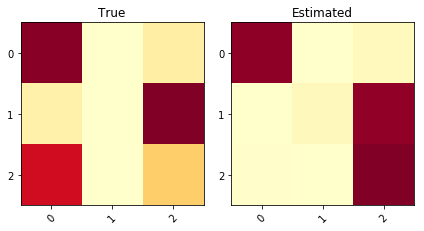

KL divergence: 1.0666	Pearson Correlation between diagonals: 0.7009


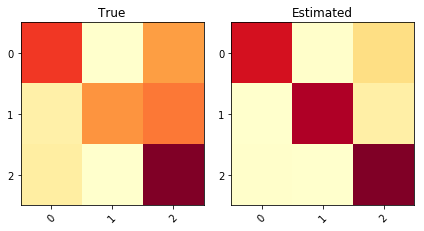

KL divergence: 0.3391	Pearson Correlation between diagonals: 0.5949


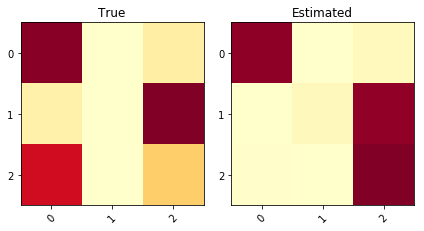

KL divergence: 1.0666	Pearson Correlation between diagonals: 0.7009


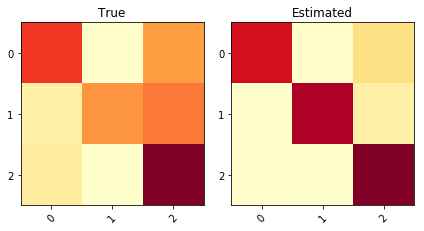

KL divergence: 0.3423	Pearson Correlation between diagonals: 0.5901


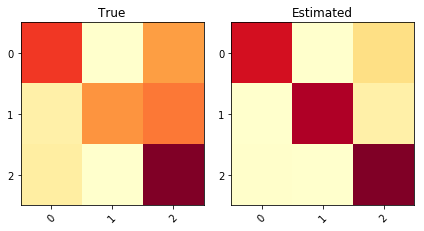

KL divergence: 0.3429	Pearson Correlation between diagonals: 0.5891


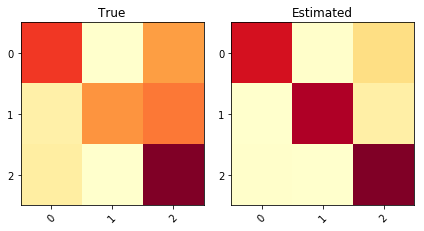

KL divergence: 0.3393	Pearson Correlation between diagonals: 0.5948


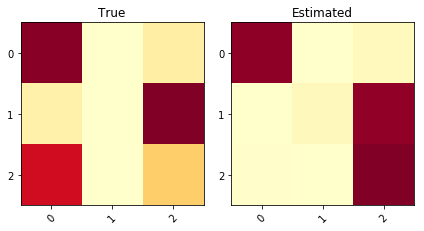

KL divergence: 1.0666	Pearson Correlation between diagonals: 0.7009
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.715914 |     0.715914 |      0.70937 |              0.543805 |       0.209609 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.674528 |               0.656716 |
+----+-------------------------+------------------------+
Test


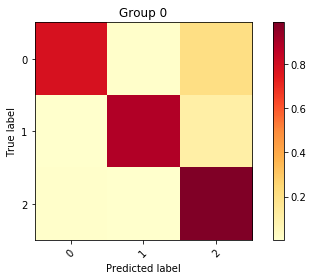

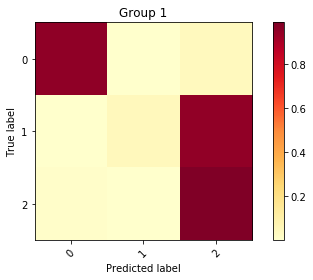

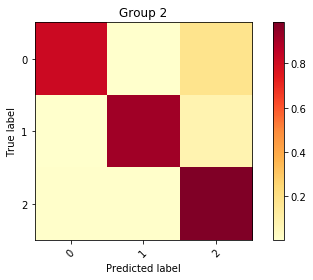

Inertia: 0.10471402656791422
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.253376 |     25 |  0.331427 |    0.886099 |  0.125383 |           0.939063 |   0.637363 |     0.637363 |
|  1 |        1 | 0.45166  |     45 |  0.156754 |    0.663371 |  1.03637  |           0.703355 |   0.557998 |     0.557998 |
|  2 |        2 | 0.294964 |     29 |  0.296776 |    0.905522 |  0.102324 |           0.950021 |   0.680098 |     0.680098 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F

In [24]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


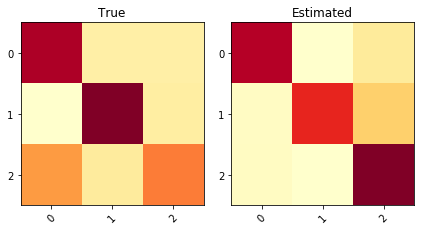

KL divergence: 0.4605	Pearson Correlation between diagonals: -0.9047


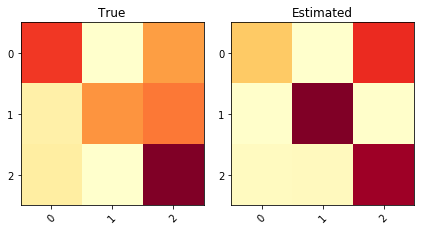

KL divergence: 0.6522	Pearson Correlation between diagonals: 0.0443


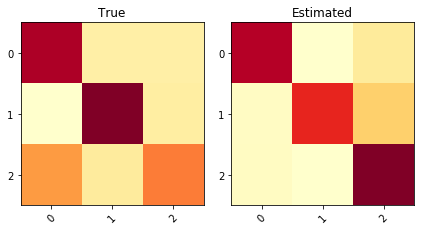

KL divergence: 0.4605	Pearson Correlation between diagonals: -0.9047


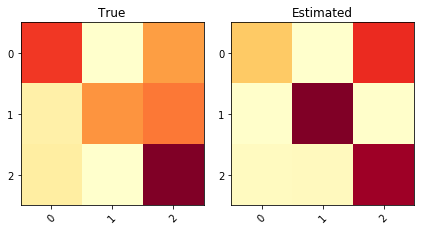

KL divergence: 0.6522	Pearson Correlation between diagonals: 0.0443


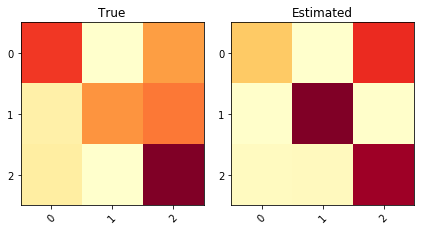

KL divergence: 0.6521	Pearson Correlation between diagonals: 0.0443


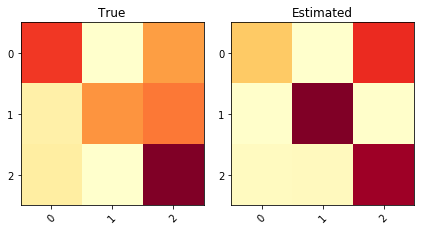

KL divergence: 0.6522	Pearson Correlation between diagonals: 0.0443


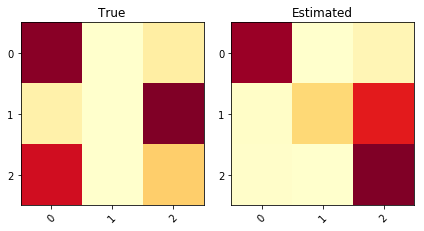

KL divergence: 1.0778	Pearson Correlation between diagonals: 0.6748


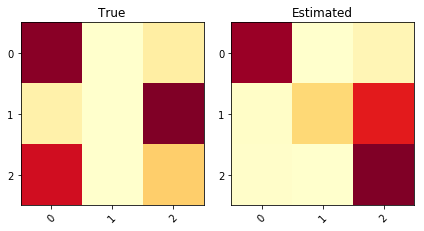

KL divergence: 1.0778	Pearson Correlation between diagonals: 0.6748


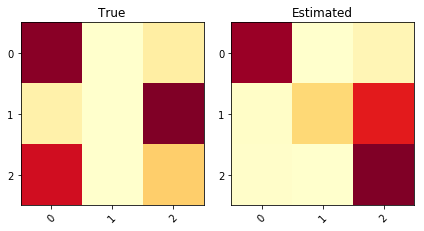

KL divergence: 1.0778	Pearson Correlation between diagonals: 0.6748


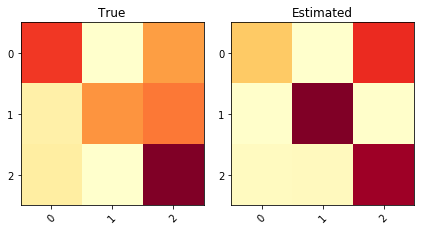

KL divergence: 0.6522	Pearson Correlation between diagonals: 0.0443


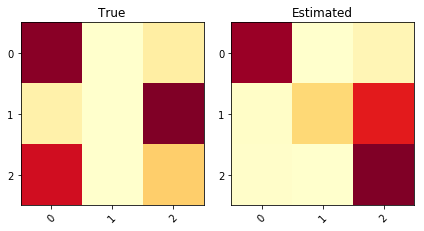

KL divergence: 1.0778	Pearson Correlation between diagonals: 0.6748


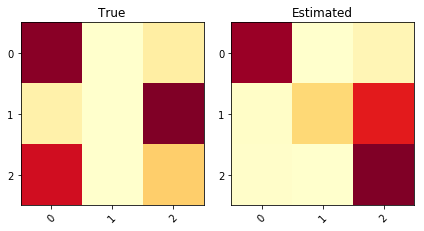

KL divergence: 1.0778	Pearson Correlation between diagonals: 0.6748


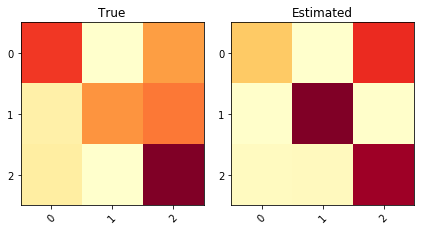

KL divergence: 0.6522	Pearson Correlation between diagonals: 0.0443


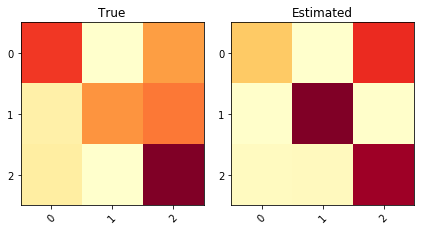

KL divergence: 0.6522	Pearson Correlation between diagonals: 0.0443


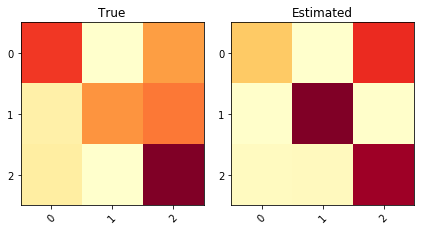

KL divergence: 0.6522	Pearson Correlation between diagonals: 0.0443
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.571022 |     0.571022 |     0.833228 |              0.281046 |       0.250381 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.677146 |               0.666102 |
+----+-------------------------+------------------------+
Test


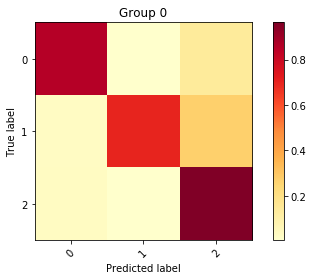

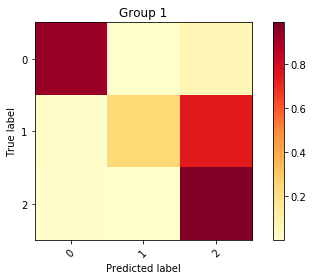

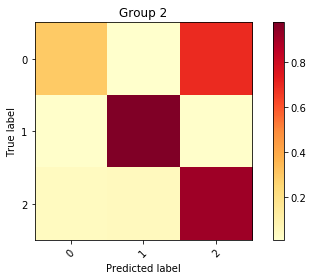

Inertia: 0.1113893873989582
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.201099 |     20 |  0.439294 |    0.839738 |  0.18338  |           0.911991 |   0.538462 |     0.538462 |
|  1 |        1 | 0.55179  |     55 |  0.316305 |    0.723274 |  0.491541 |           0.802999 |   0.440781 |     0.440781 |
|  2 |        2 | 0.247111 |     24 |  0.370807 |    0.730529 |  0.440262 |           0.816633 |   0.456654 |     0.456654 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1

In [25]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 3) configuration: normal soft ($T$ = 100, $T_{max}$ = 10, soft clustering )

In [57]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7566137566137566


*** Soft-Majority (Train with softMV) ***
Train


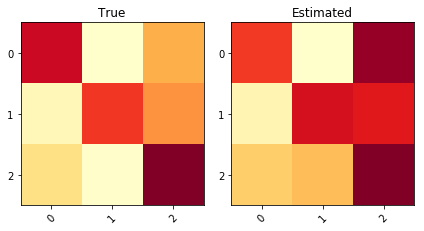

KL divergence: 0.1282	Pearson Correlation between diagonals: 0.6535


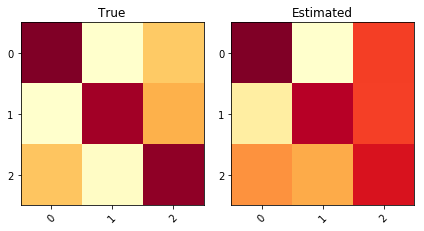

KL divergence: 0.1085	Pearson Correlation between diagonals: 0.5067


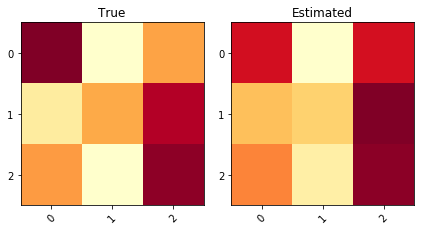

KL divergence: 0.0905	Pearson Correlation between diagonals: 0.9609


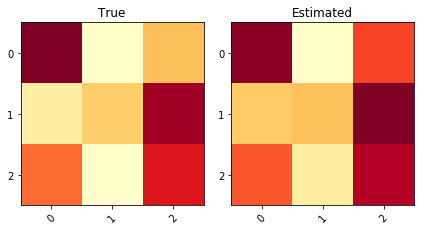

KL divergence: 0.0701	Pearson Correlation between diagonals: 0.9788


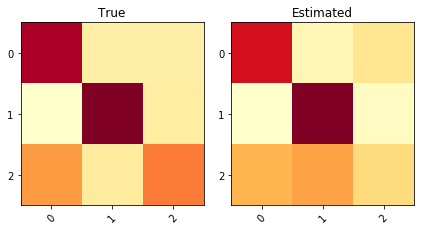

KL divergence: 0.1522	Pearson Correlation between diagonals: 0.9976


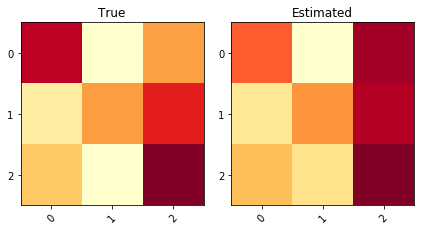

KL divergence: 0.1154	Pearson Correlation between diagonals: 0.8290


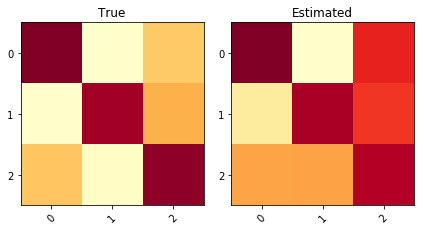

KL divergence: 0.1065	Pearson Correlation between diagonals: 0.7186


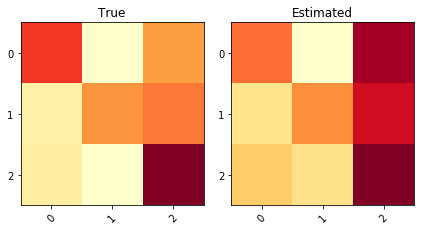

KL divergence: 0.1340	Pearson Correlation between diagonals: 0.9637


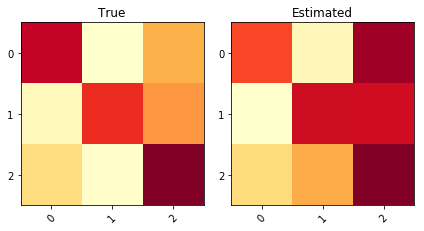

KL divergence: 0.1372	Pearson Correlation between diagonals: 0.5179


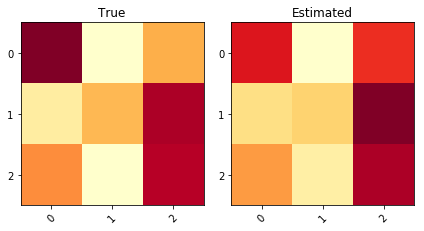

KL divergence: 0.0721	Pearson Correlation between diagonals: 0.9327


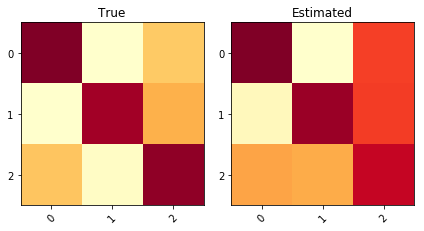

KL divergence: 0.0909	Pearson Correlation between diagonals: 0.3380


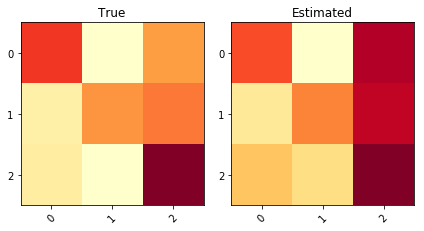

KL divergence: 0.1237	Pearson Correlation between diagonals: 0.9851


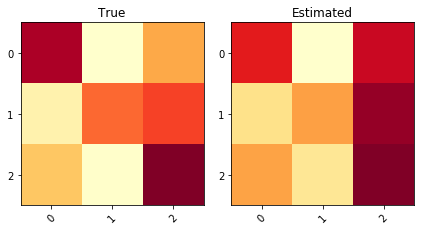

KL divergence: 0.0889	Pearson Correlation between diagonals: 0.9671


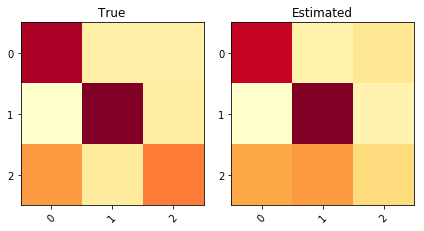

KL divergence: 0.1458	Pearson Correlation between diagonals: 1.0000


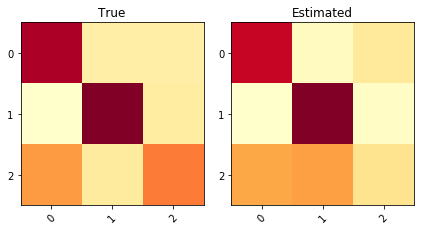

KL divergence: 0.1458	Pearson Correlation between diagonals: 0.9999
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.670737 |     0.670737 |    0.0990895 |              0.825365 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.676435 |     0.676435 |
+----+--------+------------+--------------+


In [58]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


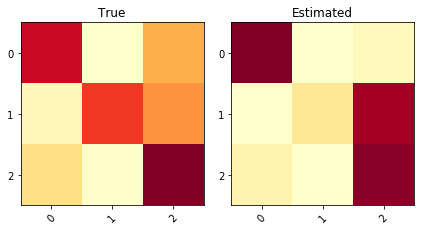

KL divergence: 0.3816	Pearson Correlation between diagonals: 0.8350


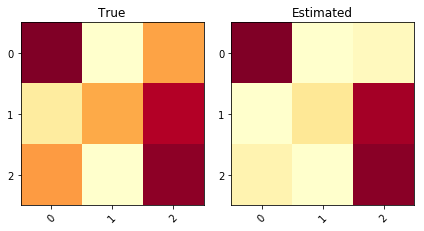

KL divergence: 0.1288	Pearson Correlation between diagonals: 0.9998


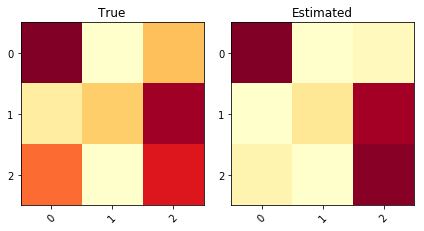

KL divergence: 0.1495	Pearson Correlation between diagonals: 0.9551


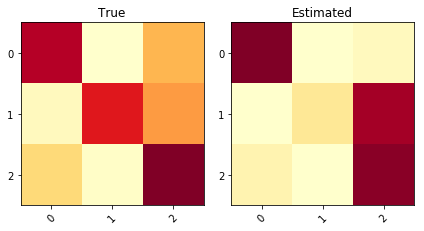

KL divergence: 0.4644	Pearson Correlation between diagonals: 0.8770


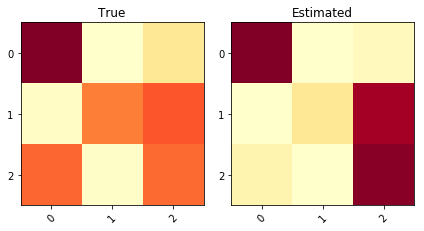

KL divergence: 0.5245	Pearson Correlation between diagonals: 0.5813


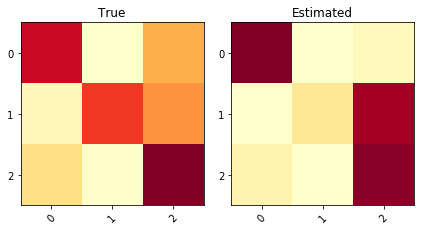

KL divergence: 0.3816	Pearson Correlation between diagonals: 0.8350


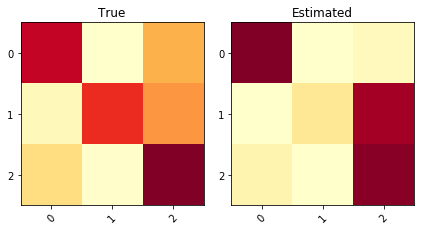

KL divergence: 0.4163	Pearson Correlation between diagonals: 0.8501


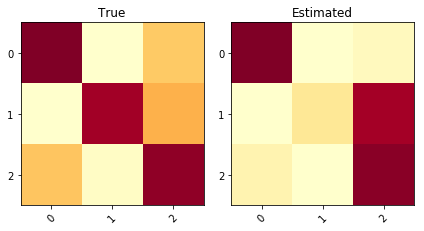

KL divergence: 0.6479	Pearson Correlation between diagonals: 0.8921


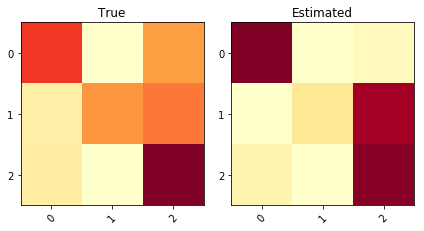

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7823


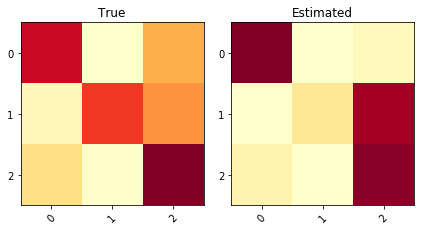

KL divergence: 0.3816	Pearson Correlation between diagonals: 0.8350


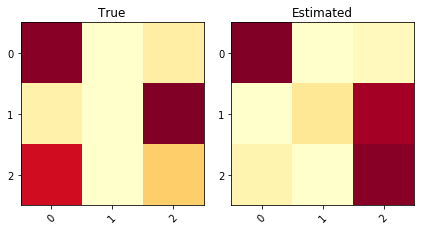

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7379


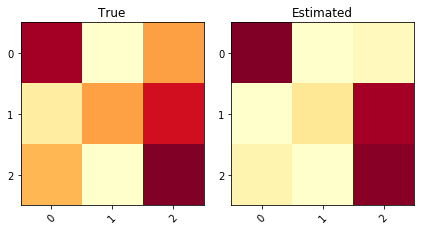

KL divergence: 0.1295	Pearson Correlation between diagonals: 0.9892


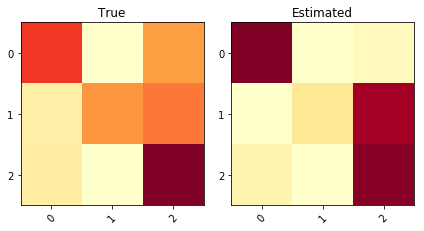

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7823


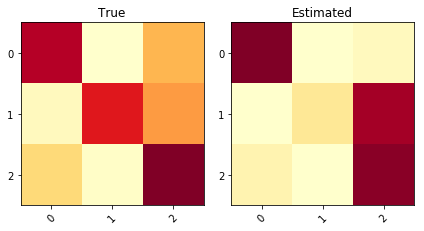

KL divergence: 0.4644	Pearson Correlation between diagonals: 0.8770


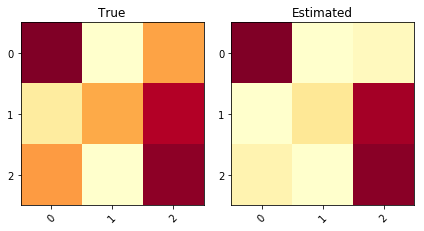

KL divergence: 0.1288	Pearson Correlation between diagonals: 0.9998
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.670737 |     0.670737 |     0.423141 |              0.710199 |
+----+--------+------------+--------------+--------------+-----------------------+


In [59]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


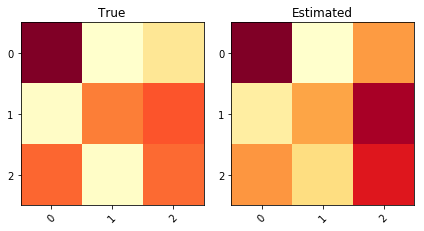

KL divergence: 0.0832	Pearson Correlation between diagonals: 0.8469


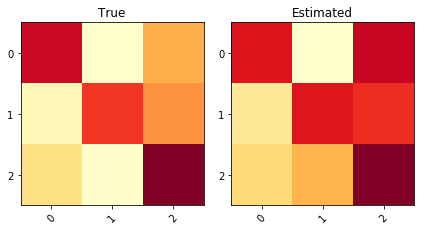

KL divergence: 0.1027	Pearson Correlation between diagonals: 0.8901


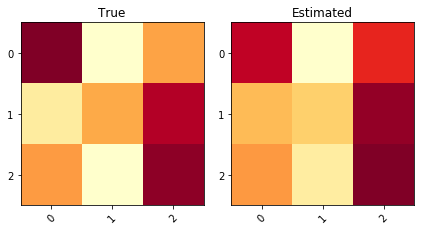

KL divergence: 0.0789	Pearson Correlation between diagonals: 0.9746


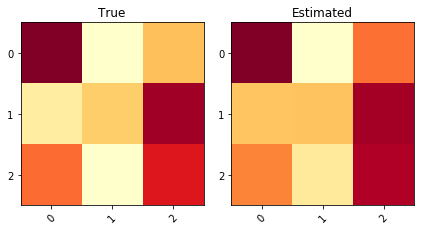

KL divergence: 0.0637	Pearson Correlation between diagonals: 0.9837


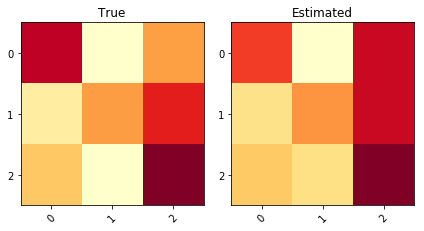

KL divergence: 0.0916	Pearson Correlation between diagonals: 0.9018


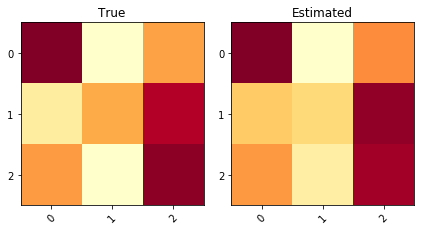

KL divergence: 0.0551	Pearson Correlation between diagonals: 0.9990


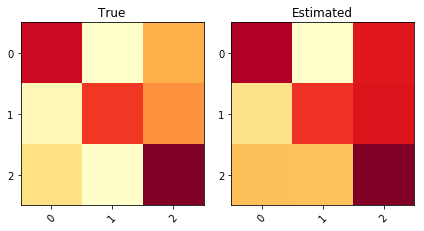

KL divergence: 0.0828	Pearson Correlation between diagonals: 0.9734


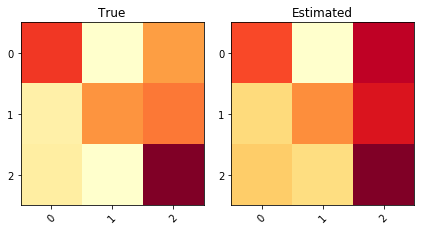

KL divergence: 0.1058	Pearson Correlation between diagonals: 0.9930


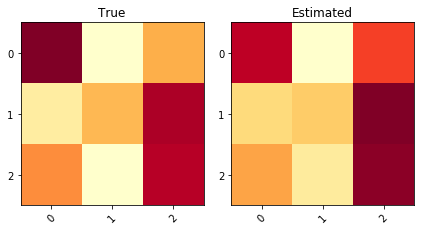

KL divergence: 0.0604	Pearson Correlation between diagonals: 0.9526


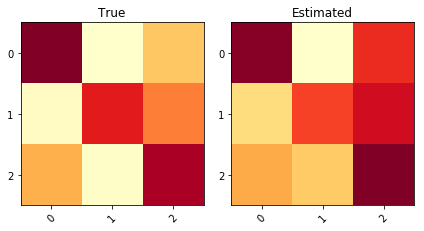

KL divergence: 0.0851	Pearson Correlation between diagonals: 0.9195


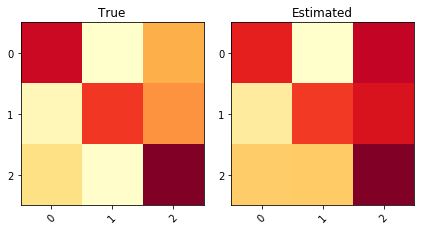

KL divergence: 0.0906	Pearson Correlation between diagonals: 0.9531


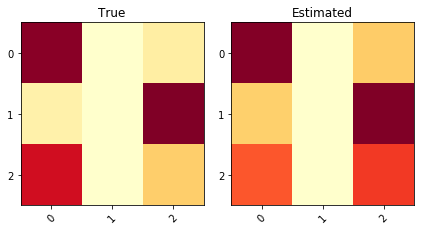

KL divergence: 0.0871	Pearson Correlation between diagonals: 0.9028


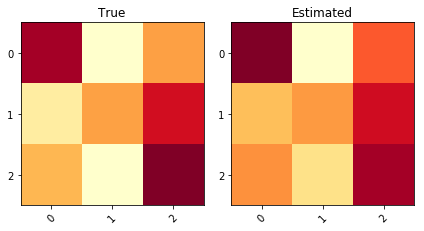

KL divergence: 0.0750	Pearson Correlation between diagonals: 0.9678


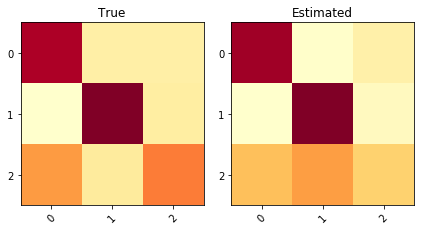

KL divergence: 0.1238	Pearson Correlation between diagonals: 0.9939


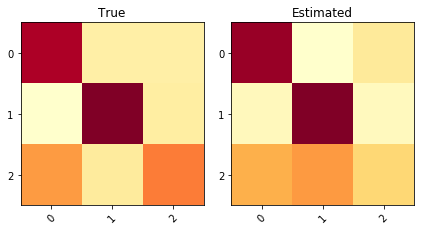

KL divergence: 0.1259	Pearson Correlation between diagonals: 0.9914
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.773708 |     0.773708 |     0.081633 |              0.901475 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.765568 |     0.765568 |
+----+--------+------------+--------------+


In [60]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


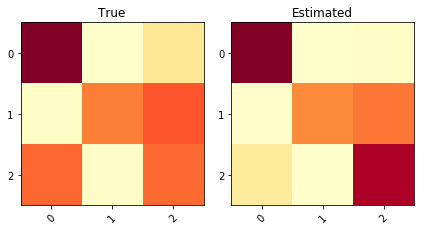

KL divergence: 0.3991	Pearson Correlation between diagonals: 0.7003


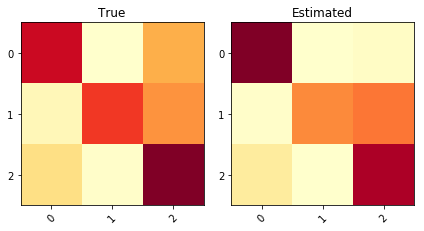

KL divergence: 0.3539	Pearson Correlation between diagonals: 0.7397


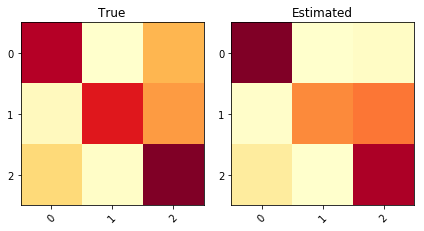

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.7920


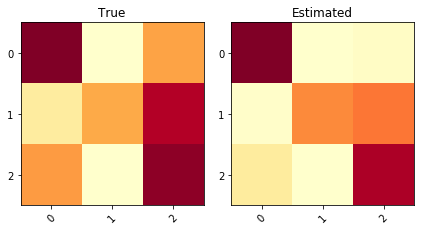

KL divergence: 0.2640	Pearson Correlation between diagonals: 0.9910


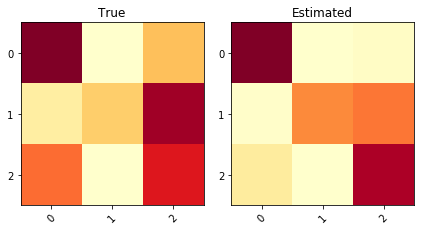

KL divergence: 0.2847	Pearson Correlation between diagonals: 0.9895


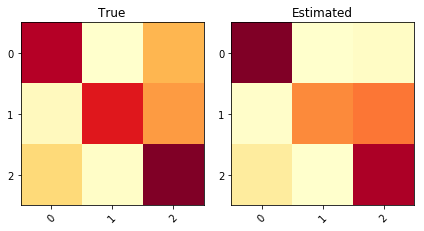

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.7920


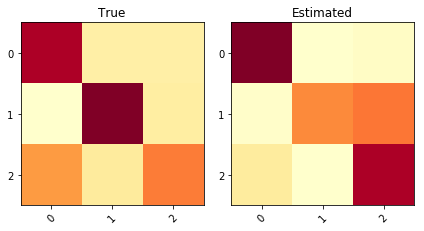

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.5144


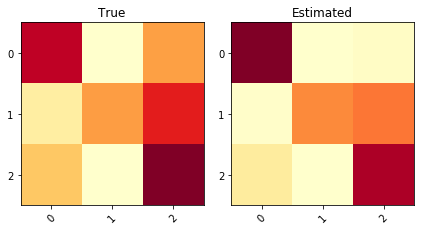

KL divergence: 0.2688	Pearson Correlation between diagonals: 0.9175


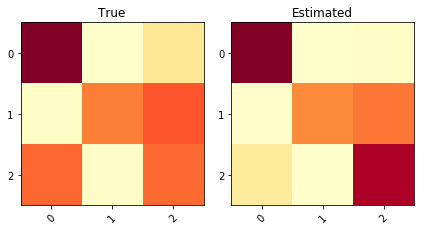

KL divergence: 0.3991	Pearson Correlation between diagonals: 0.7003


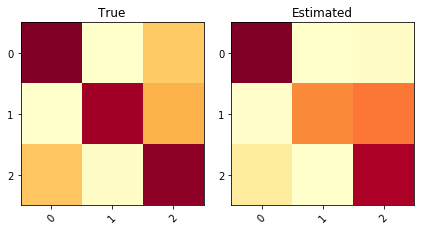

KL divergence: 0.4573	Pearson Correlation between diagonals: 0.9513


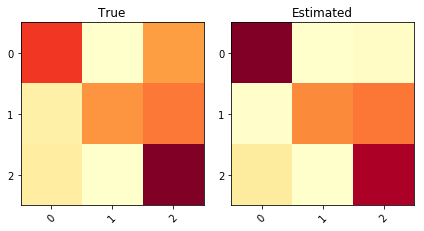

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.6764


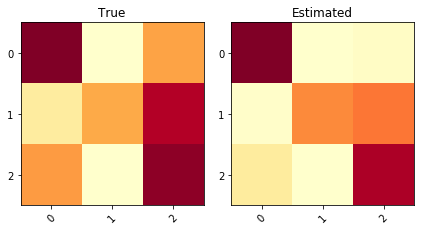

KL divergence: 0.2640	Pearson Correlation between diagonals: 0.9910


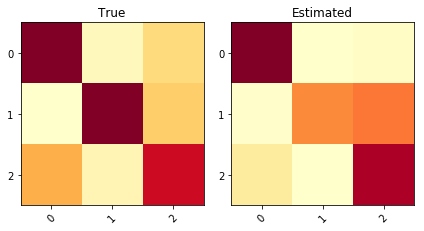

KL divergence: 0.5552	Pearson Correlation between diagonals: -0.3118


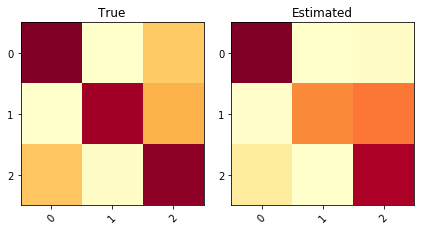

KL divergence: 0.4573	Pearson Correlation between diagonals: 0.9513


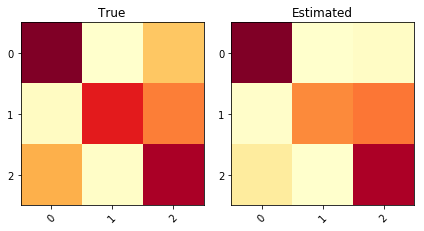

KL divergence: 0.3767	Pearson Correlation between diagonals: 0.9837
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.773708 |     0.773708 |     0.388119 |              0.731978 |
+----+--------+------------+--------------+--------------+-----------------------+


In [61]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


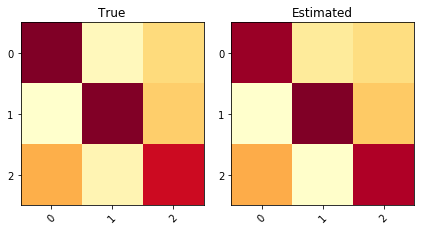

KL divergence: 0.1780	Pearson Correlation between diagonals: 0.8210


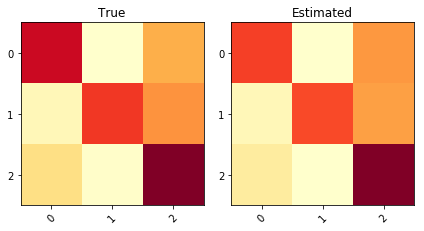

KL divergence: 0.0098	Pearson Correlation between diagonals: 0.9113


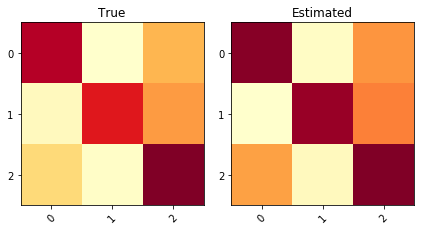

KL divergence: 0.0174	Pearson Correlation between diagonals: 0.9875


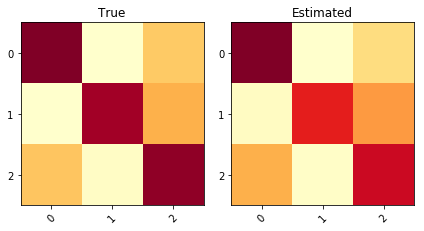

KL divergence: 0.0123	Pearson Correlation between diagonals: 0.9768


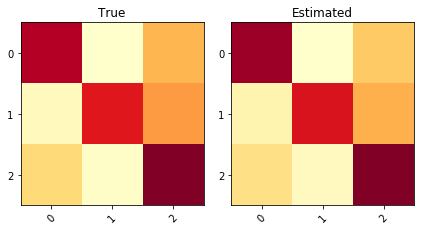

KL divergence: 0.0064	Pearson Correlation between diagonals: 0.9766


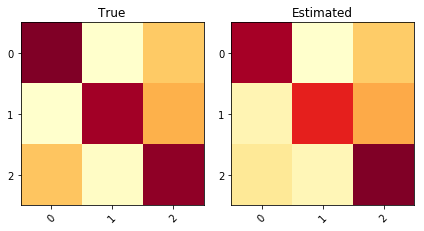

KL divergence: 0.0227	Pearson Correlation between diagonals: 0.7005


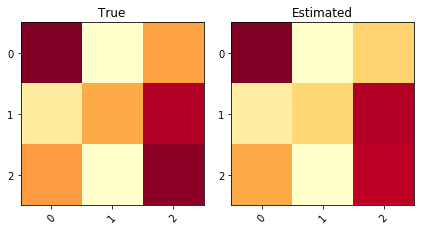

KL divergence: 0.0138	Pearson Correlation between diagonals: 0.9926


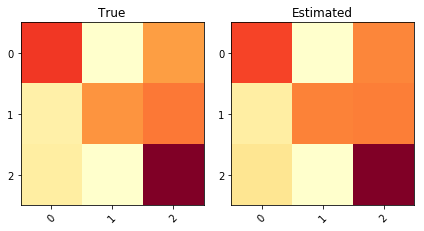

KL divergence: 0.0042	Pearson Correlation between diagonals: 0.9913


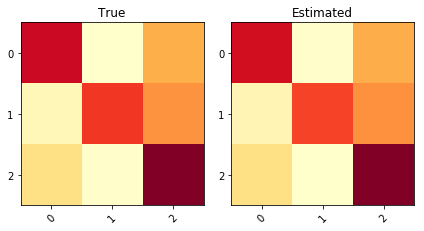

KL divergence: 0.0029	Pearson Correlation between diagonals: 0.9998


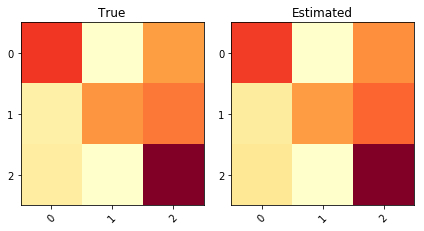

KL divergence: 0.0034	Pearson Correlation between diagonals: 1.0000


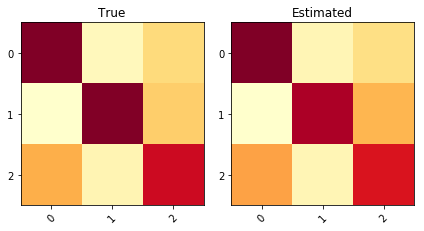

KL divergence: 0.0062	Pearson Correlation between diagonals: 0.9207


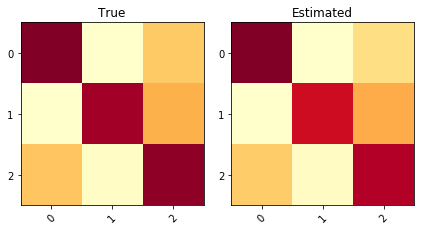

KL divergence: 0.0272	Pearson Correlation between diagonals: 0.9926


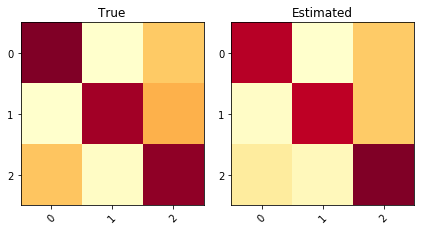

KL divergence: 0.0193	Pearson Correlation between diagonals: 0.1409


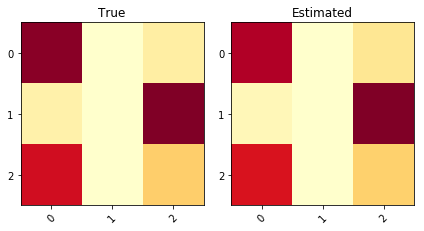

KL divergence: 0.0058	Pearson Correlation between diagonals: 0.9998


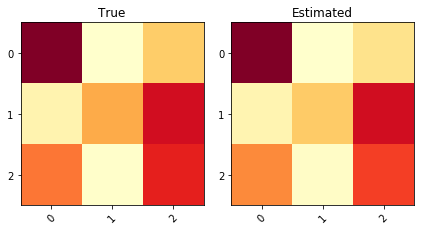

KL divergence: 0.0083	Pearson Correlation between diagonals: 0.9989
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.936508 |     0.936508 |    0.0237701 |              0.929587 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.953602 |     0.953602 |
+----+--------+------------+--------------+


In [62]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


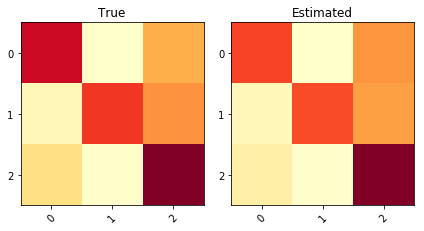

KL divergence: 0.0148	Pearson Correlation between diagonals: 0.9000


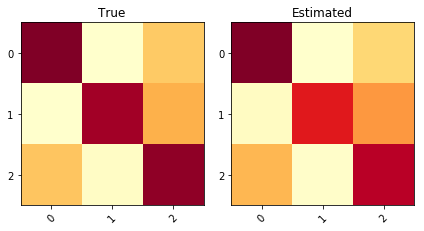

KL divergence: 0.0078	Pearson Correlation between diagonals: 0.9997


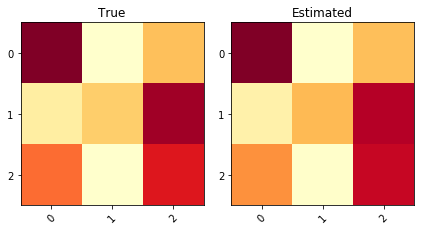

KL divergence: 0.0127	Pearson Correlation between diagonals: 0.9962


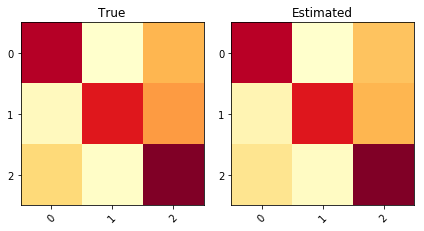

KL divergence: 0.0075	Pearson Correlation between diagonals: 0.9981


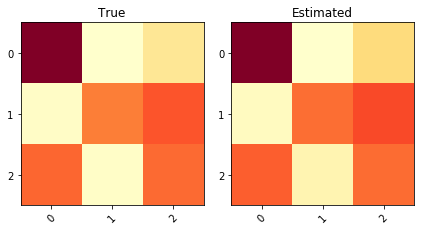

KL divergence: 0.0090	Pearson Correlation between diagonals: 0.9974


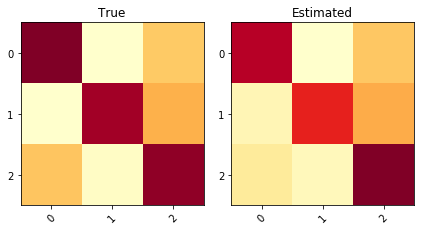

KL divergence: 0.0214	Pearson Correlation between diagonals: 0.5907


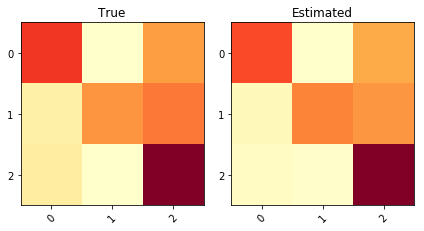

KL divergence: 0.0285	Pearson Correlation between diagonals: 0.9875


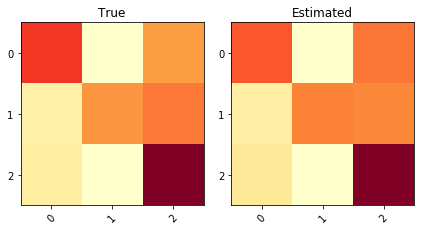

KL divergence: 0.0154	Pearson Correlation between diagonals: 0.9733


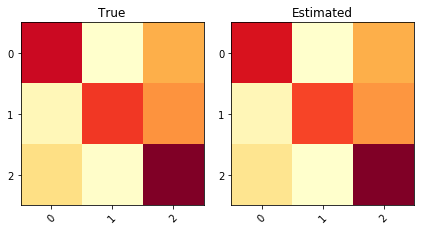

KL divergence: 0.0009	Pearson Correlation between diagonals: 0.9955


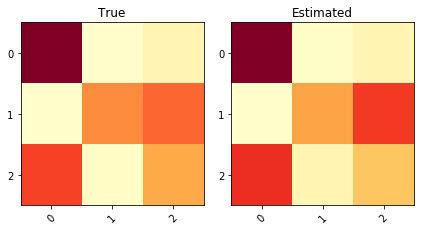

KL divergence: 0.0104	Pearson Correlation between diagonals: 0.9999


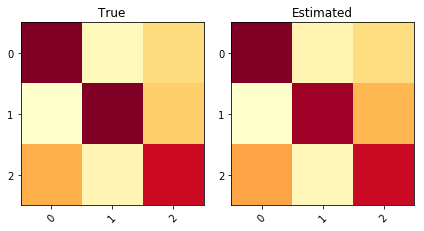

KL divergence: 0.0041	Pearson Correlation between diagonals: 0.9338


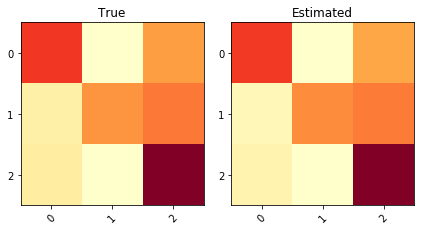

KL divergence: 0.0109	Pearson Correlation between diagonals: 0.9992


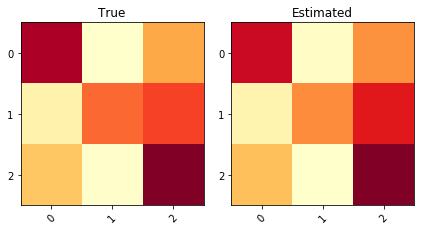

KL divergence: 0.0081	Pearson Correlation between diagonals: 0.9911


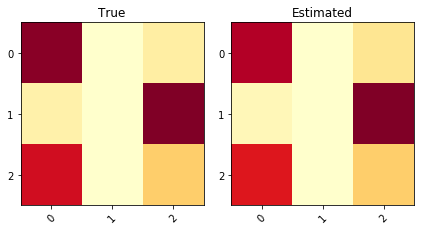

KL divergence: 0.0175	Pearson Correlation between diagonals: 0.9995


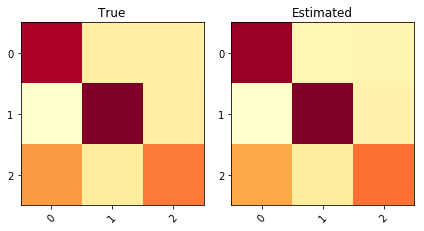

KL divergence: 0.0068	Pearson Correlation between diagonals: 0.9971
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.897436 |     0.897436 |    0.0132945 |              0.918457 |      0.0835597 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.620843 |               0.830982 |
+----+-------------------------+------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+----

In [63]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


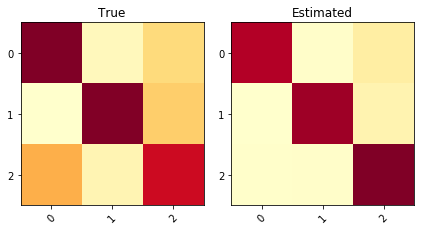

KL divergence: 0.3829	Pearson Correlation between diagonals: -0.9308


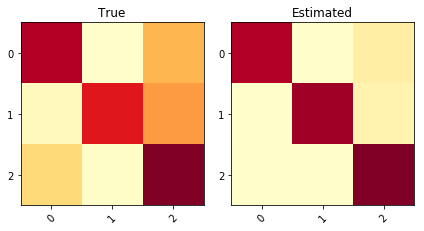

KL divergence: 0.3464	Pearson Correlation between diagonals: 0.5744


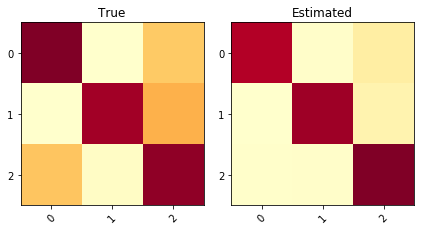

KL divergence: 0.3525	Pearson Correlation between diagonals: -0.3482


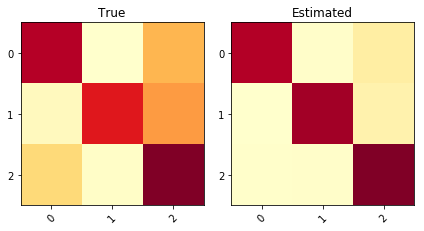

KL divergence: 0.3363	Pearson Correlation between diagonals: 0.6203


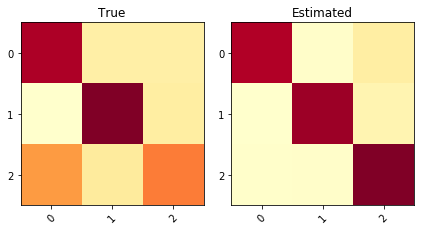

KL divergence: 0.5232	Pearson Correlation between diagonals: -0.8020


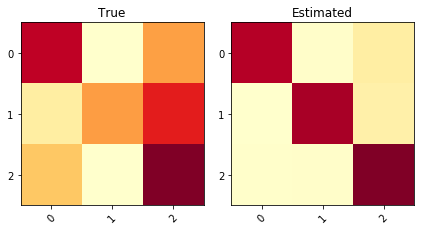

KL divergence: 0.5520	Pearson Correlation between diagonals: 0.5131


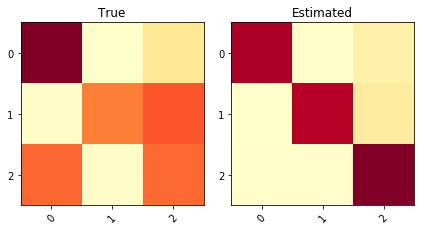

KL divergence: 0.6883	Pearson Correlation between diagonals: -0.2755


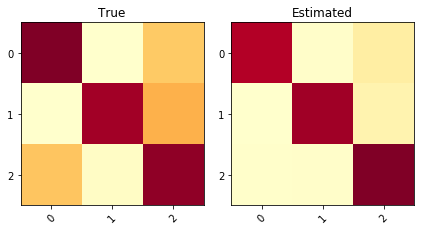

KL divergence: 0.3488	Pearson Correlation between diagonals: -0.3275


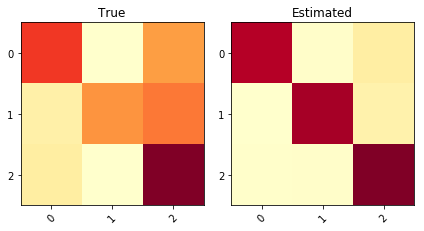

KL divergence: 0.3944	Pearson Correlation between diagonals: 0.7722


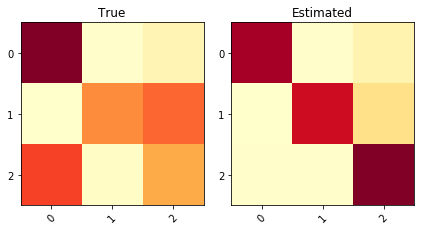

KL divergence: 0.7464	Pearson Correlation between diagonals: -0.0813


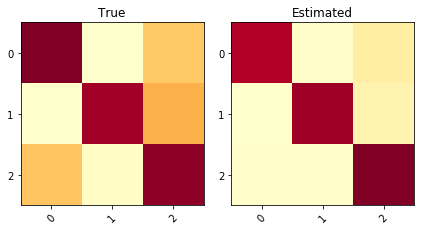

KL divergence: 0.3536	Pearson Correlation between diagonals: -0.3548


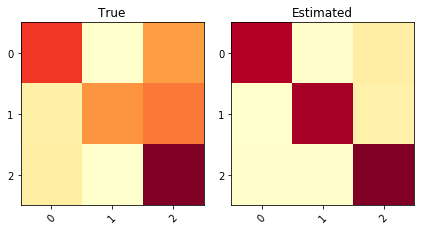

KL divergence: 0.3939	Pearson Correlation between diagonals: 0.7764


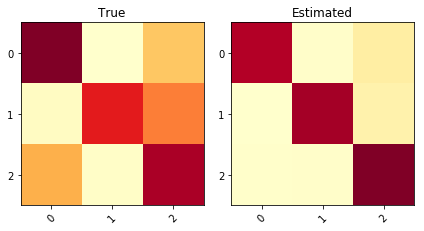

KL divergence: 0.4436	Pearson Correlation between diagonals: -0.1112


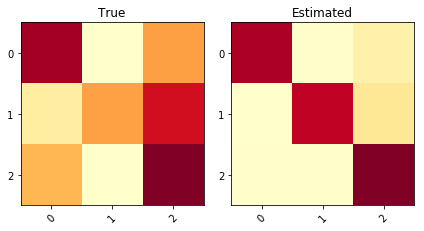

KL divergence: 0.5205	Pearson Correlation between diagonals: 0.8415


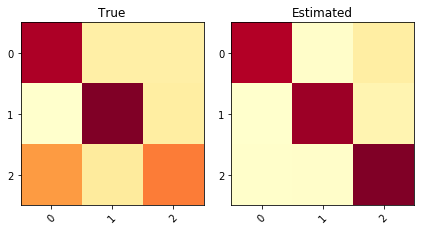

KL divergence: 0.5228	Pearson Correlation between diagonals: -0.8049
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.793651 |     0.793651 |     0.550773 |               0.24783 |      0.0969659 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.608183 |               0.797976 |
+----+-------------------------+------------------------+
Test


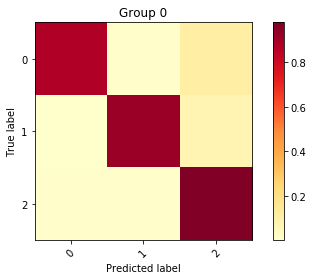

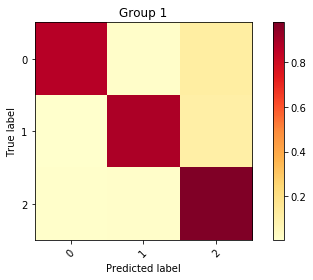

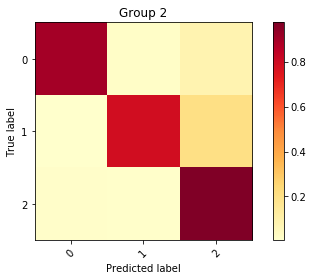

Inertia: 0.0036847321898676455
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.4256   |     42 |  0.275851 |    0.924487 | 0.0795264 |           0.960825 |   0.680098 |     0.680098 |
|  1 |        1 | 0.306747 |     30 |  0.314293 |    0.90914  | 0.0966741 |           0.952521 |   0.661783 |     0.661783 |
|  2 |        2 | 0.267653 |     26 |  0.347367 |    0.888437 | 0.12203   |           0.94058  |   0.648352 |     0.648352 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |  

In [64]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


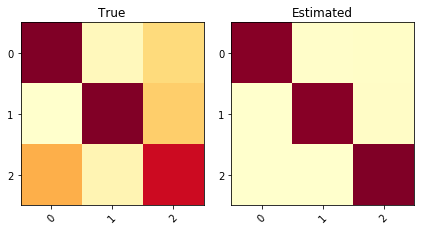

KL divergence: 0.7525	Pearson Correlation between diagonals: -0.9951


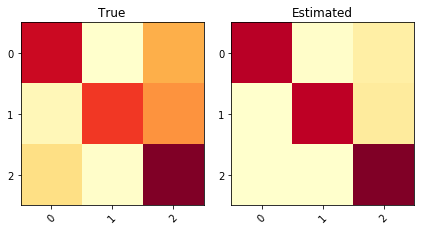

KL divergence: 0.3599	Pearson Correlation between diagonals: 0.9234


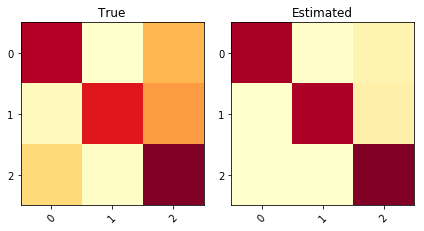

KL divergence: 0.4319	Pearson Correlation between diagonals: 0.8829


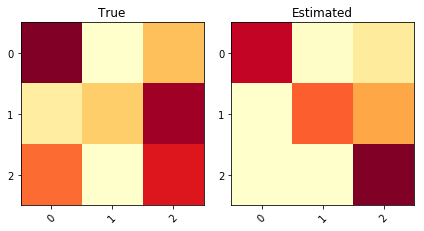

KL divergence: 0.6752	Pearson Correlation between diagonals: 0.7731


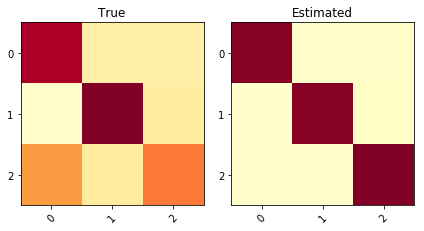

KL divergence: 0.8190	Pearson Correlation between diagonals: -0.9474


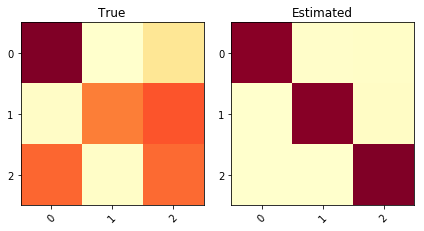

KL divergence: 1.3171	Pearson Correlation between diagonals: -0.5315


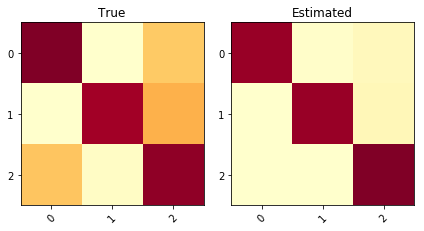

KL divergence: 0.5628	Pearson Correlation between diagonals: 0.0732


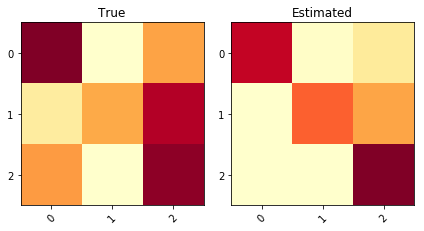

KL divergence: 0.4898	Pearson Correlation between diagonals: 0.9192


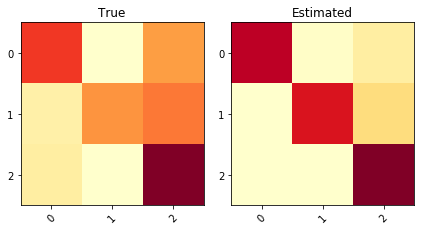

KL divergence: 0.3023	Pearson Correlation between diagonals: 0.9995


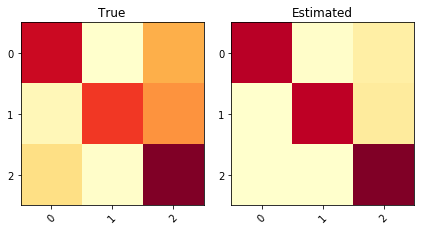

KL divergence: 0.3608	Pearson Correlation between diagonals: 0.9240


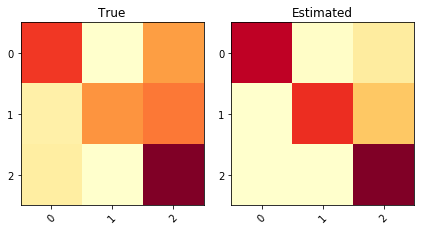

KL divergence: 0.2581	Pearson Correlation between diagonals: 0.9840


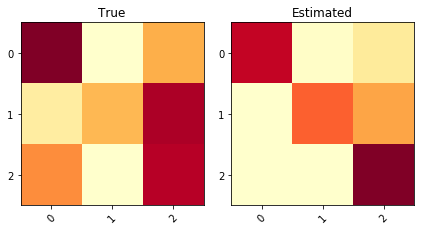

KL divergence: 0.5592	Pearson Correlation between diagonals: 0.8647


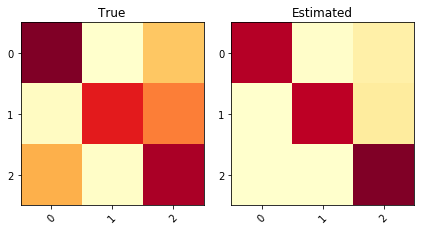

KL divergence: 0.5181	Pearson Correlation between diagonals: 0.2589


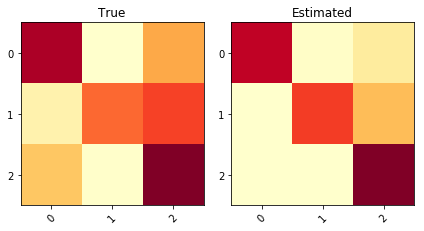

KL divergence: 0.3566	Pearson Correlation between diagonals: 0.9743


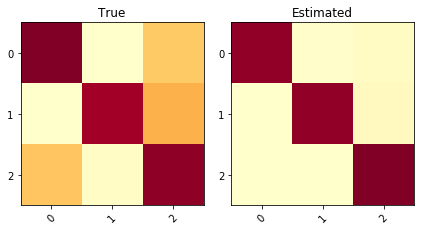

KL divergence: 0.6294	Pearson Correlation between diagonals: 0.0349
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.859178 |     0.859178 |     0.699688 |              0.343008 |      0.0737531 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                 0.62612 |               0.788473 |
+----+-------------------------+------------------------+
Test


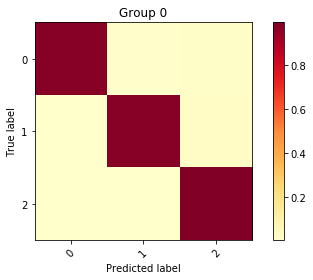

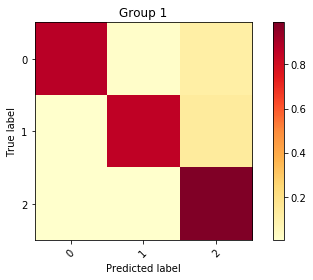

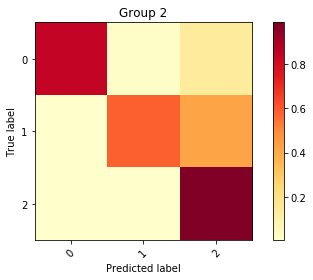

Inertia: 0.029789449802289408
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.438681 |     43 |  0.097495 |    0.981973 | 0.0182244 |           0.990916 |   0.852259 |     0.852259 |
|  1 |        1 | 0.302006 |     30 |  0.304314 |    0.906982 | 0.0996962 |           0.951142 |   0.691087 |     0.691087 |
|  2 |        2 | 0.259313 |     25 |  0.422173 |    0.803872 | 0.241957  |           0.886844 |   0.648352 |     0.648352 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   

In [65]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


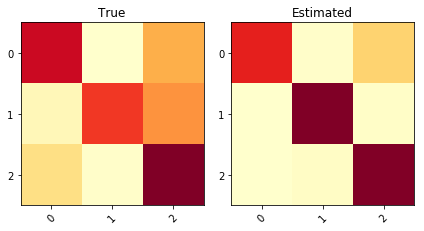

KL divergence: 0.4695	Pearson Correlation between diagonals: 0.0156


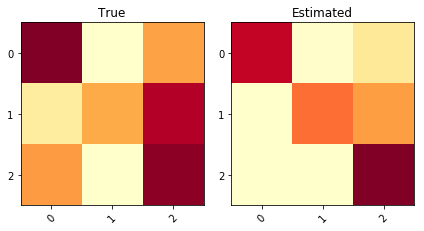

KL divergence: 0.4931	Pearson Correlation between diagonals: 0.9256


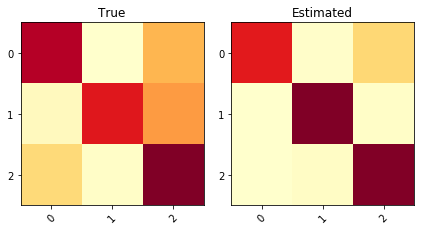

KL divergence: 0.4642	Pearson Correlation between diagonals: -0.0635


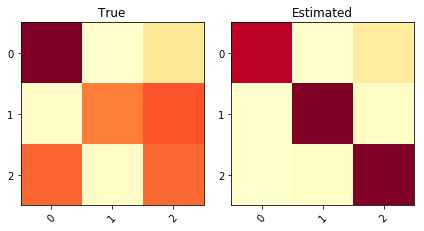

KL divergence: 1.2310	Pearson Correlation between diagonals: -0.9944


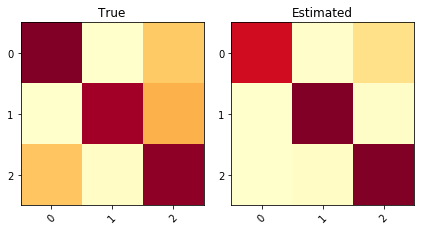

KL divergence: 0.5019	Pearson Correlation between diagonals: -0.8520


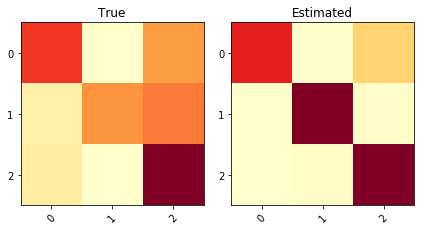

KL divergence: 0.5580	Pearson Correlation between diagonals: 0.1055


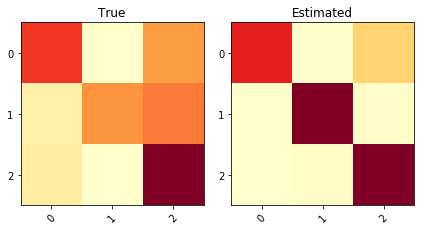

KL divergence: 0.5574	Pearson Correlation between diagonals: 0.1054


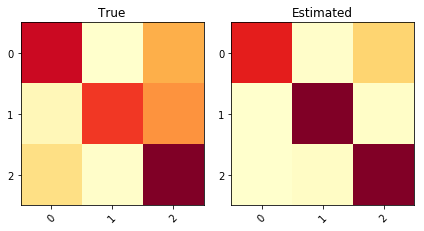

KL divergence: 0.4714	Pearson Correlation between diagonals: 0.0162


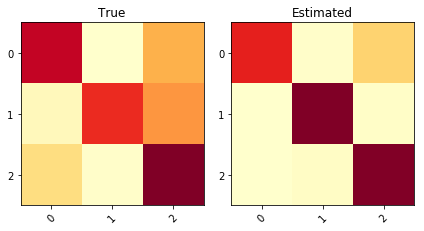

KL divergence: 0.4629	Pearson Correlation between diagonals: -0.0125


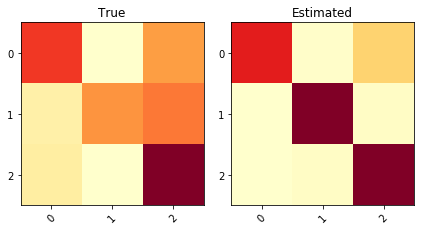

KL divergence: 0.5208	Pearson Correlation between diagonals: 0.1255


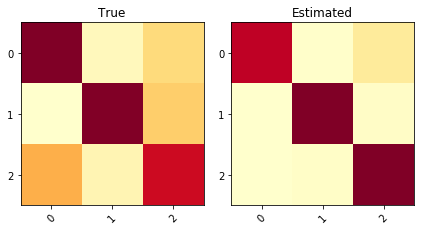

KL divergence: 0.5998	Pearson Correlation between diagonals: -0.5433


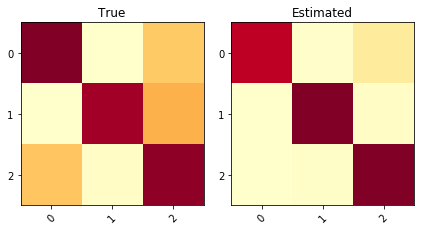

KL divergence: 0.5829	Pearson Correlation between diagonals: -0.8372


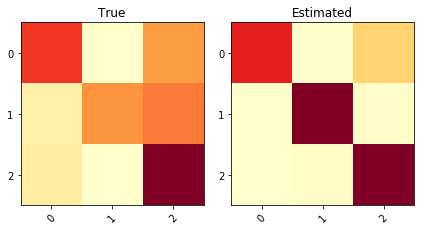

KL divergence: 0.5533	Pearson Correlation between diagonals: 0.1074


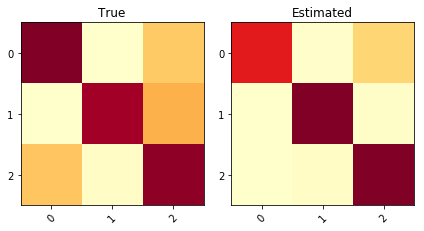

KL divergence: 0.4541	Pearson Correlation between diagonals: -0.8594


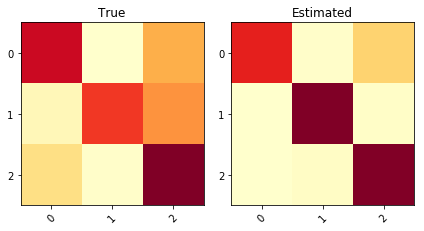

KL divergence: 0.4694	Pearson Correlation between diagonals: 0.0156
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |    0.86162 |      0.86162 |     0.705821 |            -0.0423825 |      0.0671347 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.631827 |               0.782051 |
+----+-------------------------+------------------------+
Test


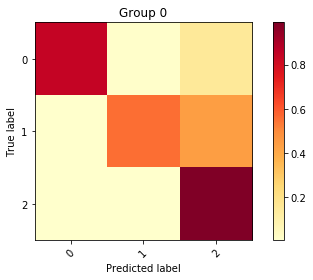

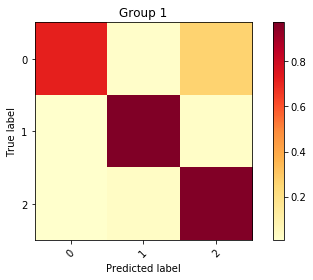

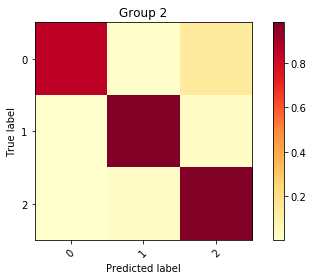

Inertia: 0.03664136018293599
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.327754 |     32 |  0.416209 |    0.796157 | 0.256175  |           0.880997 |   0.648352 |     0.648352 |
|  1 |        1 | 0.201822 |     20 |  0.323241 |    0.885415 | 0.13134   |           0.937001 |   0.854701 |     0.854701 |
|  2 |        2 | 0.470424 |     47 |  0.214521 |    0.940057 | 0.0637418 |           0.968693 |   0.870574 |     0.870574 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F

In [66]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 4) configuration: Manny annot v1 ($T$ = 2000, $T_{max}$ = 20 )

In [82]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7993487993487993


*** Soft-Majority (Train with softMV) ***
Train


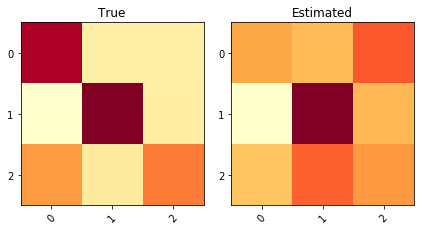

KL divergence: 0.3147	Pearson Correlation between diagonals: 0.5933


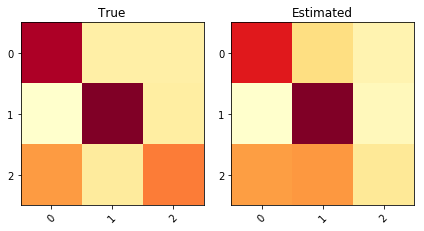

KL divergence: 0.1707	Pearson Correlation between diagonals: 0.9963


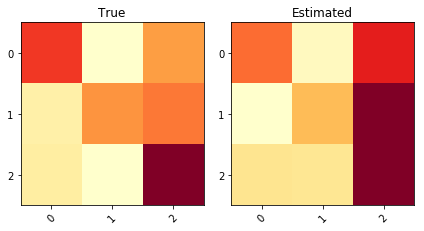

KL divergence: 0.1367	Pearson Correlation between diagonals: 0.9983


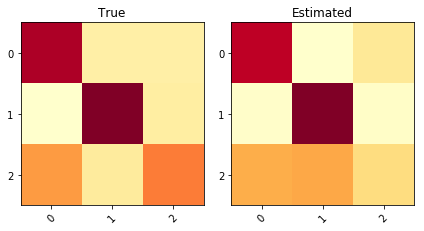

KL divergence: 0.1467	Pearson Correlation between diagonals: 0.9993


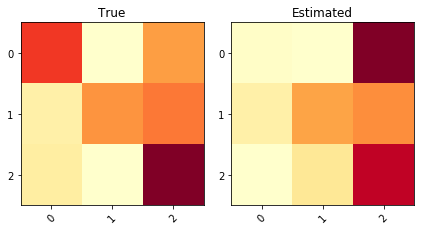

KL divergence: 0.3724	Pearson Correlation between diagonals: 0.6253


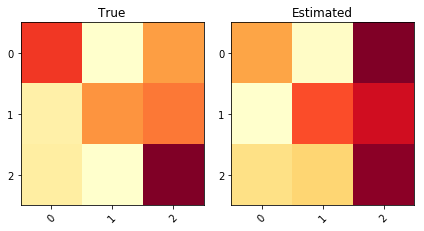

KL divergence: 0.1797	Pearson Correlation between diagonals: 0.7119


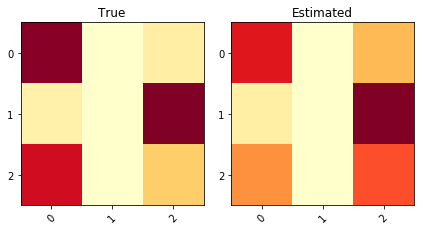

KL divergence: 0.1044	Pearson Correlation between diagonals: 0.8295


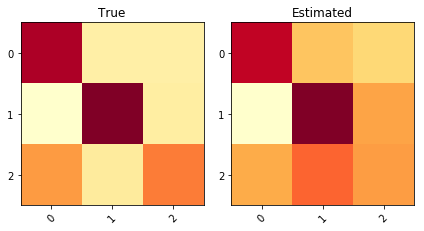

KL divergence: 0.1775	Pearson Correlation between diagonals: 0.9983


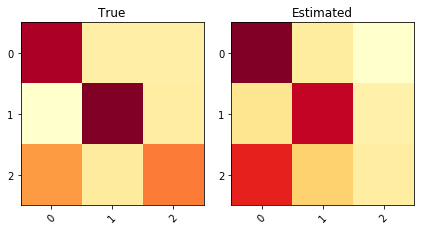

KL divergence: 0.1914	Pearson Correlation between diagonals: 0.9403


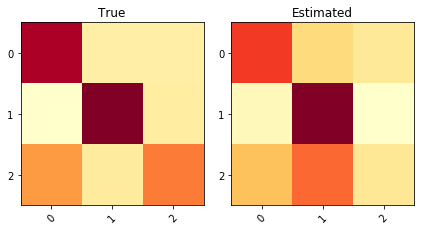

KL divergence: 0.2124	Pearson Correlation between diagonals: 0.9806


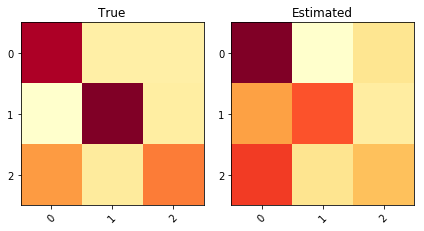

KL divergence: 0.2064	Pearson Correlation between diagonals: 0.6969


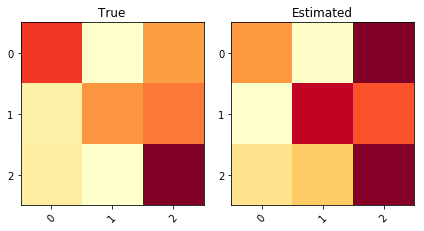

KL divergence: 0.1760	Pearson Correlation between diagonals: 0.3574


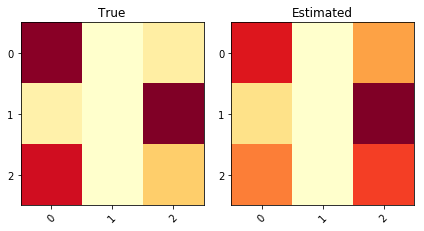

KL divergence: 0.1247	Pearson Correlation between diagonals: 0.8034


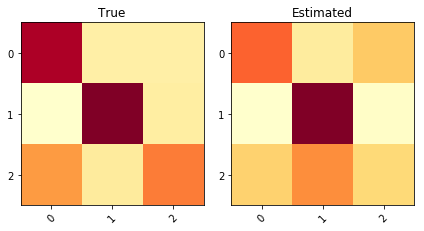

KL divergence: 0.1857	Pearson Correlation between diagonals: 0.9262


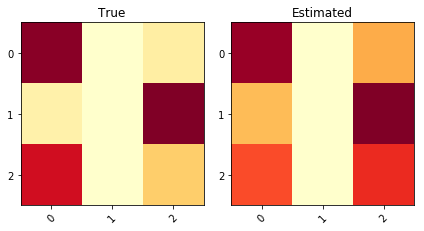

KL divergence: 0.1159	Pearson Correlation between diagonals: 0.8680
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.645096 |     0.645096 |     0.206272 |              0.810746 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.664225 |     0.664225 |
+----+--------+------------+--------------+


In [83]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


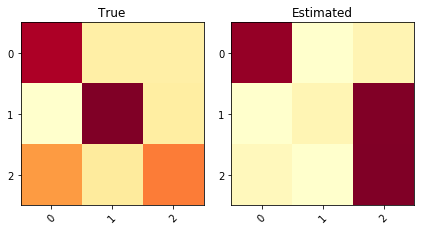

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6878


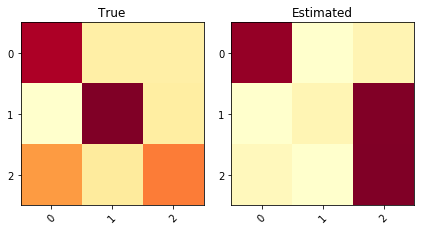

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6878


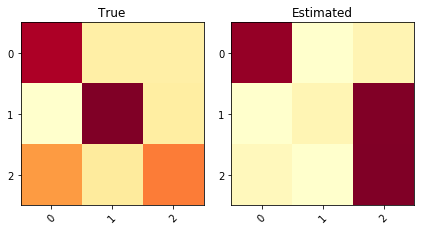

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6878


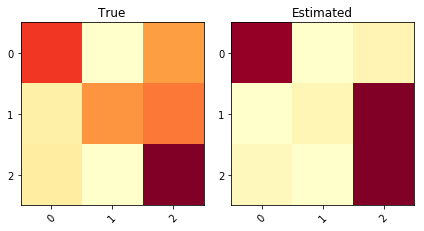

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8198


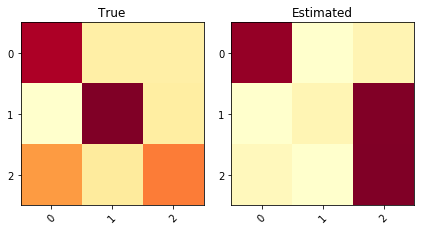

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6878


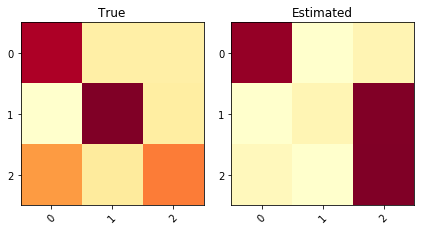

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6878


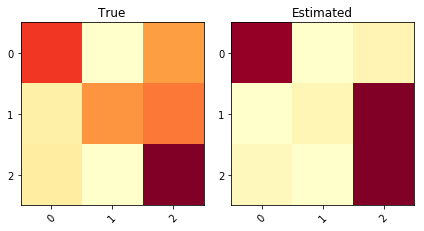

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8198


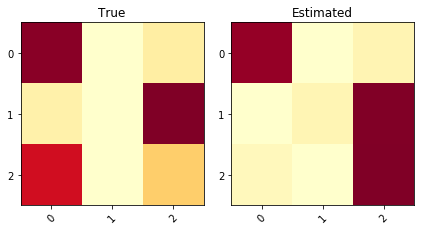

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.6941


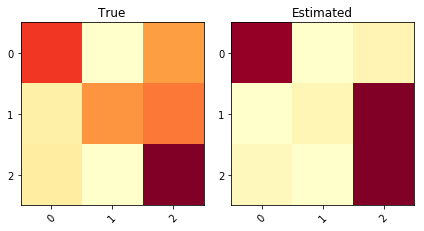

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8198


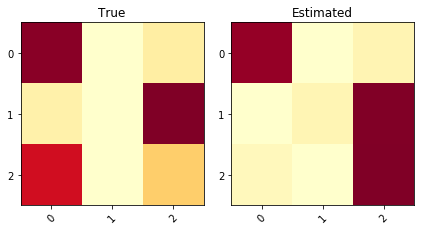

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.6941


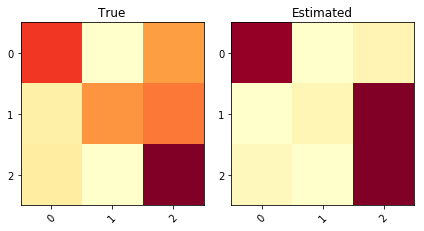

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8198


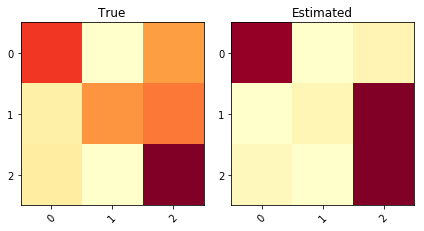

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8198


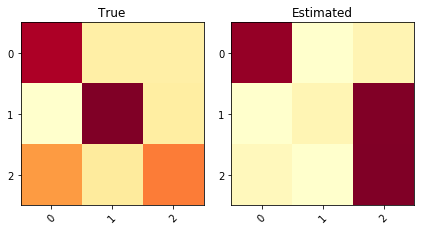

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6878


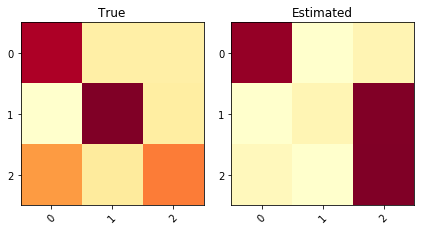

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6878


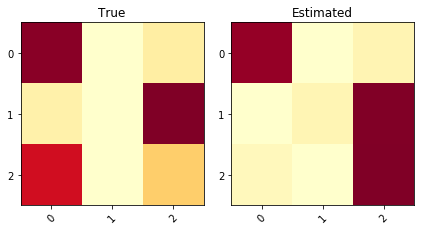

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.6941
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.645096 |     0.645096 |     0.492097 |              0.457903 |
+----+--------+------------+--------------+--------------+-----------------------+


In [84]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


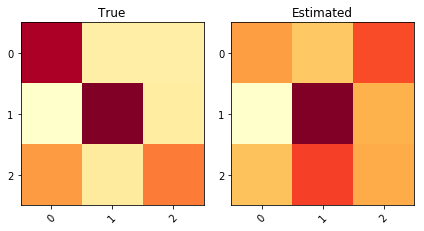

KL divergence: 0.3050	Pearson Correlation between diagonals: 0.7102


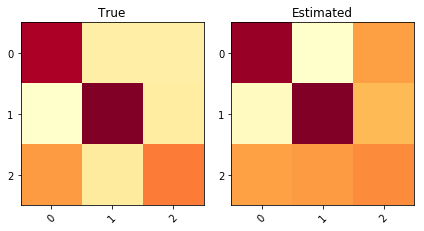

KL divergence: 0.1441	Pearson Correlation between diagonals: 0.9956


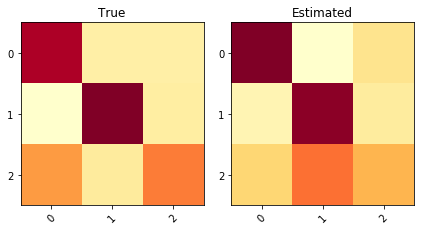

KL divergence: 0.1393	Pearson Correlation between diagonals: 0.9735


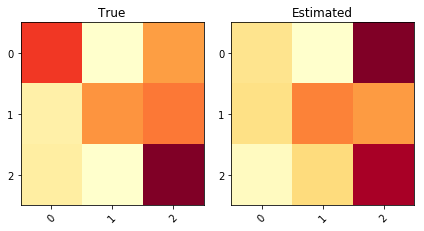

KL divergence: 0.2678	Pearson Correlation between diagonals: 0.6346


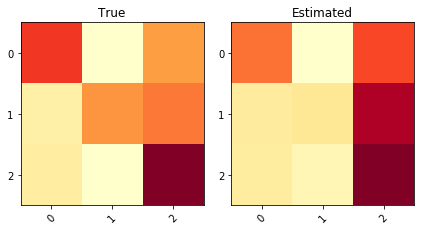

KL divergence: 0.1202	Pearson Correlation between diagonals: 0.9960


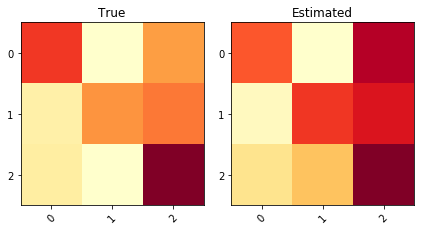

KL divergence: 0.1294	Pearson Correlation between diagonals: 0.8393


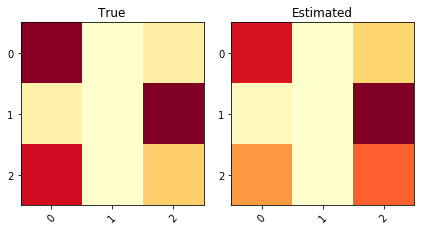

KL divergence: 0.0938	Pearson Correlation between diagonals: 0.8643


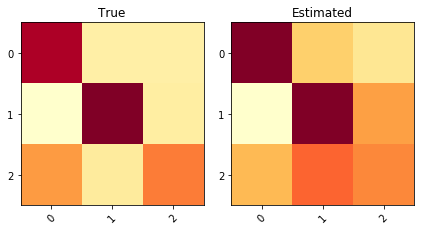

KL divergence: 0.1399	Pearson Correlation between diagonals: 0.9828


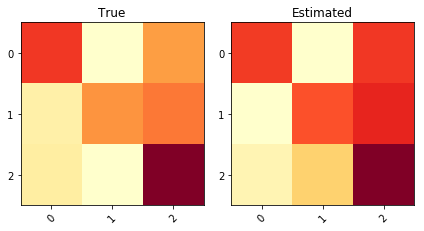

KL divergence: 0.1323	Pearson Correlation between diagonals: 0.9625


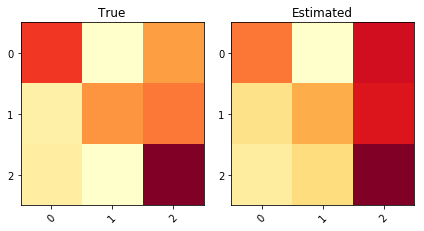

KL divergence: 0.1104	Pearson Correlation between diagonals: 0.9891


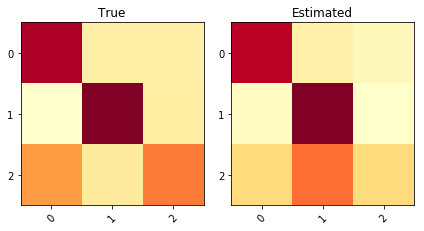

KL divergence: 0.1920	Pearson Correlation between diagonals: 0.9990


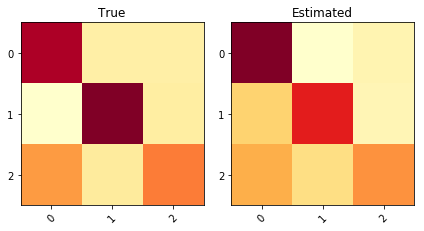

KL divergence: 0.1421	Pearson Correlation between diagonals: 0.7600


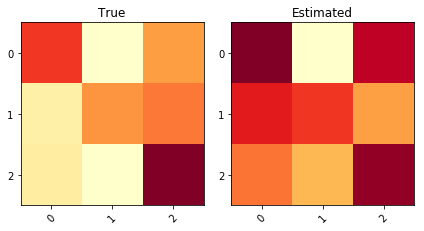

KL divergence: 0.2294	Pearson Correlation between diagonals: 0.7217


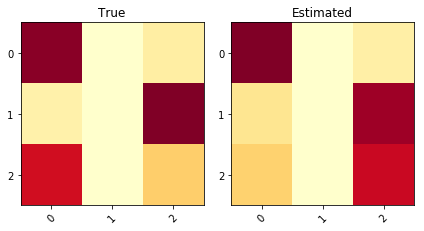

KL divergence: 0.1872	Pearson Correlation between diagonals: 0.8215


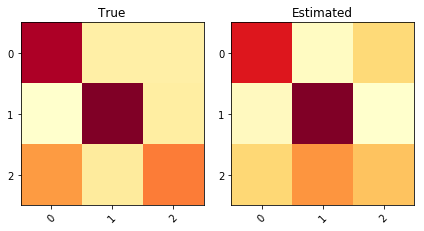

KL divergence: 0.1432	Pearson Correlation between diagonals: 0.9889
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.685389 |     0.685389 |     0.181859 |              0.810482 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.693529 |     0.693529 |
+----+--------+------------+--------------+


In [85]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


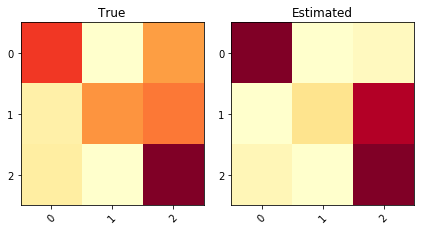

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7930


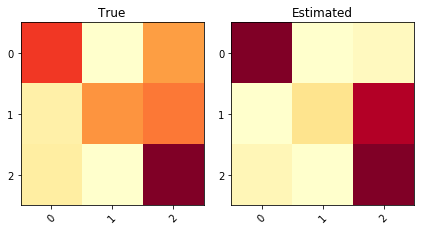

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7930


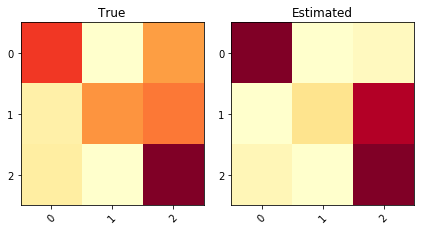

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7930


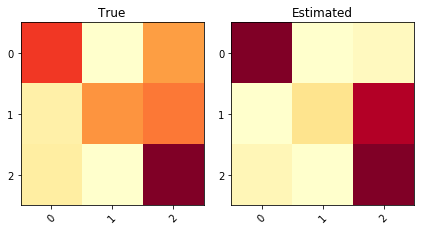

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7930


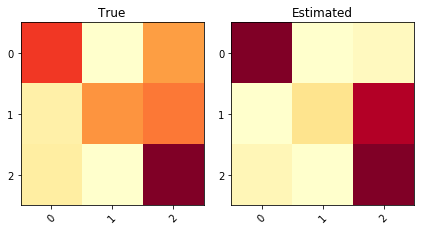

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7930


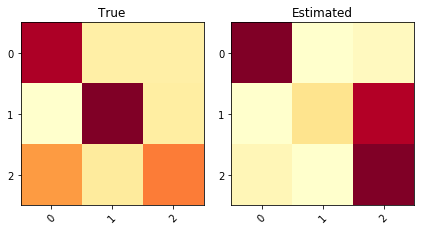

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6542


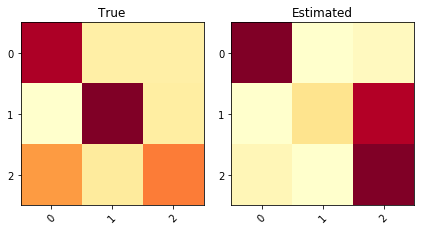

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6542


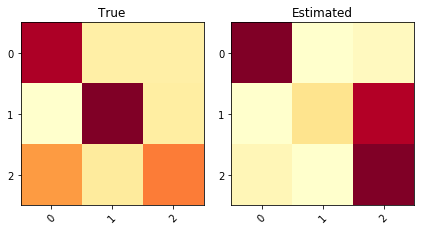

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6542


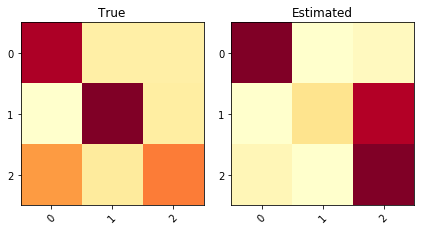

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6542


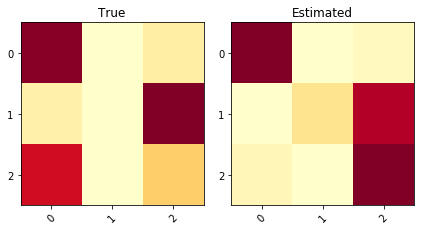

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7260


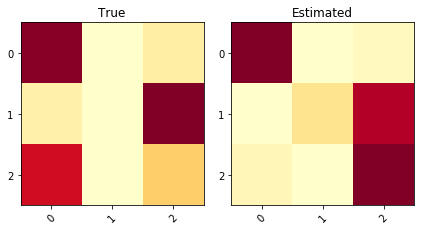

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7260


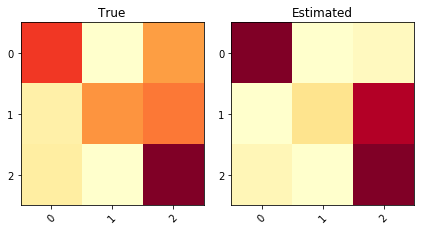

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7930


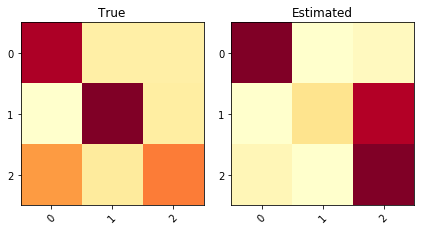

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6542


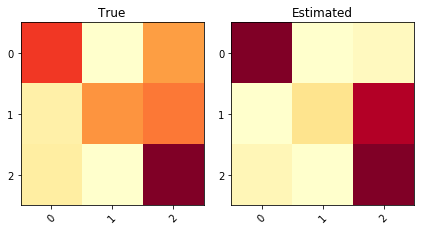

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7930


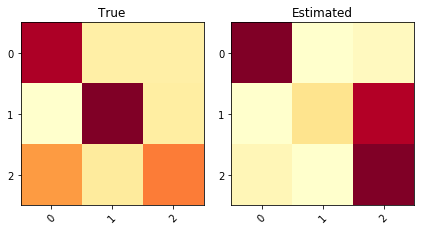

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6542
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.685389 |     0.685389 |     0.492097 |              0.456583 |
+----+--------+------------+--------------+--------------+-----------------------+


In [86]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


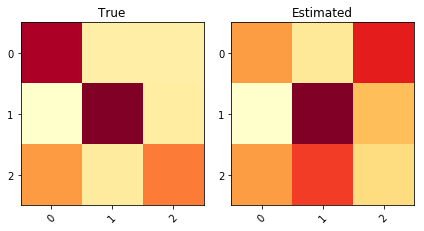

KL divergence: 0.3354	Pearson Correlation between diagonals: 0.8405


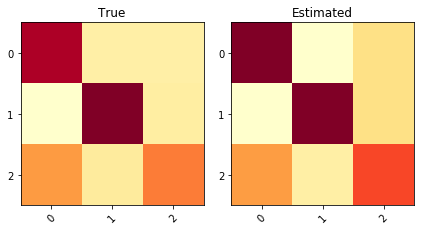

KL divergence: 0.4197	Pearson Correlation between diagonals: 0.9821


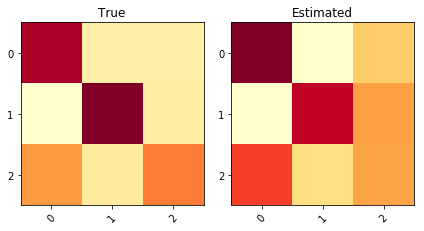

KL divergence: 0.3343	Pearson Correlation between diagonals: 0.9105


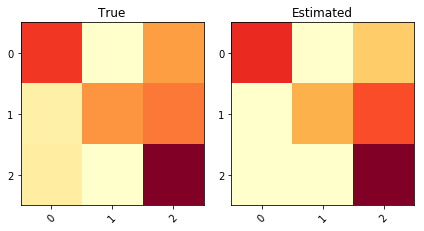

KL divergence: 0.8559	Pearson Correlation between diagonals: 0.9844


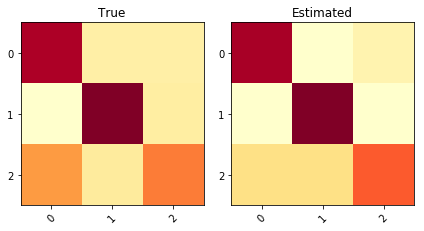

KL divergence: 0.8982	Pearson Correlation between diagonals: 1.0000


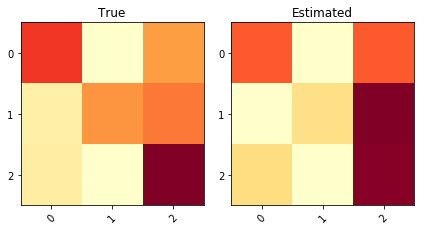

KL divergence: 0.4771	Pearson Correlation between diagonals: 0.9901


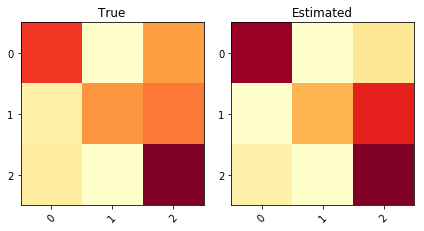

KL divergence: 0.4622	Pearson Correlation between diagonals: 0.8433


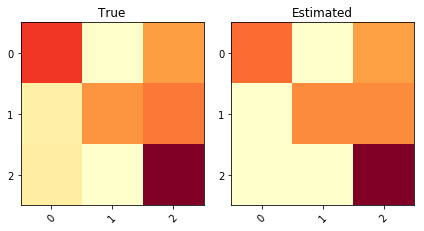

KL divergence: 0.8437	Pearson Correlation between diagonals: 0.9619


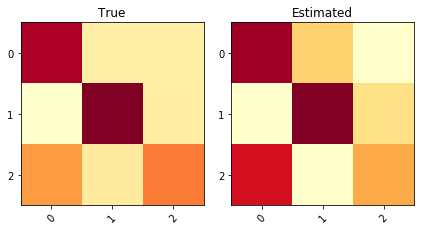

KL divergence: 0.9811	Pearson Correlation between diagonals: 0.9958


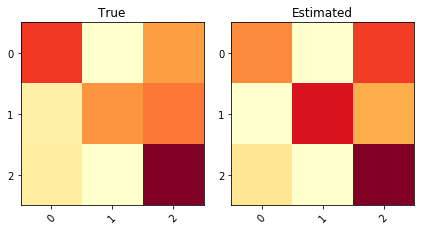

KL divergence: 0.4375	Pearson Correlation between diagonals: 0.5539


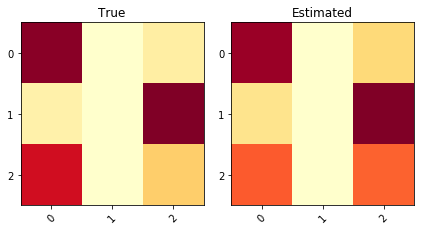

KL divergence: 0.0564	Pearson Correlation between diagonals: 0.9308


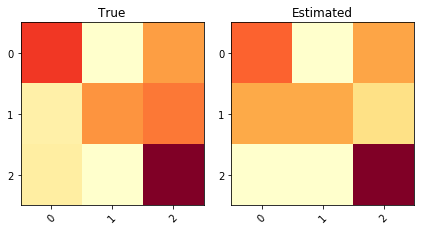

KL divergence: 0.5601	Pearson Correlation between diagonals: 0.9956


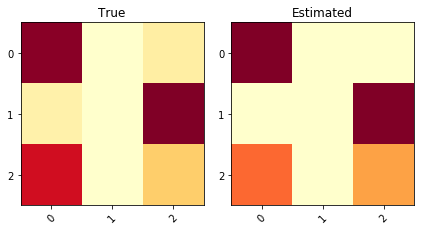

KL divergence: 0.8386	Pearson Correlation between diagonals: 0.9878


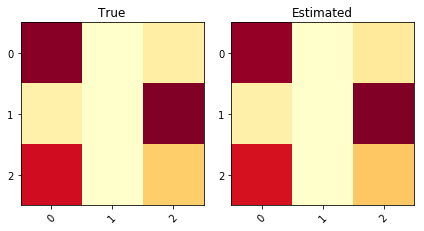

KL divergence: 0.0015	Pearson Correlation between diagonals: 0.9993


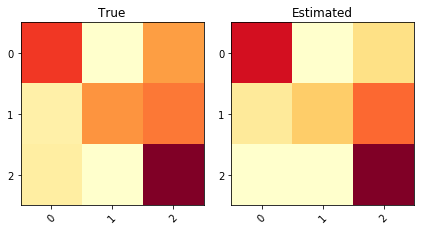

KL divergence: 0.5015	Pearson Correlation between diagonals: 0.9301
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.928368 |     0.928368 |     0.682856 |              0.871992 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.942613 |     0.942613 |
+----+--------+------------+--------------+


In [87]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


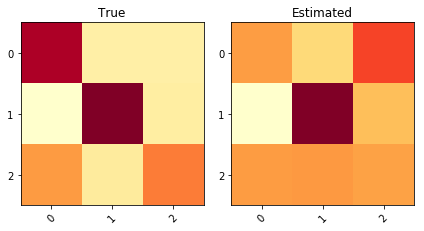

KL divergence: 0.3046	Pearson Correlation between diagonals: 0.6738


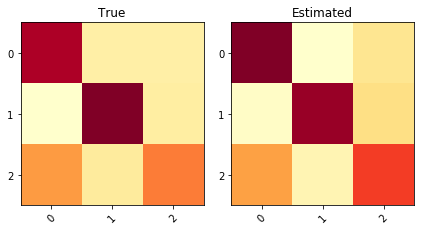

KL divergence: 0.0776	Pearson Correlation between diagonals: 0.9407


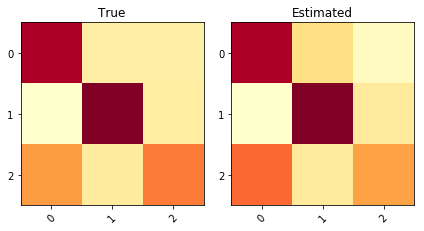

KL divergence: 0.0735	Pearson Correlation between diagonals: 0.9993


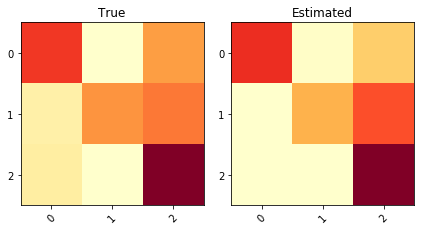

KL divergence: 0.0725	Pearson Correlation between diagonals: 0.9882


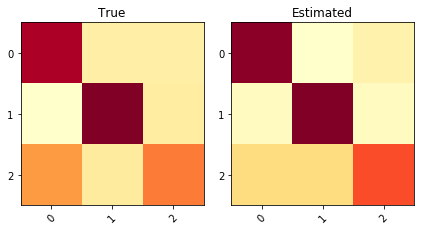

KL divergence: 0.0649	Pearson Correlation between diagonals: 0.9912


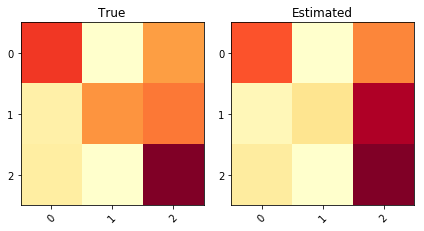

KL divergence: 0.1059	Pearson Correlation between diagonals: 0.9861


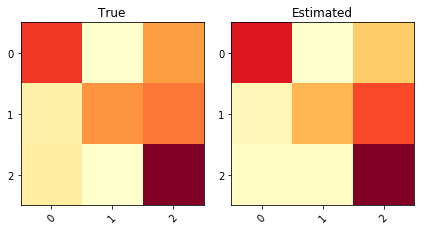

KL divergence: 0.0669	Pearson Correlation between diagonals: 0.9617


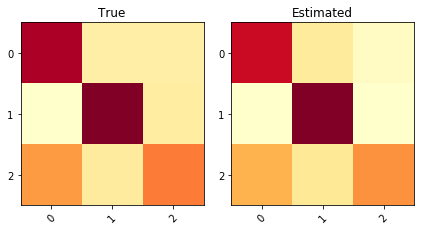

KL divergence: 0.0398	Pearson Correlation between diagonals: 0.9917


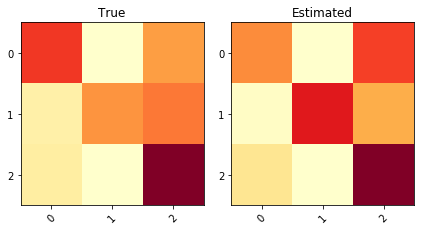

KL divergence: 0.1187	Pearson Correlation between diagonals: 0.5968


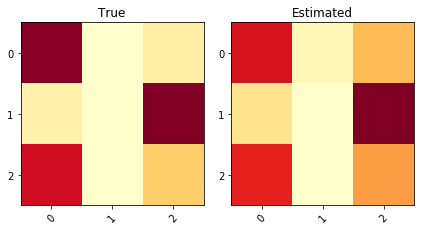

KL divergence: 0.1548	Pearson Correlation between diagonals: 0.9491


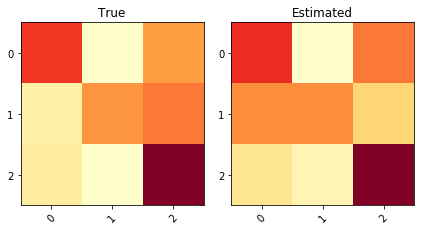

KL divergence: 0.1681	Pearson Correlation between diagonals: 0.9996


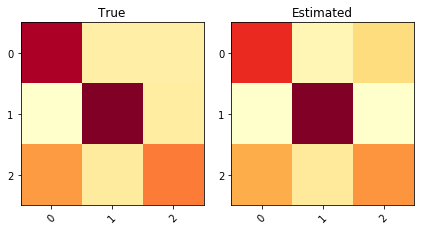

KL divergence: 0.0636	Pearson Correlation between diagonals: 0.9293


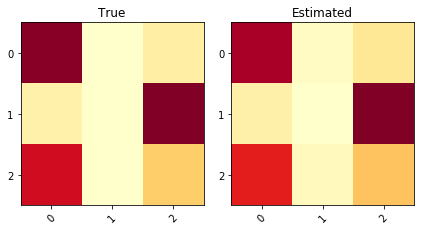

KL divergence: 0.1137	Pearson Correlation between diagonals: 0.9979


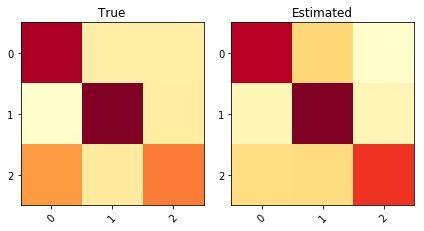

KL divergence: 0.1029	Pearson Correlation between diagonals: 0.9773


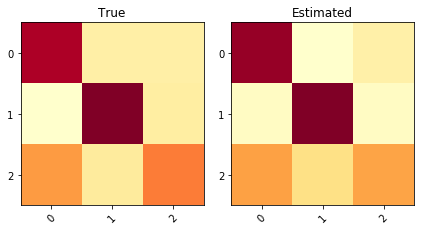

KL divergence: 0.0537	Pearson Correlation between diagonals: 0.9931
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.893366 |     0.893366 |     0.124229 |              0.879509 |       0.148146 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.686313 |               0.774009 |
+----+-------------------------+------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+----

In [88]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


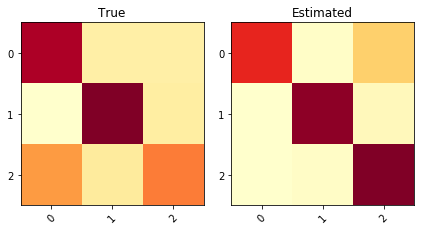

KL divergence: 0.7427	Pearson Correlation between diagonals: -0.4191


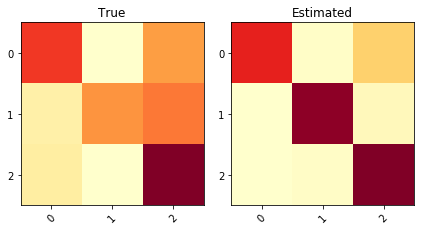

KL divergence: 0.5205	Pearson Correlation between diagonals: 0.2283


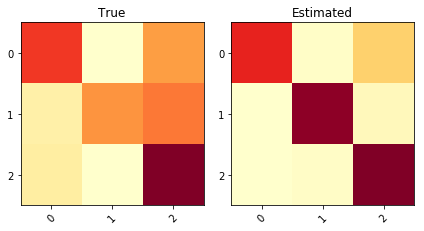

KL divergence: 0.5199	Pearson Correlation between diagonals: 0.2265


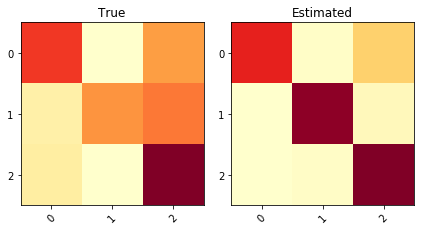

KL divergence: 0.5211	Pearson Correlation between diagonals: 0.2293


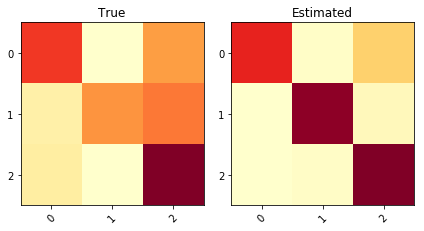

KL divergence: 0.5206	Pearson Correlation between diagonals: 0.2267


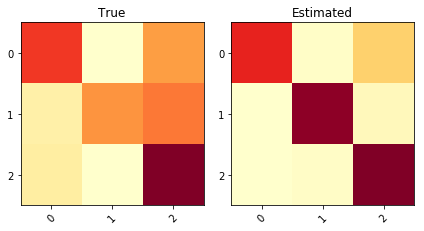

KL divergence: 0.5199	Pearson Correlation between diagonals: 0.2263


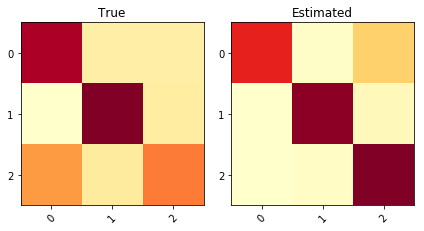

KL divergence: 0.7617	Pearson Correlation between diagonals: -0.4214


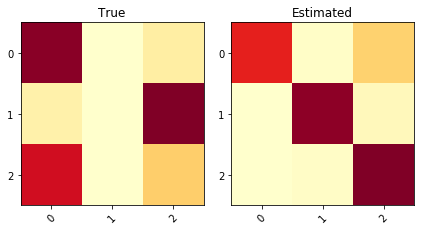

KL divergence: 2.4342	Pearson Correlation between diagonals: -0.9242


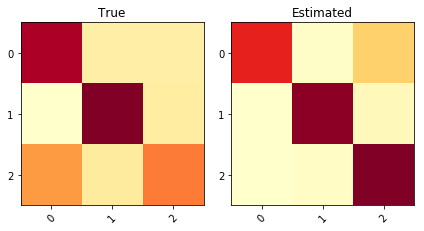

KL divergence: 0.7638	Pearson Correlation between diagonals: -0.4201


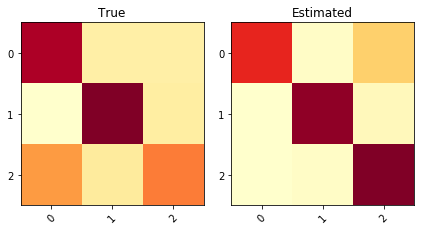

KL divergence: 0.7358	Pearson Correlation between diagonals: -0.4217


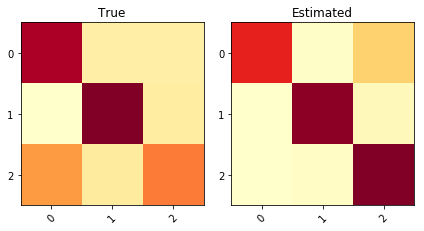

KL divergence: 0.7649	Pearson Correlation between diagonals: -0.4229


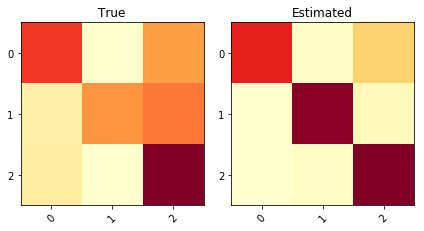

KL divergence: 0.5212	Pearson Correlation between diagonals: 0.2303


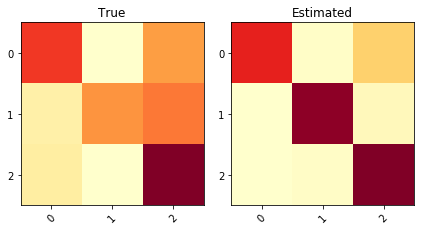

KL divergence: 0.5208	Pearson Correlation between diagonals: 0.2271


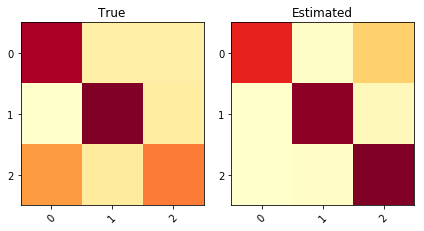

KL divergence: 0.7576	Pearson Correlation between diagonals: -0.4205


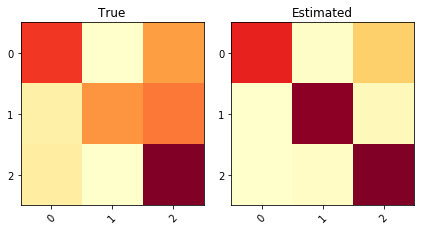

KL divergence: 0.5194	Pearson Correlation between diagonals: 0.2238
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.753358 |     0.753358 |     0.965625 |             -0.152527 |       0.181021 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                 0.60378 |               0.800789 |
+----+-------------------------+------------------------+
Test


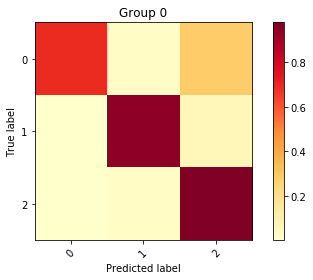

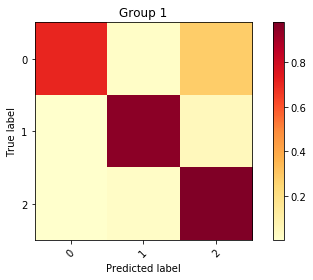

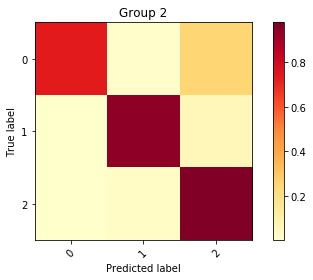

Inertia: 0.0004331707799186309
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.167999 |    335 |  0.346195 |    0.871911 |  0.148446 |           0.92906  |   0.653236 |     0.653236 |
|  1 |        1 | 0.393472 |    786 |  0.318149 |    0.880247 |  0.138063 |           0.933903 |   0.654457 |     0.654457 |
|  2 |        2 | 0.438528 |    877 |  0.314637 |    0.886976 |  0.127906 |           0.938394 |   0.653236 |     0.653236 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |  

In [89]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


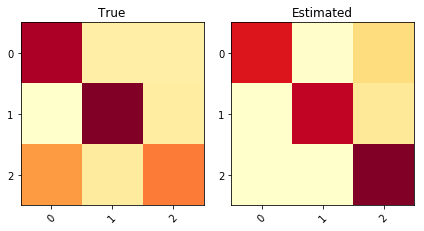

KL divergence: 0.6653	Pearson Correlation between diagonals: -0.8447


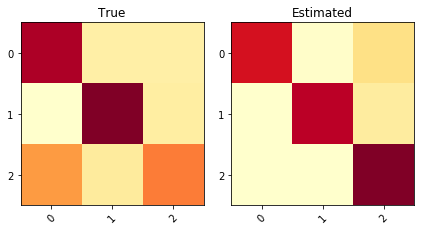

KL divergence: 0.6593	Pearson Correlation between diagonals: -0.8285


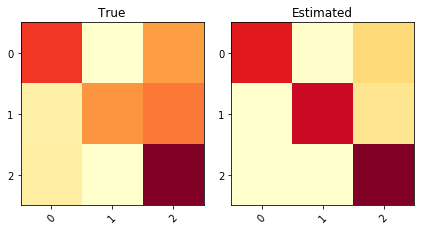

KL divergence: 0.2768	Pearson Correlation between diagonals: 0.7564


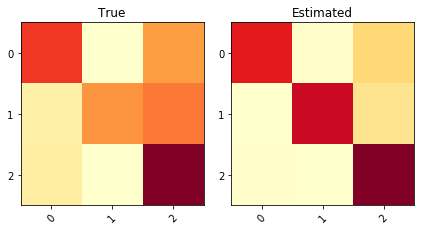

KL divergence: 0.2745	Pearson Correlation between diagonals: 0.7558


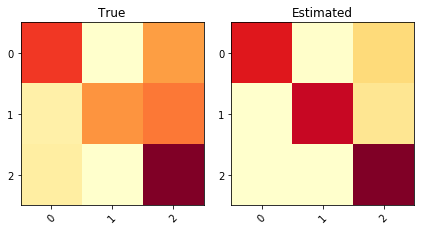

KL divergence: 0.2846	Pearson Correlation between diagonals: 0.7471


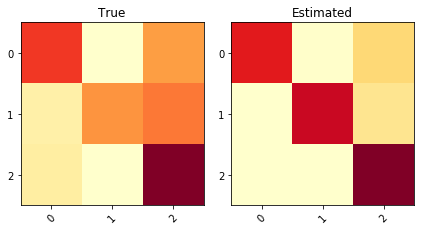

KL divergence: 0.2785	Pearson Correlation between diagonals: 0.7498


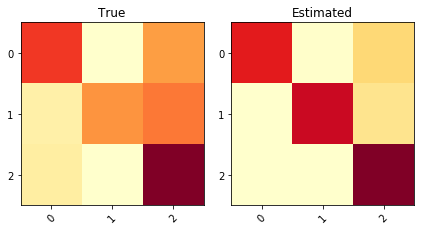

KL divergence: 0.2750	Pearson Correlation between diagonals: 0.7560


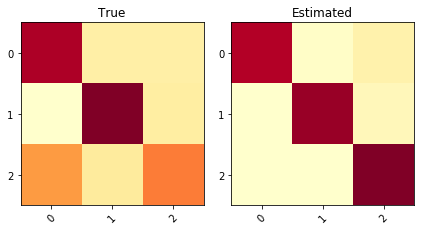

KL divergence: 0.6500	Pearson Correlation between diagonals: -0.7517


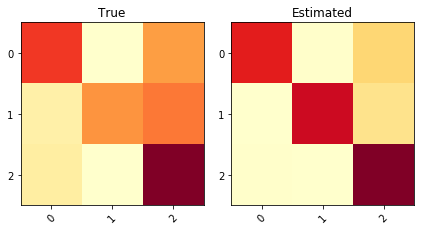

KL divergence: 0.2665	Pearson Correlation between diagonals: 0.7702


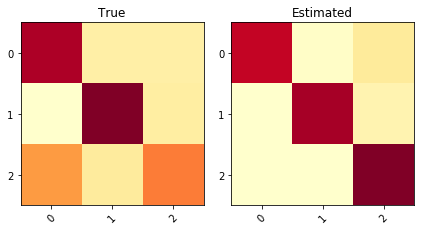

KL divergence: 0.6502	Pearson Correlation between diagonals: -0.7831


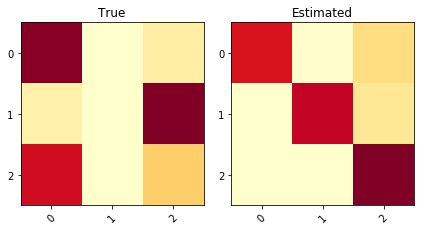

KL divergence: 1.7513	Pearson Correlation between diagonals: -0.5406


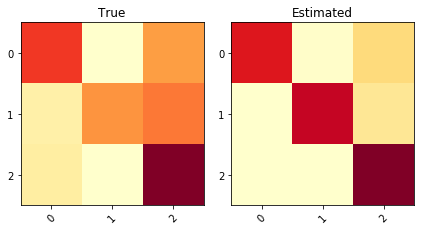

KL divergence: 0.2918	Pearson Correlation between diagonals: 0.7410


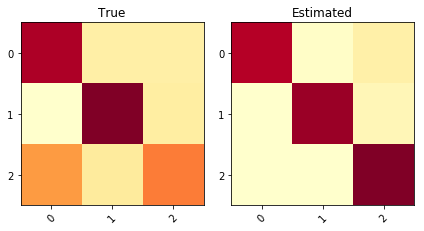

KL divergence: 0.6495	Pearson Correlation between diagonals: -0.7571


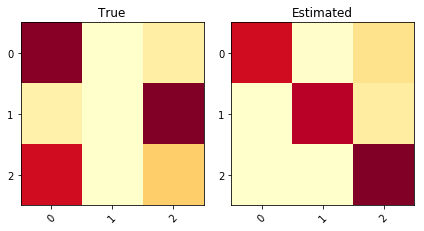

KL divergence: 1.8232	Pearson Correlation between diagonals: -0.5799


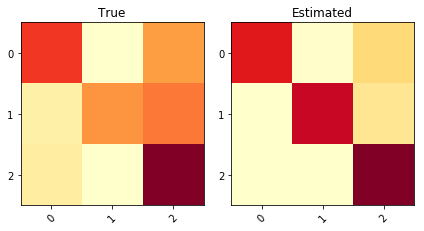

KL divergence: 0.2847	Pearson Correlation between diagonals: 0.7400
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.857957 |     0.857957 |     0.677225 |              0.138042 |       0.146876 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.624116 |               0.782549 |
+----+-------------------------+------------------------+
Test


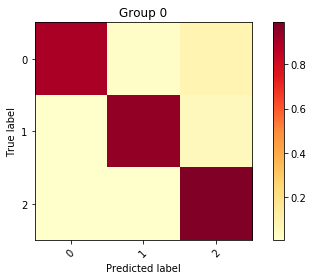

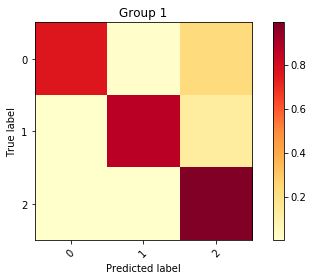

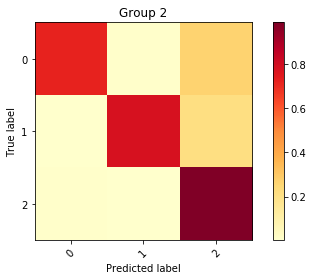

Inertia: 0.011974242593472203
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.196341 |    392 |  0.214499 |    0.947334 | 0.0548209 |           0.972903 |   0.805861 |     0.805861 |
|  1 |        1 | 0.394796 |    789 |  0.344517 |    0.875371 | 0.138847  |           0.932769 |   0.683761 |     0.683761 |
|  2 |        2 | 0.408862 |    817 |  0.408551 |    0.832388 | 0.192477  |           0.907676 |   0.649573 |     0.649573 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   

In [90]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


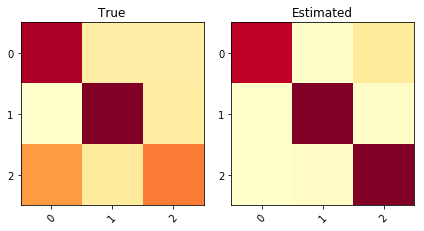

KL divergence: 0.7590	Pearson Correlation between diagonals: -0.3062


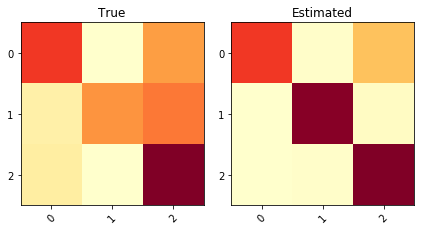

KL divergence: 0.6575	Pearson Correlation between diagonals: 0.1708


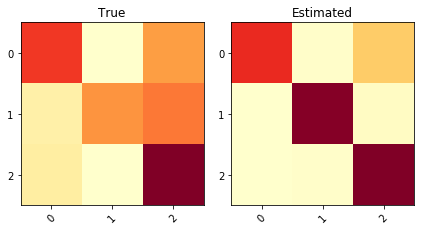

KL divergence: 0.6697	Pearson Correlation between diagonals: 0.1661


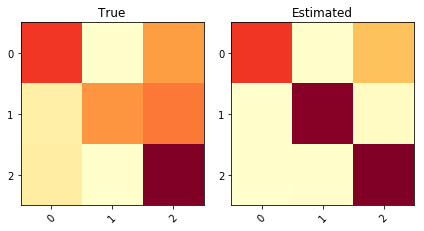

KL divergence: 0.6585	Pearson Correlation between diagonals: 0.1704


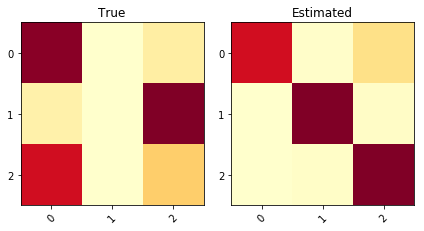

KL divergence: 2.8495	Pearson Correlation between diagonals: -0.9552


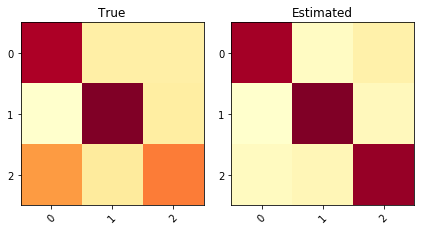

KL divergence: 0.2801	Pearson Correlation between diagonals: 0.3613


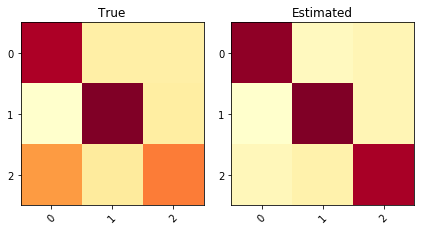

KL divergence: 0.1982	Pearson Correlation between diagonals: 0.9746


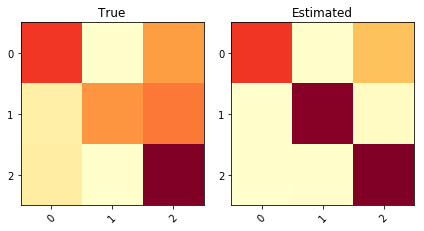

KL divergence: 0.6586	Pearson Correlation between diagonals: 0.1703


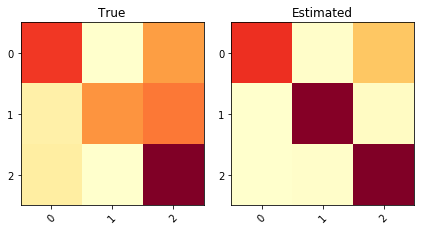

KL divergence: 0.6632	Pearson Correlation between diagonals: 0.1684


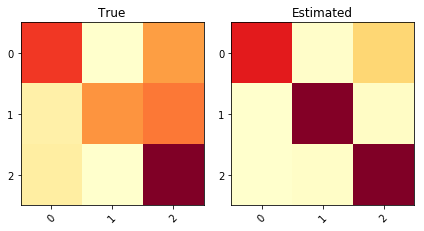

KL divergence: 0.6882	Pearson Correlation between diagonals: 0.1594


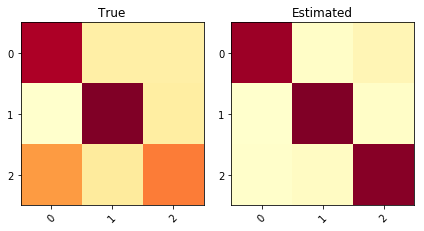

KL divergence: 0.5378	Pearson Correlation between diagonals: -0.0401


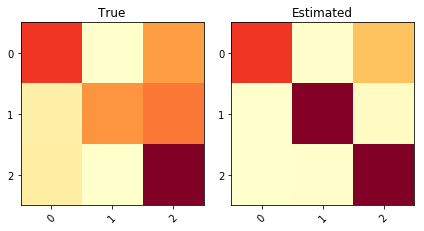

KL divergence: 0.6591	Pearson Correlation between diagonals: 0.1702


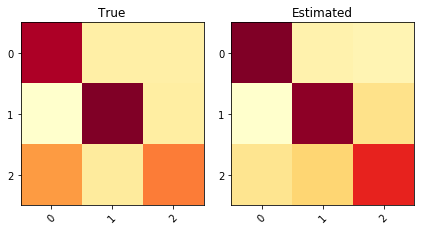

KL divergence: 0.0731	Pearson Correlation between diagonals: 0.9557


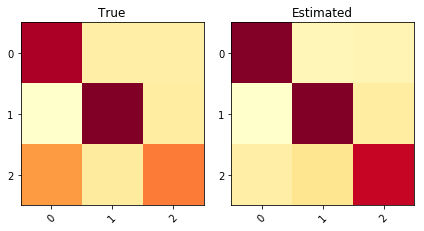

KL divergence: 0.1074	Pearson Correlation between diagonals: 0.9896


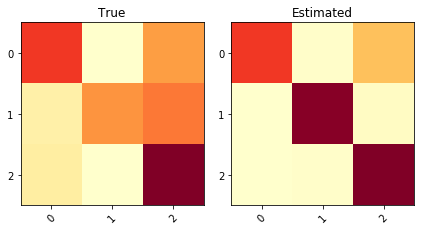

KL divergence: 0.6571	Pearson Correlation between diagonals: 0.1709
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.604803 |     0.604803 |      1.06992 |             -0.045063 |       0.162579 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.633817 |               0.755341 |
+----+-------------------------+------------------------+
Test


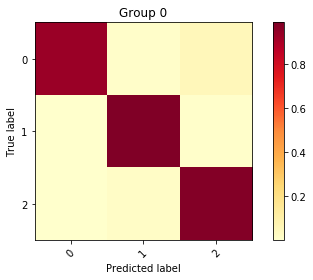

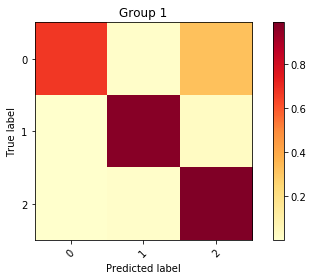

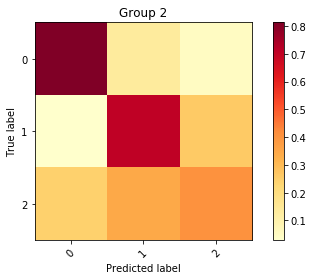

Inertia: 0.09336974937468767
A result
 +----+----------+-----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |      Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.34984   |    699 |  0.143549 |    0.968548 | 0.0322727 |           0.983982 |   0.642247 |     0.642247 |
|  1 |        1 | 0.636116  |   1272 |  0.288996 |    0.876938 | 0.146816  |           0.930489 |   0.642247 |     0.642247 |
|  2 |        2 | 0.0140437 |     28 |  0.789375 |    0.643002 | 0.482988  |           0.78226  |   0.656899 |     0.656899 |
+----+----------+-----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accurac

In [91]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 5) configuration: Manny annot v2 ($T=5000, T_{data}=40$)

In [11]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8131868131868132


*** Soft-Majority (Train with softMV) ***
Train


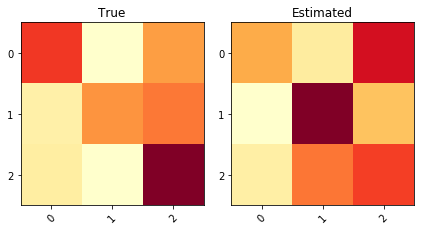

KL divergence: 0.3518	Pearson Correlation between diagonals: -0.4456


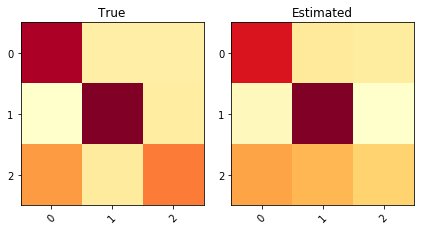

KL divergence: 0.1048	Pearson Correlation between diagonals: 0.9942


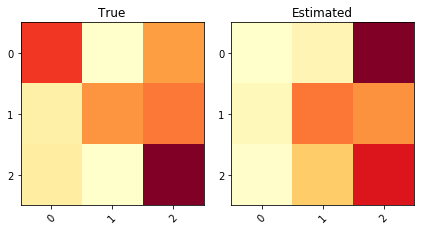

KL divergence: 0.4201	Pearson Correlation between diagonals: 0.4068


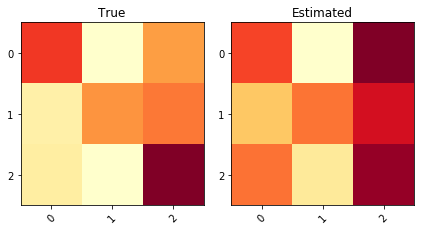

KL divergence: 0.1523	Pearson Correlation between diagonals: 0.9883


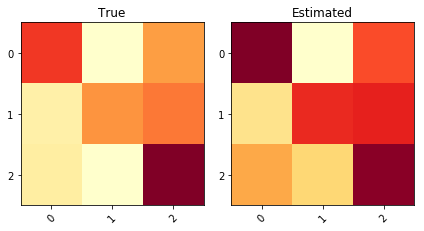

KL divergence: 0.1499	Pearson Correlation between diagonals: 0.7495


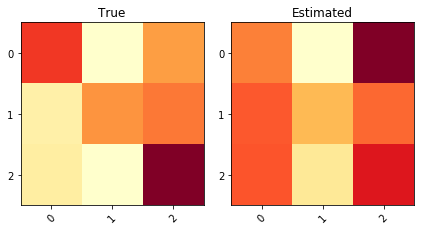

KL divergence: 0.2750	Pearson Correlation between diagonals: 0.9993


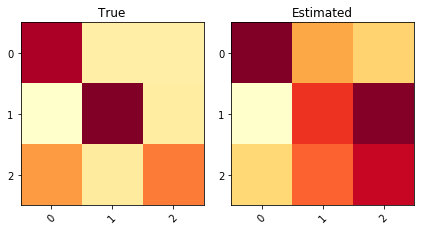

KL divergence: 0.2922	Pearson Correlation between diagonals: -0.1839


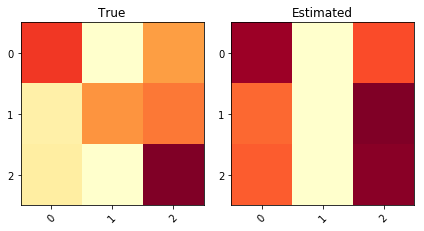

KL divergence: 2.1344	Pearson Correlation between diagonals: 0.8157


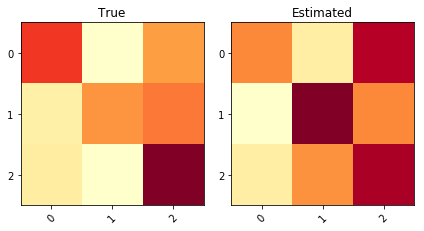

KL divergence: 0.2367	Pearson Correlation between diagonals: -0.0405


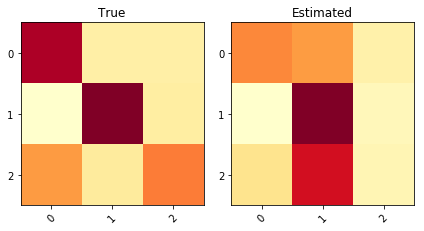

KL divergence: 0.3998	Pearson Correlation between diagonals: 0.9350


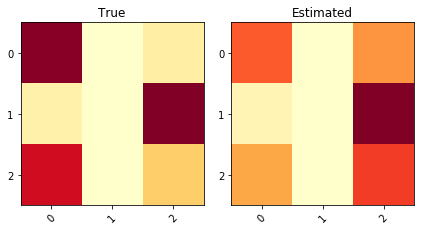

KL divergence: 0.1809	Pearson Correlation between diagonals: 0.6578


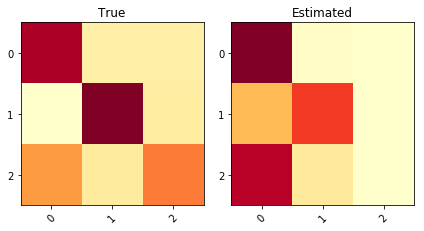

KL divergence: 3.3401	Pearson Correlation between diagonals: 0.8688


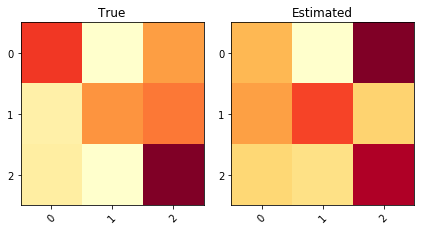

KL divergence: 0.2596	Pearson Correlation between diagonals: 0.5642


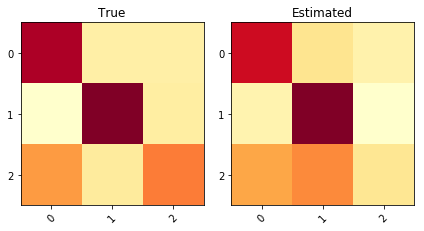

KL divergence: 0.1707	Pearson Correlation between diagonals: 0.9999


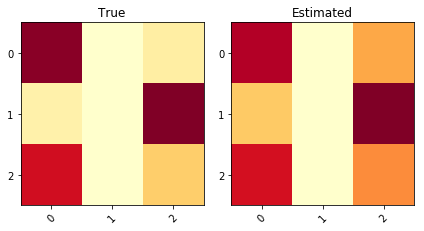

KL divergence: 0.0768	Pearson Correlation between diagonals: 0.9522
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.679691 |     0.679691 |     0.583063 |                0.6921 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.69475 |      0.69475 |
+----+--------+------------+--------------+


In [25]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


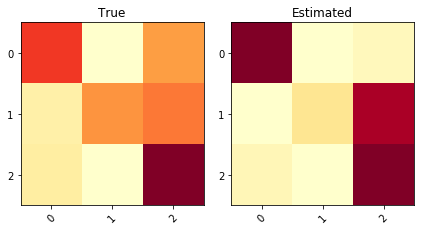

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


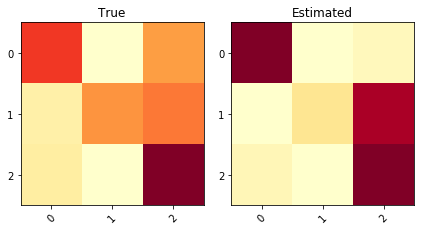

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


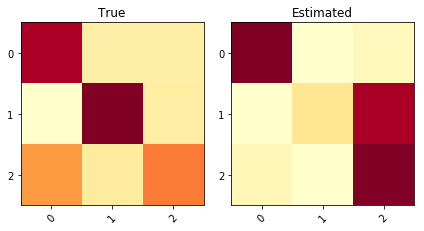

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6583


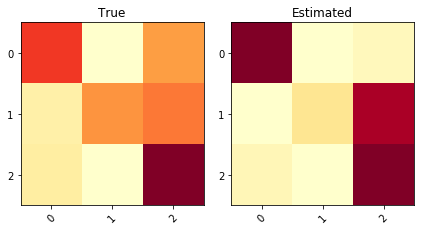

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


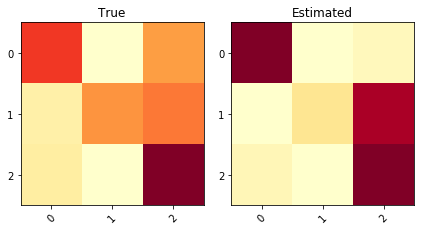

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


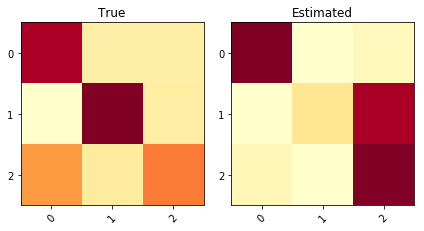

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6583


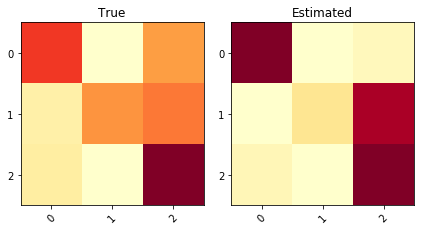

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


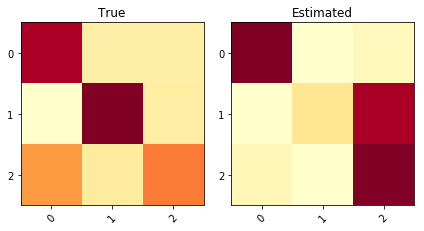

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6583


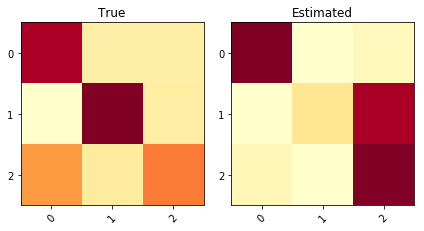

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6583


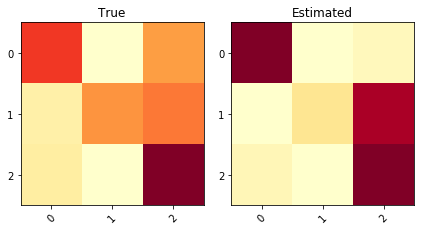

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


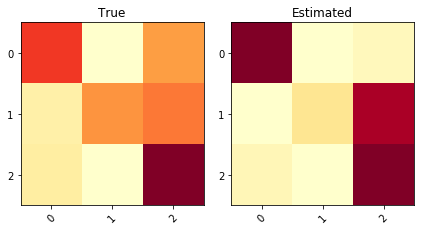

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


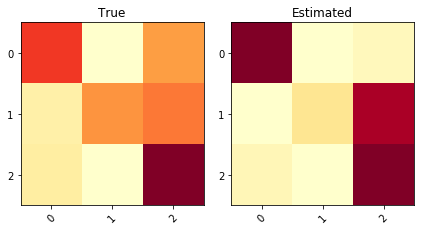

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


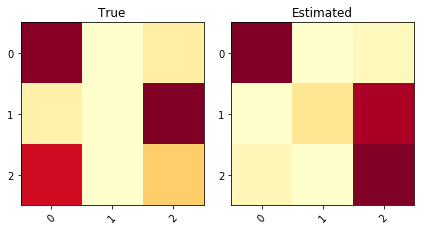

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7222


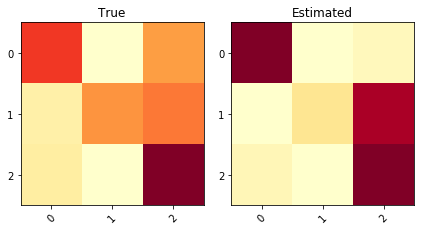

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


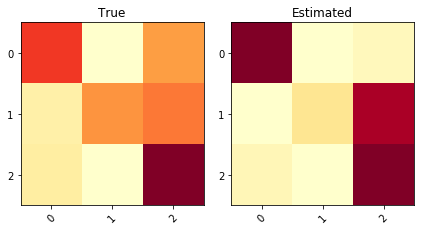

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.679691 |     0.679691 |     0.515368 |              0.426389 |
+----+--------+------------+--------------+--------------+-----------------------+


In [36]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


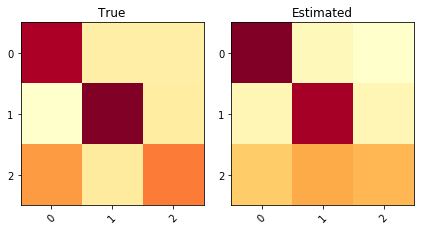

KL divergence: 0.1138	Pearson Correlation between diagonals: 0.9525


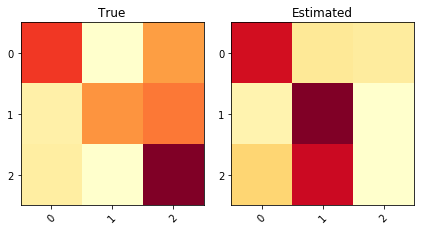

KL divergence: 3.5269	Pearson Correlation between diagonals: -0.9784


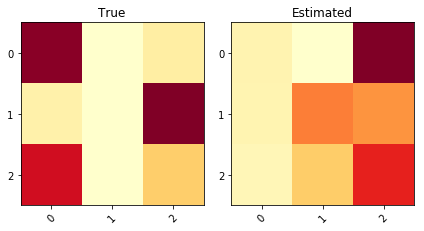

KL divergence: 1.2068	Pearson Correlation between diagonals: -0.8268


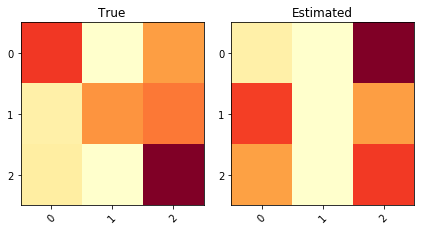

KL divergence: 2.4661	Pearson Correlation between diagonals: 0.9684


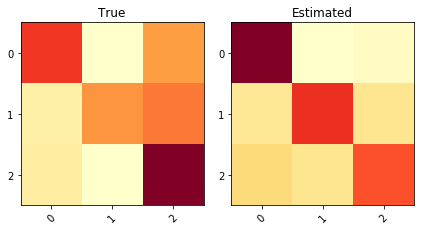

KL divergence: 0.4170	Pearson Correlation between diagonals: -0.3194


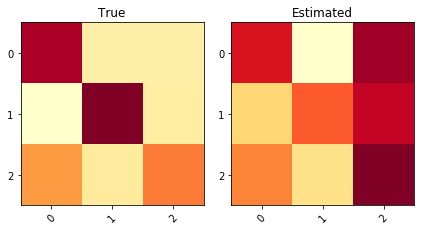

KL divergence: 0.4375	Pearson Correlation between diagonals: -0.9620


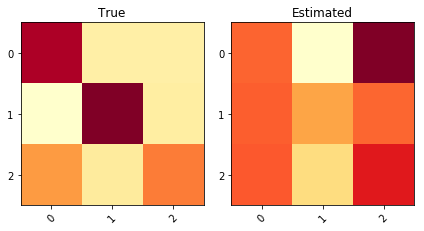

KL divergence: 0.5541	Pearson Correlation between diagonals: -0.9500


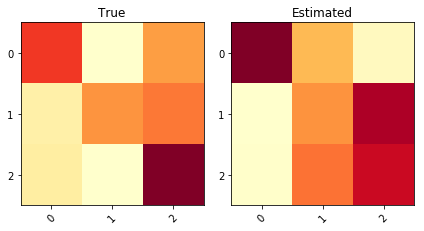

KL divergence: 0.6789	Pearson Correlation between diagonals: 0.5576


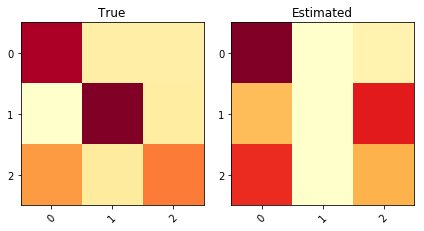

KL divergence: 5.6682	Pearson Correlation between diagonals: -0.0502


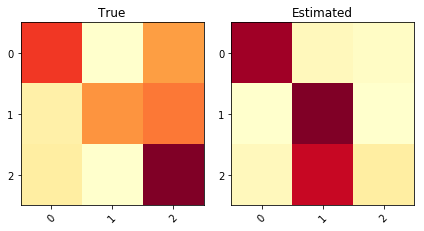

KL divergence: 1.3413	Pearson Correlation between diagonals: -0.9468


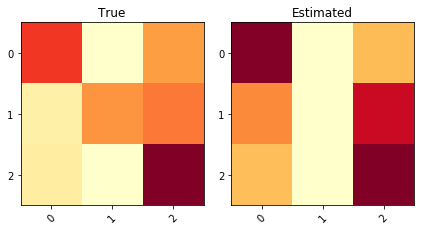

KL divergence: 2.1102	Pearson Correlation between diagonals: 0.8002


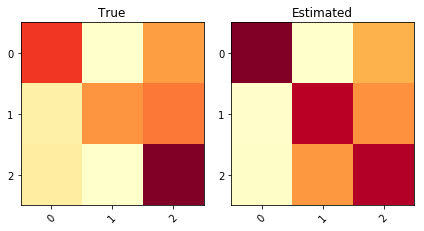

KL divergence: 0.1932	Pearson Correlation between diagonals: -0.0107


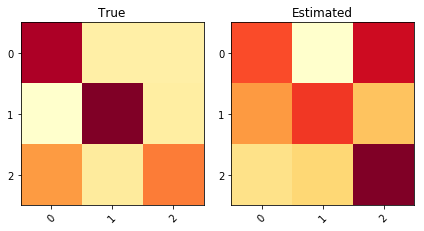

KL divergence: 0.4294	Pearson Correlation between diagonals: -0.9526


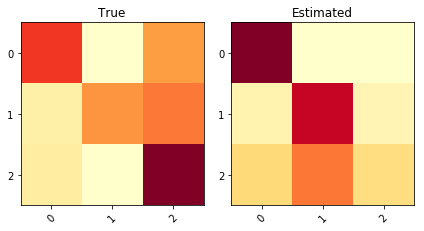

KL divergence: 0.7276	Pearson Correlation between diagonals: -0.8346


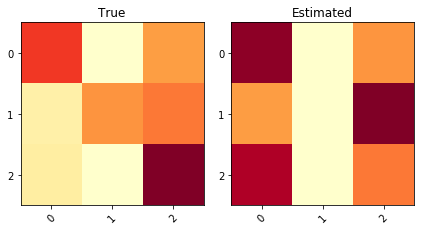

KL divergence: 2.2610	Pearson Correlation between diagonals: 0.4476
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.707367 |     0.707367 |      1.46083 |              0.151015 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.709402 |     0.709402 |
+----+--------+------------+--------------+


In [37]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


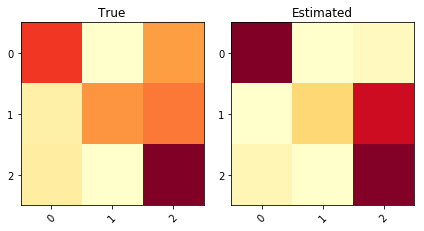

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


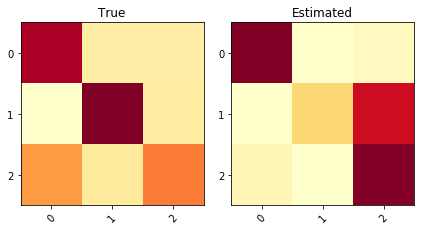

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6482


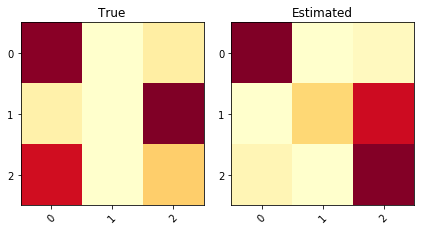

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7314


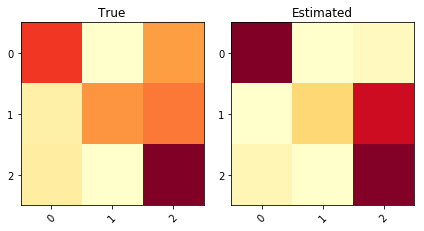

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


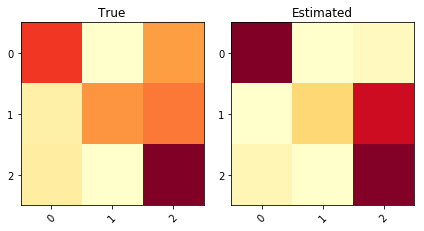

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


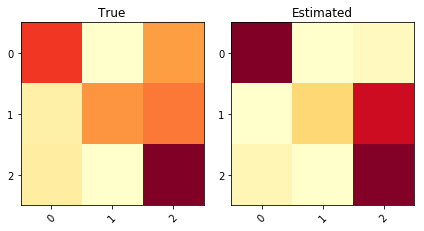

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


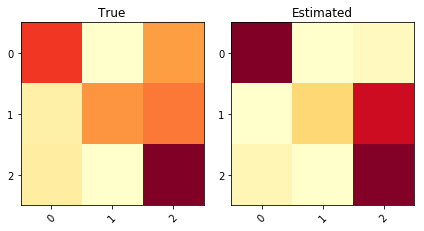

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


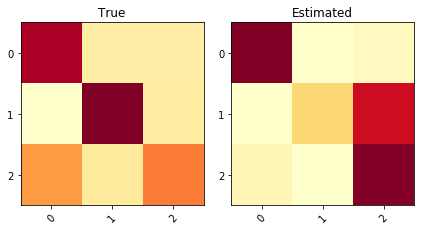

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6482


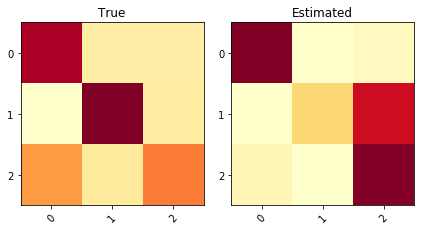

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6482


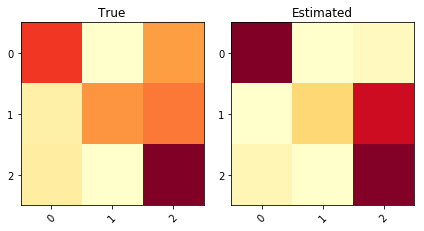

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


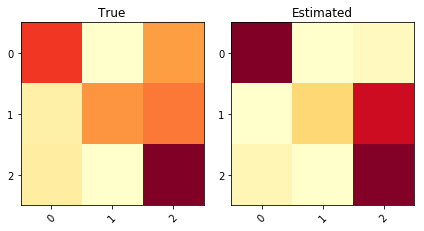

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


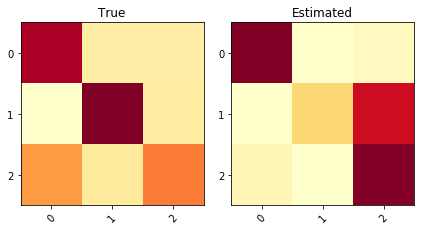

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6482


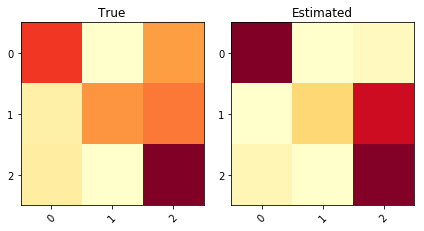

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


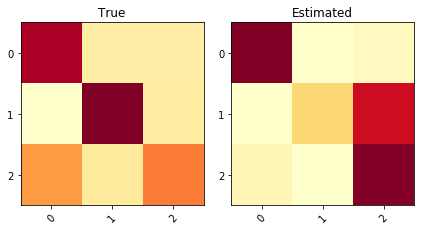

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6482


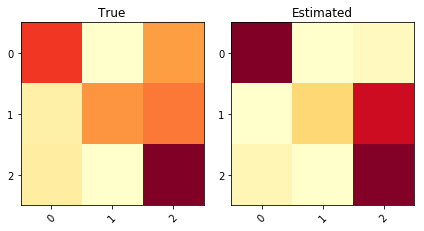

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.707367 |     0.707367 |     0.515368 |               0.42614 |
+----+--------+------------+--------------+--------------+-----------------------+


In [38]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


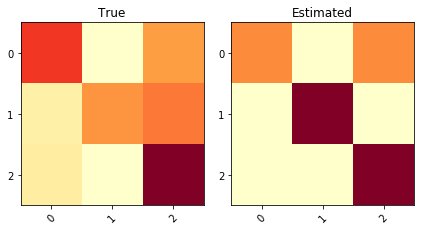

KL divergence: 3.2449	Pearson Correlation between diagonals: 0.1270


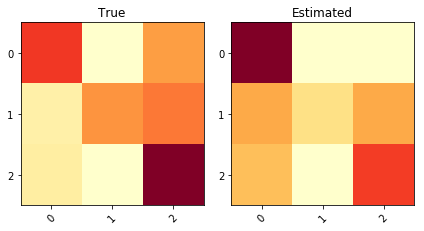

KL divergence: 2.0270	Pearson Correlation between diagonals: 0.4725


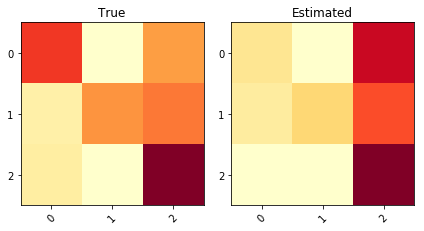

KL divergence: 0.6405	Pearson Correlation between diagonals: 0.8837


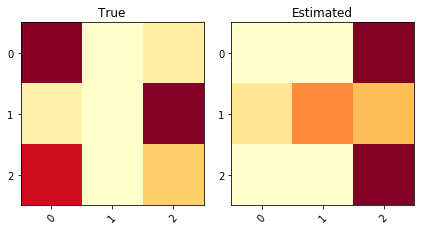

KL divergence: 8.7754	Pearson Correlation between diagonals: -0.6907


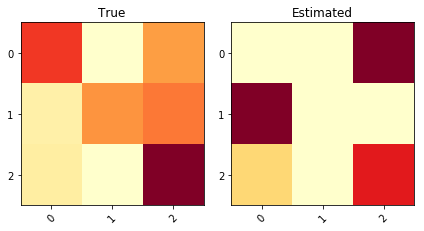

KL divergence: 7.6323	Pearson Correlation between diagonals: 0.9225


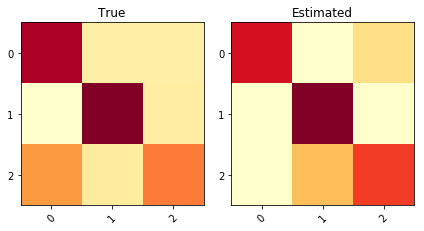

KL divergence: 2.8187	Pearson Correlation between diagonals: 0.9026


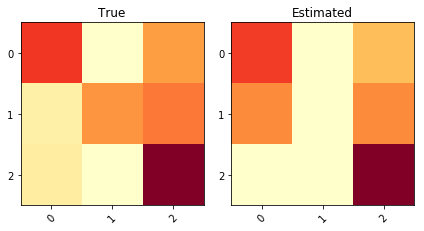

KL divergence: 2.5557	Pearson Correlation between diagonals: 0.9500


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


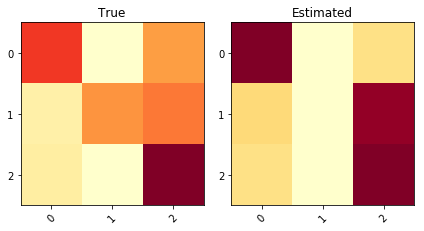

KL divergence: 2.1050	Pearson Correlation between diagonals: 0.7955


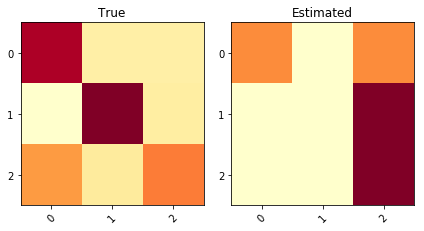

KL divergence: 7.7009	Pearson Correlation between diagonals: -0.9461


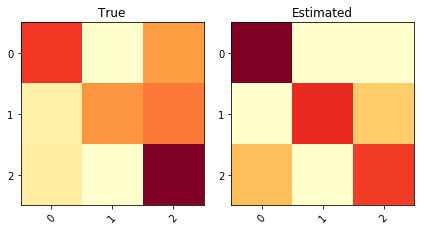

KL divergence: 2.3639	Pearson Correlation between diagonals: -0.2569


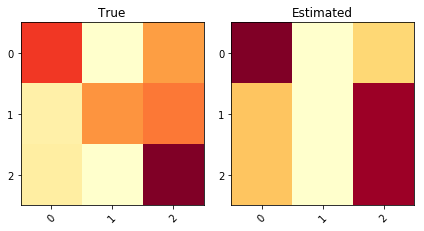

KL divergence: 2.1102	Pearson Correlation between diagonals: 0.7605


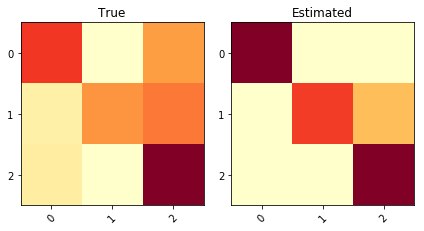

KL divergence: 2.7548	Pearson Correlation between diagonals: 0.7955


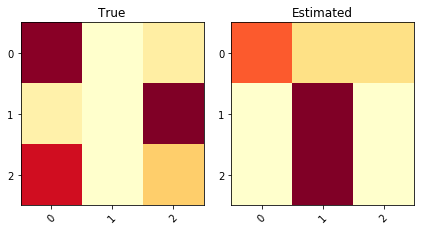

KL divergence: 10.5537	Pearson Correlation between diagonals: -0.1690


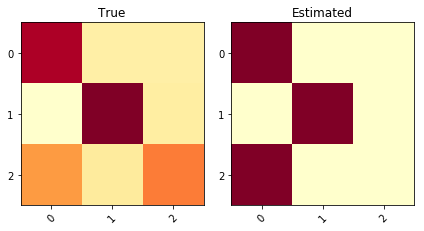

KL divergence: 4.1528	Pearson Correlation between diagonals: 0.9813


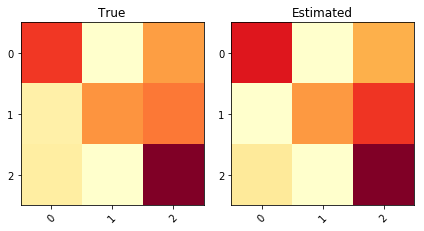

KL divergence: 0.3944	Pearson Correlation between diagonals: 0.9805
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.929996 |     0.929996 |      3.40725 |                   nan |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.945055 |     0.945055 |
+----+--------+------------+--------------+


In [39]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


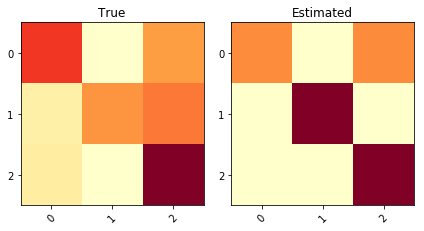

KL divergence: 0.2489	Pearson Correlation between diagonals: 0.1270


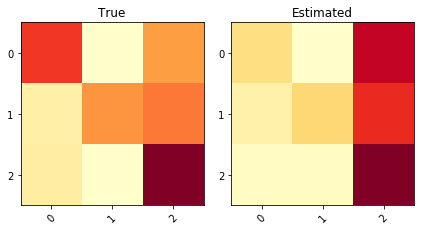

KL divergence: 0.1976	Pearson Correlation between diagonals: 0.9049


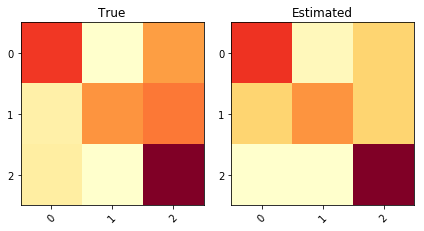

KL divergence: 0.1430	Pearson Correlation between diagonals: 0.9997


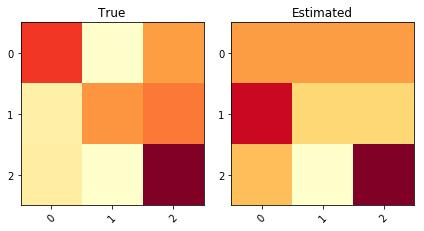

KL divergence: 0.3715	Pearson Correlation between diagonals: 0.9897


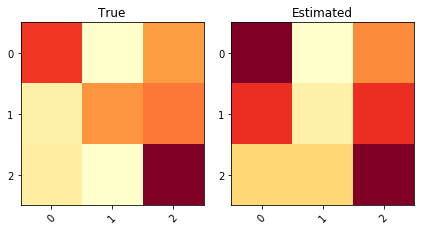

KL divergence: 0.2963	Pearson Correlation between diagonals: 0.7955


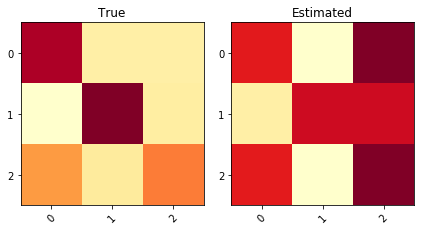

KL divergence: 0.3069	Pearson Correlation between diagonals: -0.8919


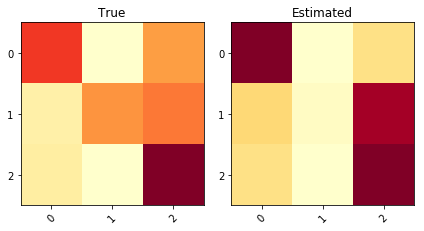

KL divergence: 0.2181	Pearson Correlation between diagonals: 0.7954


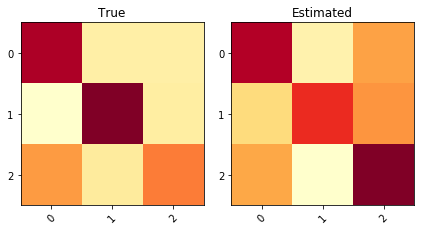

KL divergence: 0.2375	Pearson Correlation between diagonals: -0.8901


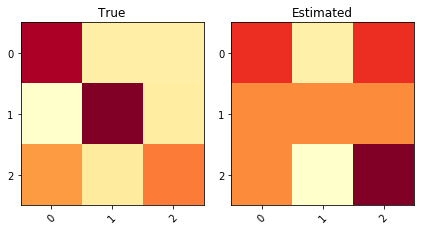

KL divergence: 0.3800	Pearson Correlation between diagonals: -0.9771


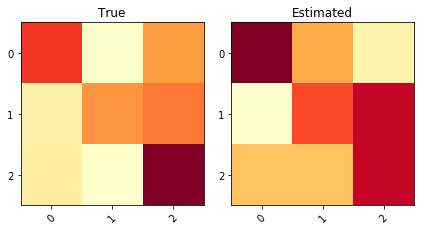

KL divergence: 0.2884	Pearson Correlation between diagonals: 0.4725


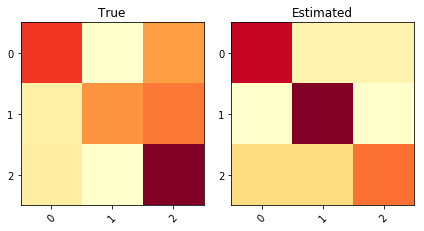

KL divergence: 0.4346	Pearson Correlation between diagonals: -0.9993


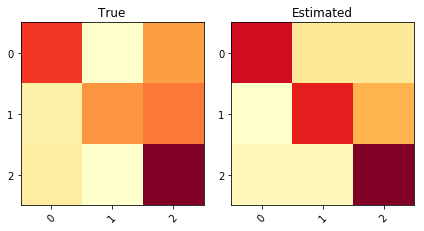

KL divergence: 0.1636	Pearson Correlation between diagonals: 0.9926


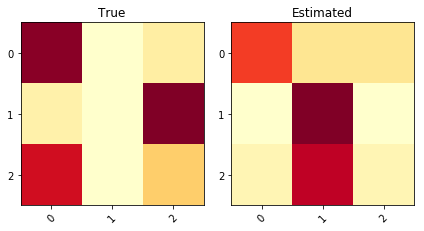

KL divergence: 0.9886	Pearson Correlation between diagonals: -0.1210


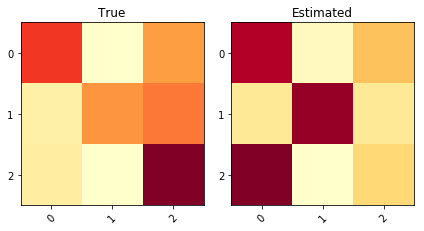

KL divergence: 0.4422	Pearson Correlation between diagonals: -0.9486


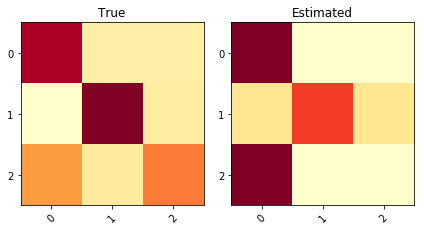

KL divergence: 0.2459	Pearson Correlation between diagonals: 0.8643
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.927961 |     0.927961 |     0.377019 |              0.135643 |       0.234728 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                 0.49585 |                1.01583 |
+----+-------------------------+------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+----

In [40]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


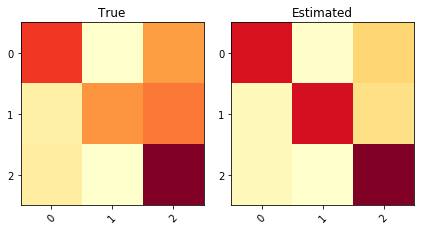

KL divergence: 0.1157	Pearson Correlation between diagonals: 0.9026


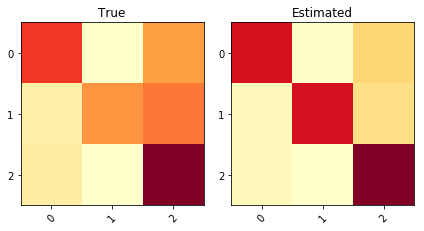

KL divergence: 0.1167	Pearson Correlation between diagonals: 0.9054


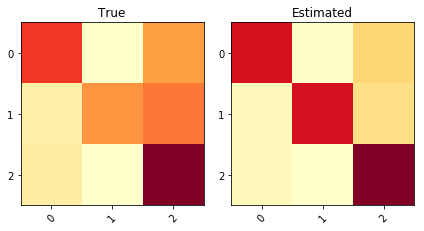

KL divergence: 0.1167	Pearson Correlation between diagonals: 0.9063


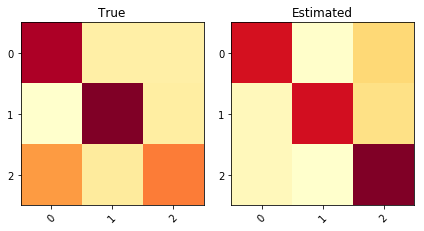

KL divergence: 0.4456	Pearson Correlation between diagonals: -0.9755


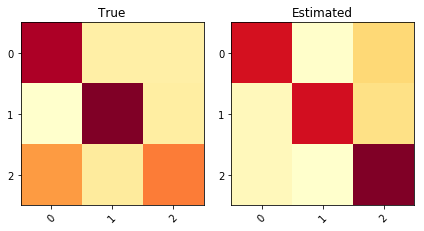

KL divergence: 0.4459	Pearson Correlation between diagonals: -0.9750


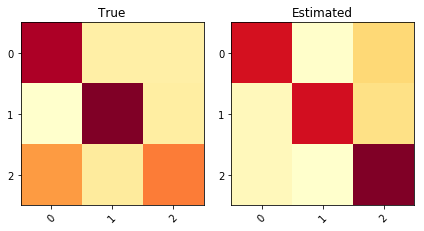

KL divergence: 0.4460	Pearson Correlation between diagonals: -0.9748


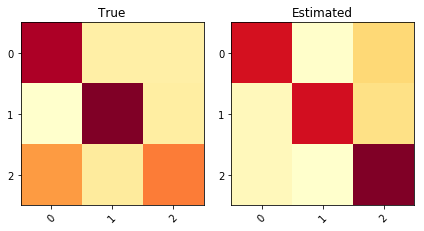

KL divergence: 0.4459	Pearson Correlation between diagonals: -0.9749


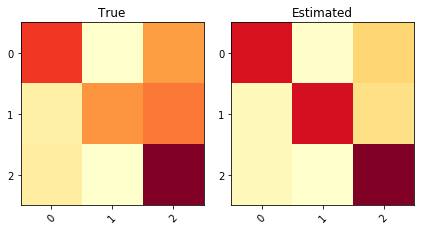

KL divergence: 0.1162	Pearson Correlation between diagonals: 0.9043


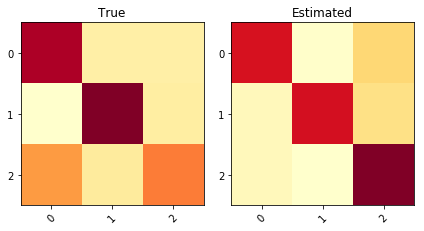

KL divergence: 0.4461	Pearson Correlation between diagonals: -0.9745


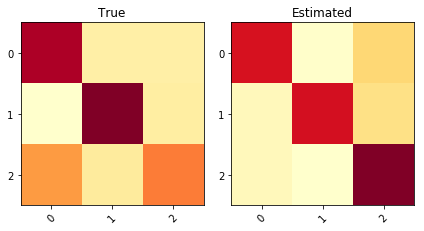

KL divergence: 0.4462	Pearson Correlation between diagonals: -0.9744


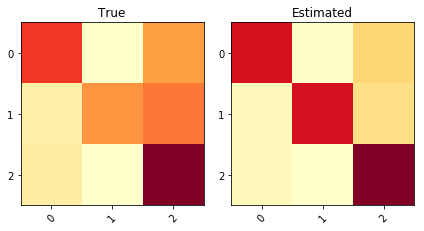

KL divergence: 0.1171	Pearson Correlation between diagonals: 0.9075


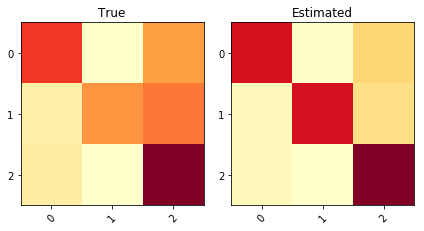

KL divergence: 0.1175	Pearson Correlation between diagonals: 0.9086


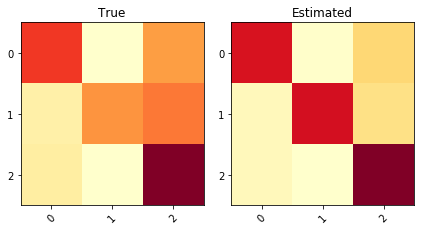

KL divergence: 0.1164	Pearson Correlation between diagonals: 0.9049


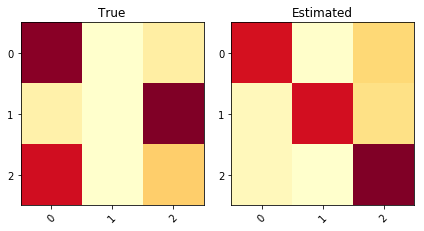

KL divergence: 1.0746	Pearson Correlation between diagonals: -0.2643


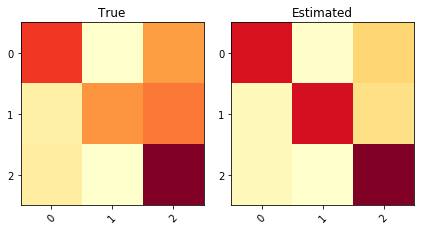

KL divergence: 0.1162	Pearson Correlation between diagonals: 0.9039
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.885226 |     0.885226 |       0.3874 |              0.213494 |       0.176167 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.607307 |               0.798306 |
+----+-------------------------+------------------------+
Test


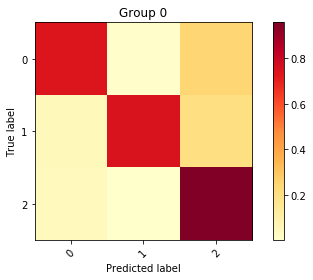

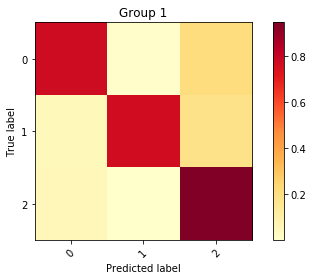

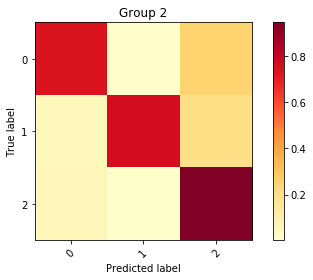

Inertia: 0.00042252625765589374
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.235684 |   1178 |  0.501753 |    0.812937 |  0.214532 |           0.897063 |   0.675214 |     0.675214 |
|  1 |        1 | 0.362757 |   1813 |  0.478567 |    0.830653 |  0.190271 |           0.908106 |   0.699634 |     0.699634 |
|  2 |        2 | 0.401559 |   2007 |  0.496005 |    0.815474 |  0.210385 |           0.898866 |   0.686203 |     0.686203 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy | 

In [41]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


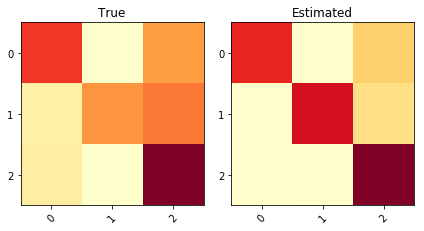

KL divergence: 0.2029	Pearson Correlation between diagonals: 0.7879


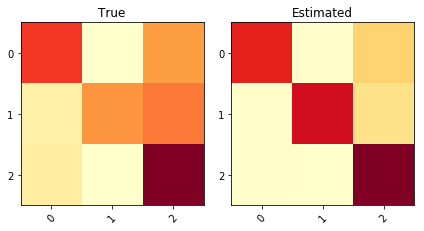

KL divergence: 0.2129	Pearson Correlation between diagonals: 0.7875


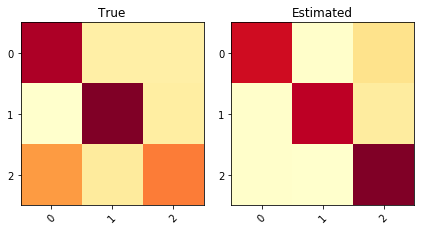

KL divergence: 0.6973	Pearson Correlation between diagonals: -0.8719


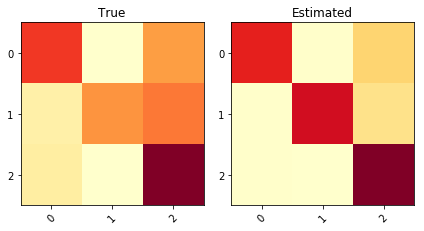

KL divergence: 0.2146	Pearson Correlation between diagonals: 0.7873


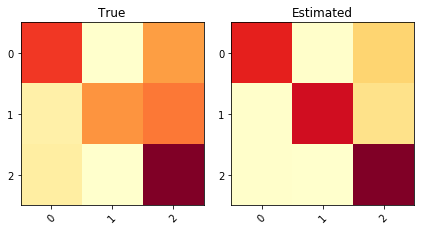

KL divergence: 0.2165	Pearson Correlation between diagonals: 0.7883


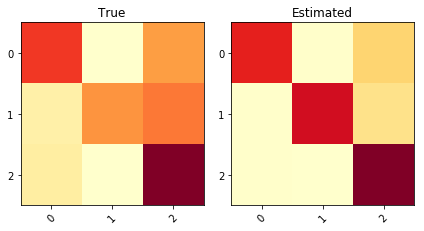

KL divergence: 0.2147	Pearson Correlation between diagonals: 0.7891


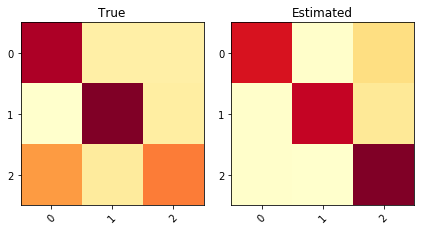

KL divergence: 0.6978	Pearson Correlation between diagonals: -0.8854


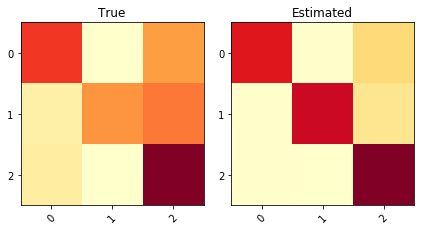

KL divergence: 0.2382	Pearson Correlation between diagonals: 0.7823


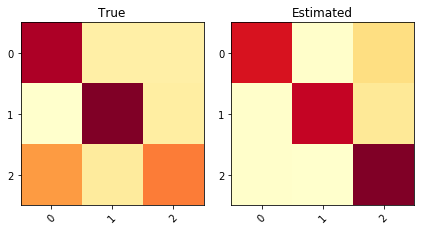

KL divergence: 0.6979	Pearson Correlation between diagonals: -0.8849


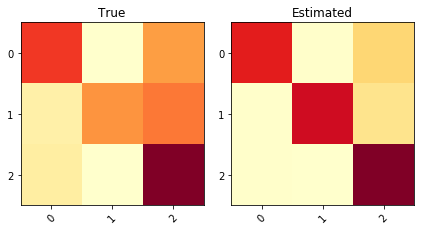

KL divergence: 0.2233	Pearson Correlation between diagonals: 0.7867


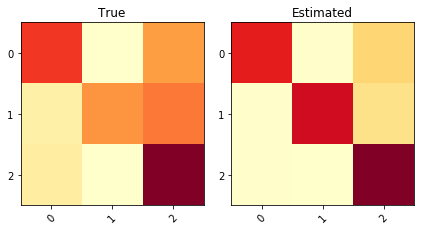

KL divergence: 0.2176	Pearson Correlation between diagonals: 0.7881


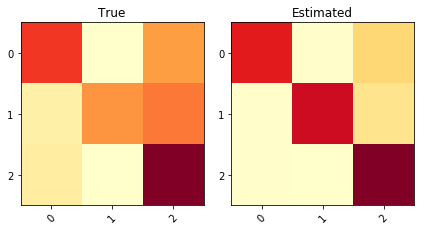

KL divergence: 0.2249	Pearson Correlation between diagonals: 0.7874


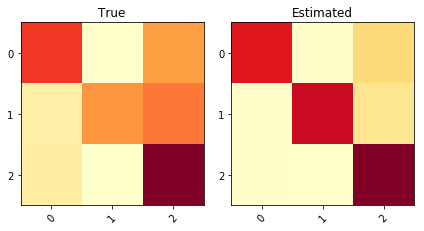

KL divergence: 0.2388	Pearson Correlation between diagonals: 0.7835


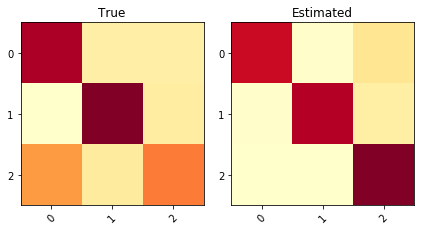

KL divergence: 0.6985	Pearson Correlation between diagonals: -0.8612


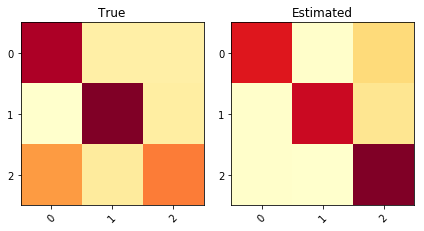

KL divergence: 0.7016	Pearson Correlation between diagonals: -0.8912
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.856329 |     0.856329 |     0.625945 |              0.124793 |       0.177546 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.616619 |               0.787002 |
+----+-------------------------+------------------------+
Test


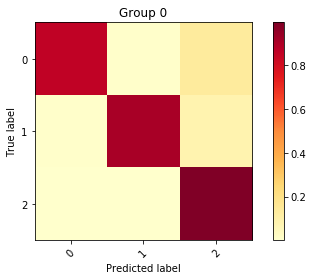

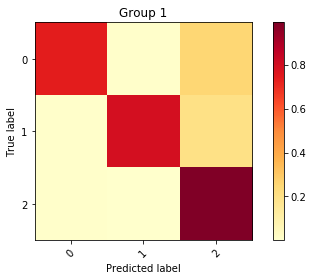

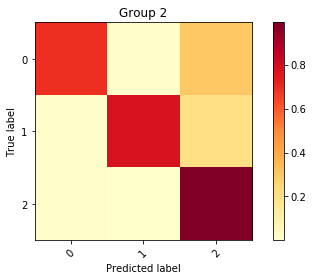

Inertia: 0.007237071549752727
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.266597 |   1332 |  0.271615 |    0.919772 | 0.0855103 |           0.958026 |   0.778999 |     0.778999 |
|  1 |        1 | 0.34713  |   1735 |  0.401839 |    0.840689 | 0.181562  |           0.912697 |   0.666667 |     0.666667 |
|  2 |        2 | 0.386273 |   1931 |  0.419588 |    0.821732 | 0.207717  |           0.900844 |   0.664225 |     0.664225 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   

In [42]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


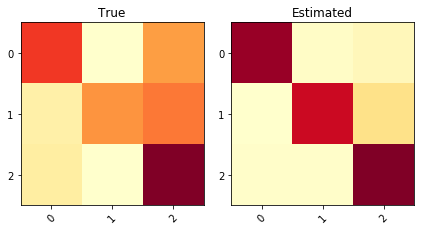

KL divergence: 0.4320	Pearson Correlation between diagonals: 0.9380


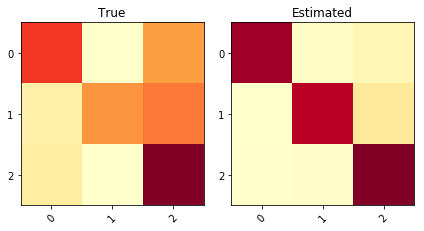

KL divergence: 0.4507	Pearson Correlation between diagonals: 0.9950


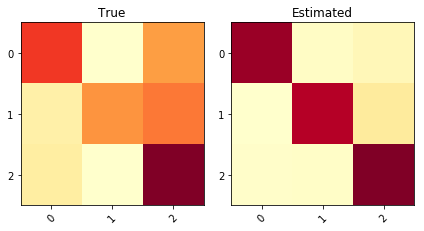

KL divergence: 0.4699	Pearson Correlation between diagonals: 0.9940


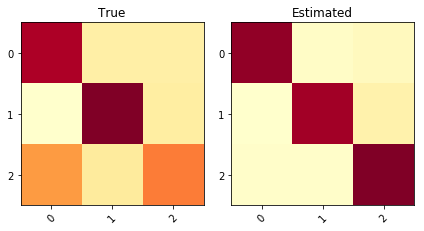

KL divergence: 0.5120	Pearson Correlation between diagonals: -0.9482


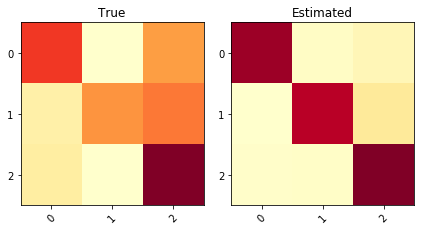

KL divergence: 0.4575	Pearson Correlation between diagonals: 0.9926


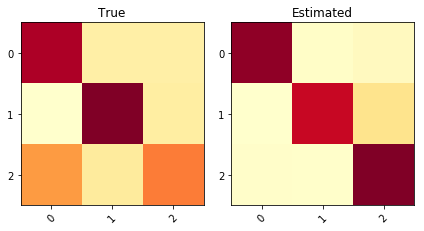

KL divergence: 0.5359	Pearson Correlation between diagonals: -0.7888


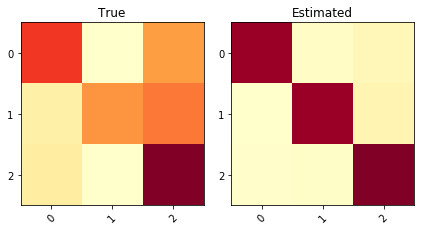

KL divergence: 0.5521	Pearson Correlation between diagonals: 0.9272


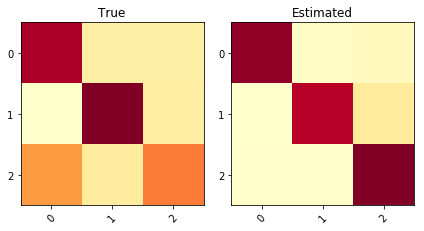

KL divergence: 0.5191	Pearson Correlation between diagonals: -0.8590


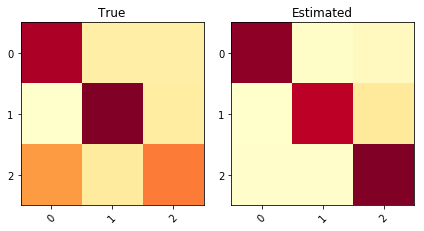

KL divergence: 0.5231	Pearson Correlation between diagonals: -0.8359


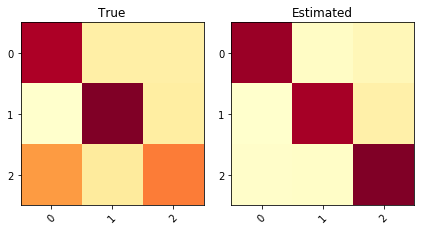

KL divergence: 0.5019	Pearson Correlation between diagonals: -0.9980


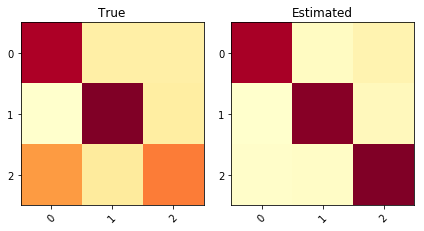

KL divergence: 0.5023	Pearson Correlation between diagonals: -0.5260


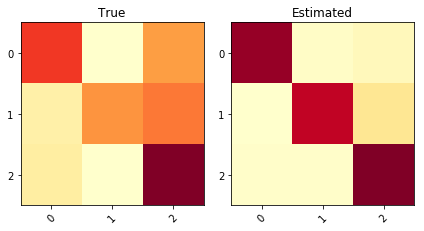

KL divergence: 0.4613	Pearson Correlation between diagonals: 0.9485


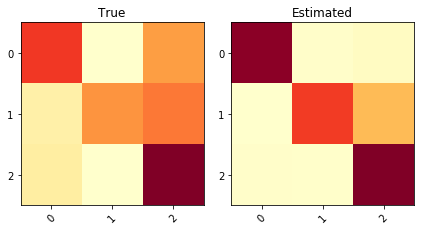

KL divergence: 0.4414	Pearson Correlation between diagonals: 0.8347


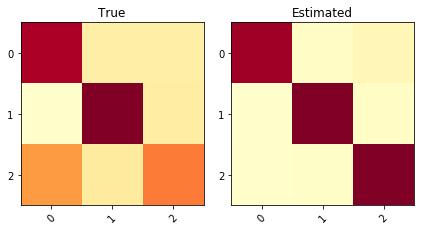

KL divergence: 0.5180	Pearson Correlation between diagonals: -0.2990


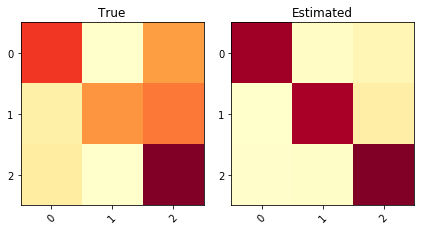

KL divergence: 0.4891	Pearson Correlation between diagonals: 0.9760
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.903541 |     0.903541 |     0.671521 |              0.474961 |       0.141676 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.678511 |               0.769933 |
+----+-------------------------+------------------------+
Test


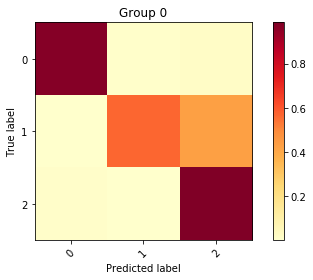

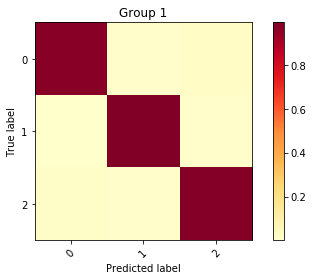

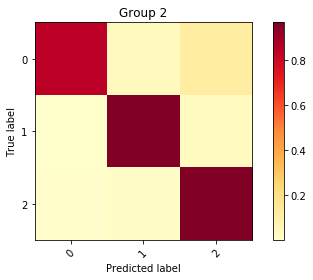

Inertia: 0.03994822083041072
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.366069 |   1830 |  0.303476 |    0.842639 | 0.202003  |           0.906787 |   0.650794 |     0.650794 |
|  1 |        1 | 0.342458 |   1712 |  0.100718 |    0.981561 | 0.0186554 |           0.990704 |   0.919414 |     0.919414 |
|  2 |        2 | 0.291473 |   1457 |  0.275599 |    0.926595 | 0.0782333 |           0.961603 |   0.919414 |     0.919414 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F

In [43]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 6) configuration: Manny annot v3 ($T$ = 10000, $T_{data}$ = 40 )

In [23]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8237688237688238


*** Soft-Majority (Train with softMV) ***
Train


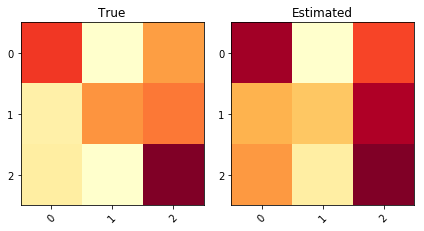

KL divergence: 0.1322	Pearson Correlation between diagonals: 0.8498


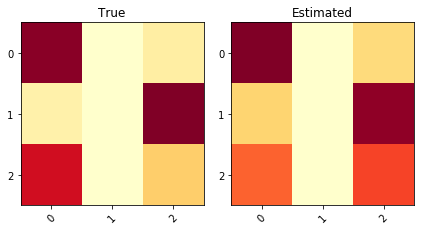

KL divergence: 0.0785	Pearson Correlation between diagonals: 0.9168


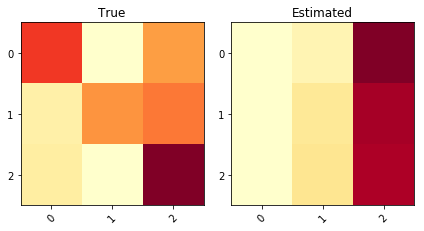

KL divergence: 4.0325	Pearson Correlation between diagonals: 0.8508


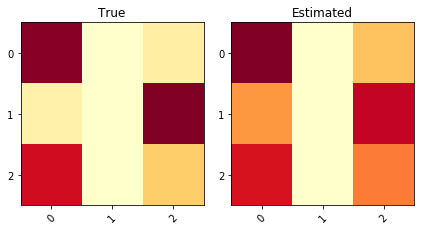

KL divergence: 0.1000	Pearson Correlation between diagonals: 0.9619


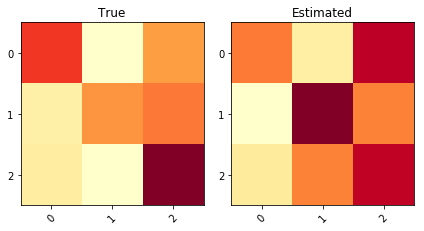

KL divergence: 0.2451	Pearson Correlation between diagonals: -0.1697


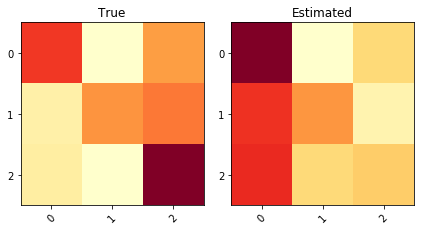

KL divergence: 0.5866	Pearson Correlation between diagonals: -0.3625


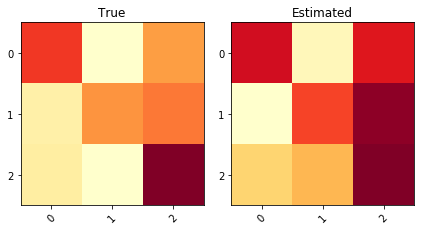

KL divergence: 0.1487	Pearson Correlation between diagonals: 0.9980


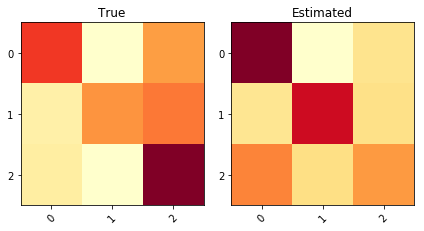

KL divergence: 0.3343	Pearson Correlation between diagonals: -0.7455


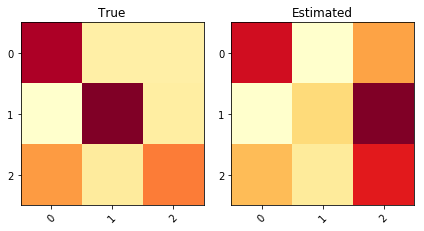

KL divergence: 0.4221	Pearson Correlation between diagonals: -0.5868


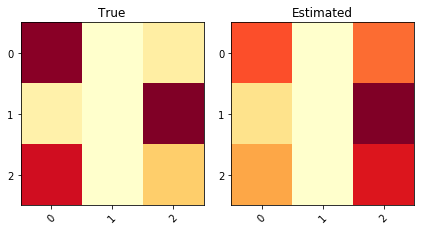

KL divergence: 0.2208	Pearson Correlation between diagonals: 0.5836


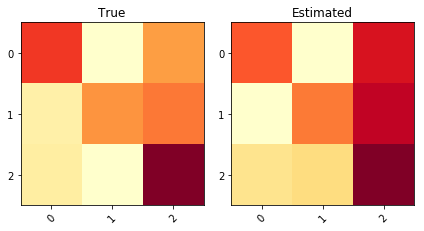

KL divergence: 0.1178	Pearson Correlation between diagonals: 0.9670


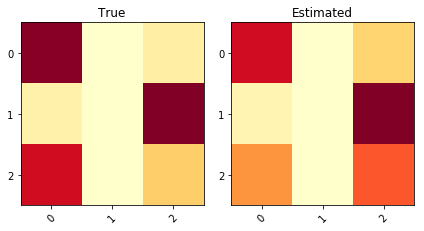

KL divergence: 0.0845	Pearson Correlation between diagonals: 0.8711


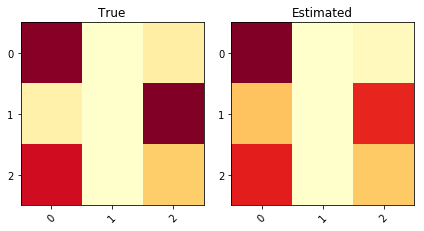

KL divergence: 0.0604	Pearson Correlation between diagonals: 0.9999


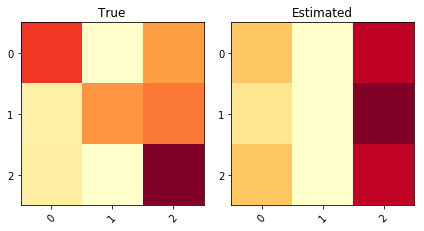

KL divergence: 2.1647	Pearson Correlation between diagonals: 0.9993


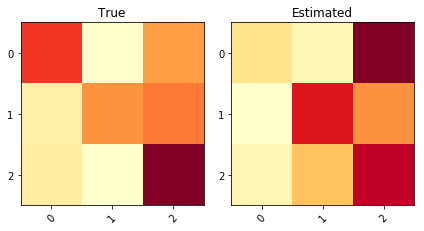

KL divergence: 0.3445	Pearson Correlation between diagonals: 0.2558
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.641433 |     0.641433 |     0.807789 |              0.647566 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.661783 |     0.661783 |
+----+--------+------------+--------------+


In [24]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


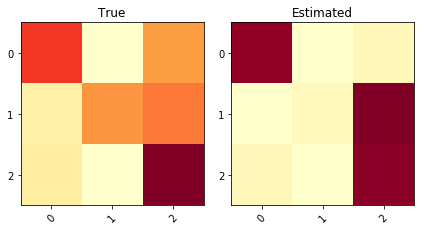

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


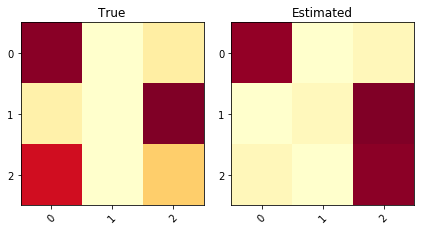

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7125


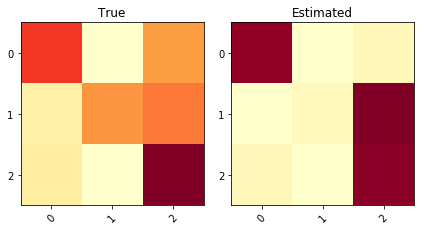

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


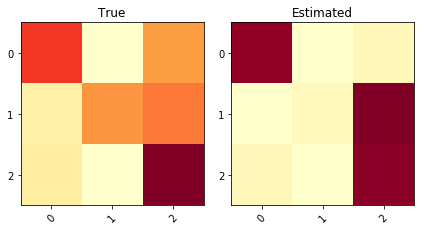

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


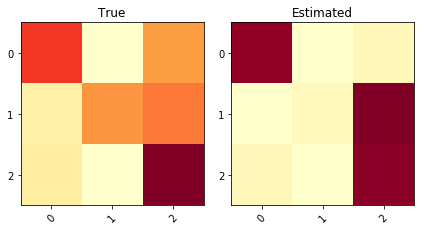

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


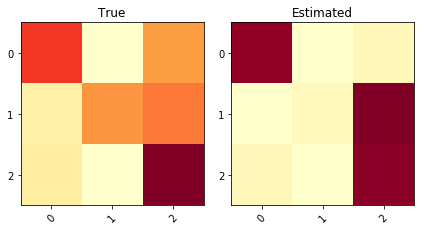

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


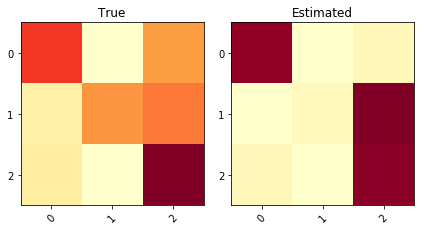

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


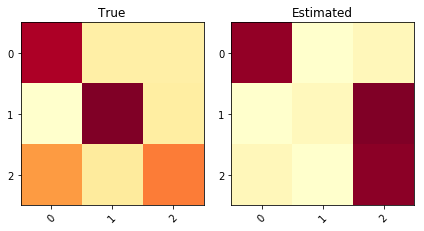

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6688


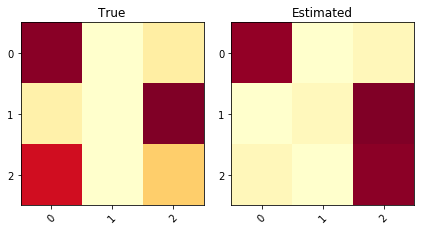

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7125


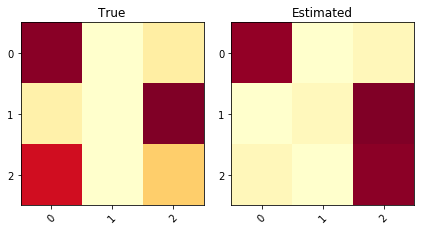

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7125


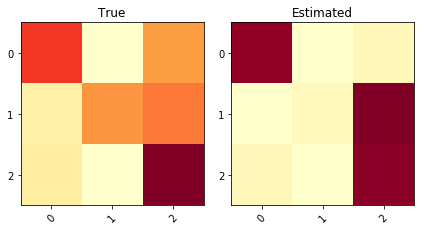

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


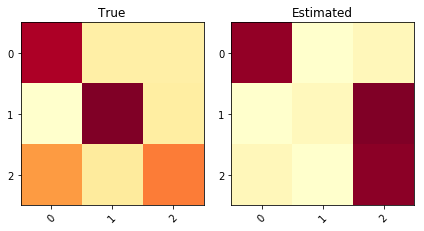

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6688


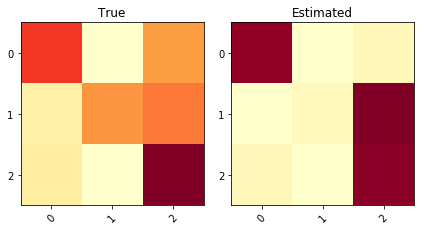

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


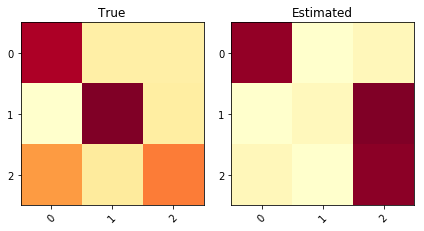

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6688


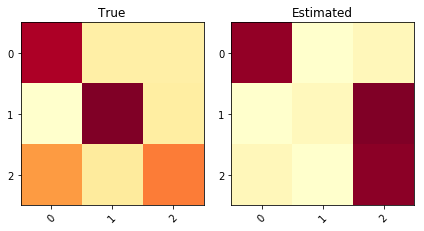

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6688
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.641433 |     0.641433 |     0.521171 |               0.41802 |
+----+--------+------------+--------------+--------------+-----------------------+


In [25]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


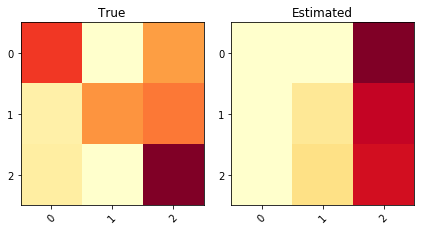

KL divergence: 4.0302	Pearson Correlation between diagonals: 0.8379


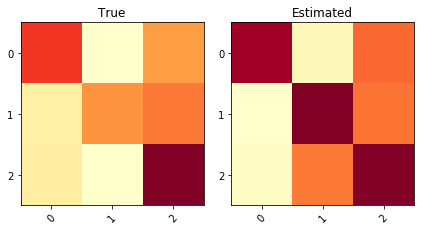

KL divergence: 0.2179	Pearson Correlation between diagonals: 0.0185


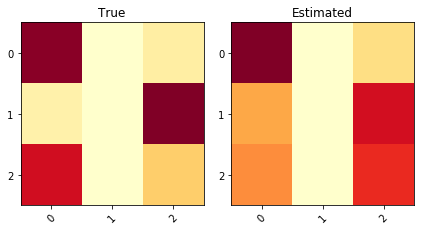

KL divergence: 0.1391	Pearson Correlation between diagonals: 0.8878


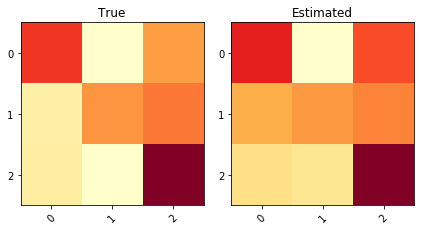

KL divergence: 0.0969	Pearson Correlation between diagonals: 0.9903


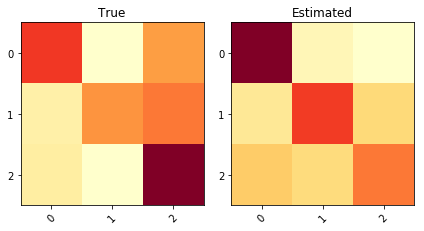

KL divergence: 0.5760	Pearson Correlation between diagonals: -0.3901


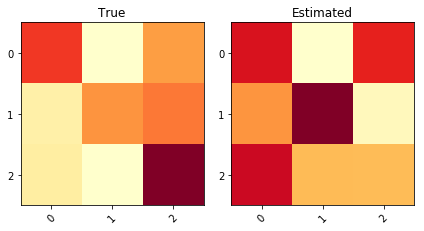

KL divergence: 0.6747	Pearson Correlation between diagonals: -0.9979


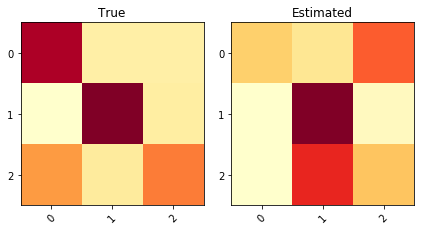

KL divergence: 0.9145	Pearson Correlation between diagonals: 0.6235


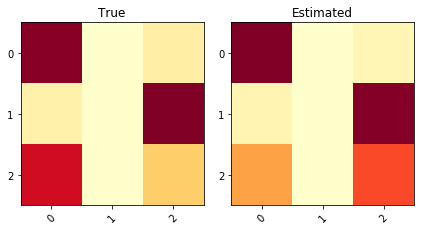

KL divergence: 0.0839	Pearson Correlation between diagonals: 0.9241


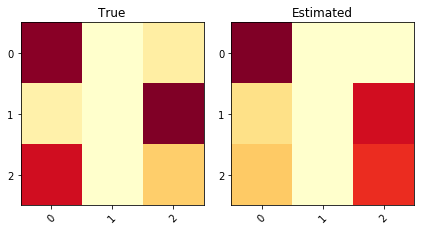

KL divergence: 0.2866	Pearson Correlation between diagonals: 0.8916


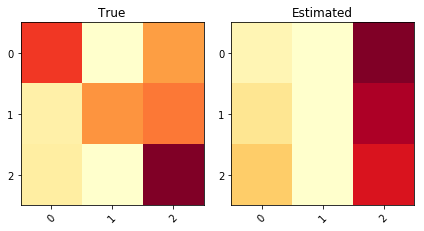

KL divergence: 2.4218	Pearson Correlation between diagonals: 0.9499


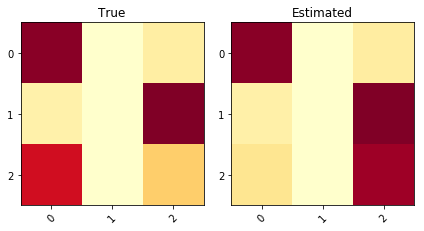

KL divergence: 0.2889	Pearson Correlation between diagonals: 0.7500


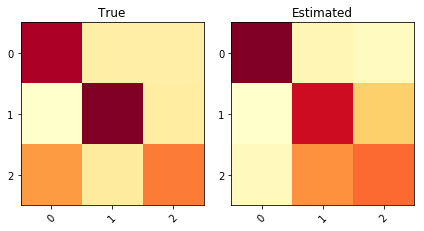

KL divergence: 0.2270	Pearson Correlation between diagonals: 0.8107


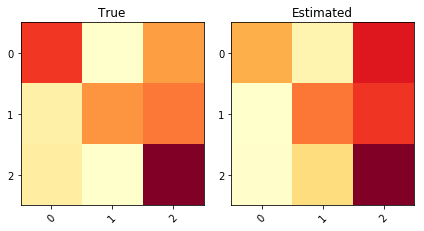

KL divergence: 0.2520	Pearson Correlation between diagonals: 0.7978


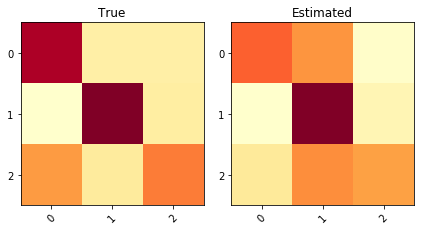

KL divergence: 0.2244	Pearson Correlation between diagonals: 0.8318


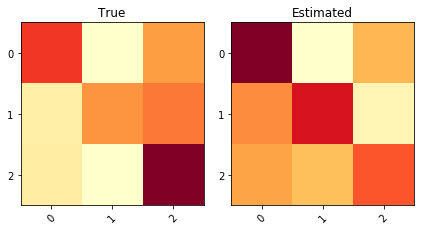

KL divergence: 0.4106	Pearson Correlation between diagonals: -0.5623
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.660155 |     0.660155 |     0.868676 |              0.650343 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.684982 |     0.684982 |
+----+--------+------------+--------------+


In [26]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


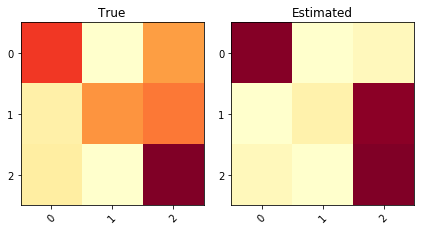

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


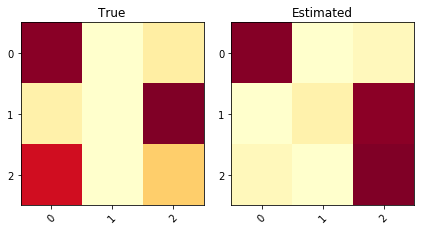

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7146


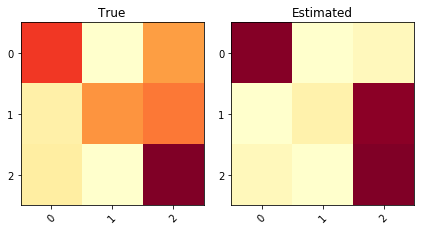

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


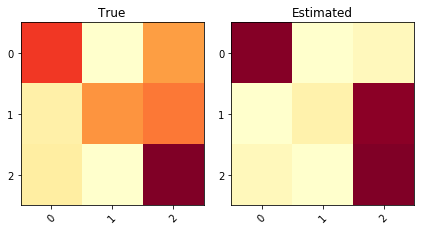

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


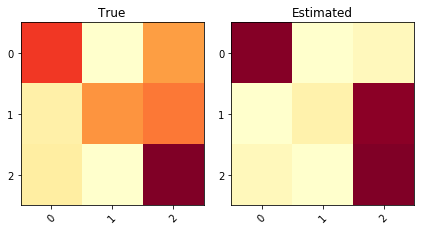

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


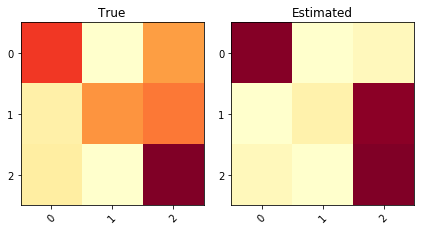

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


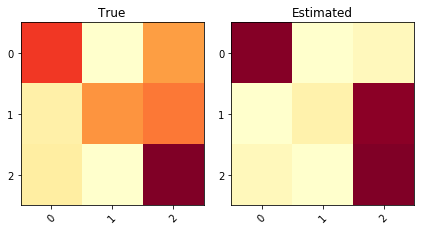

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


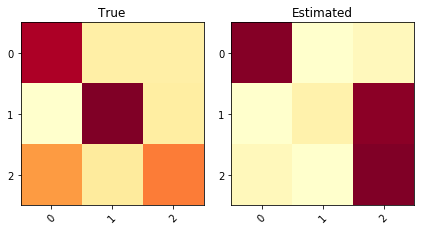

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6665


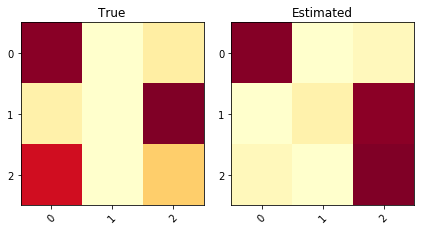

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7146


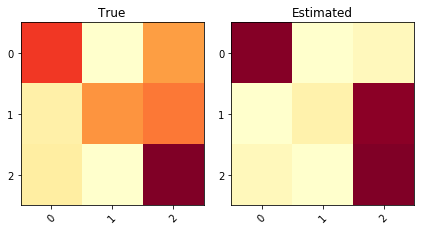

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


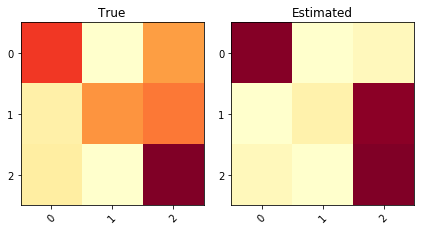

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


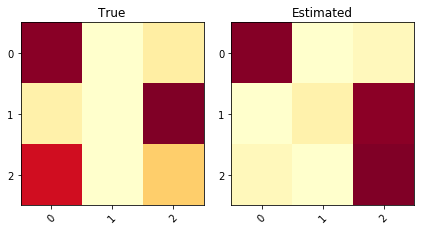

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7146


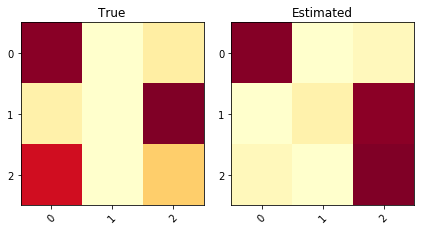

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7146


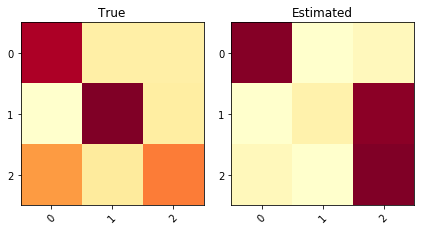

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6665


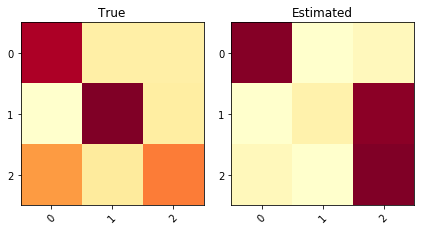

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6665
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.660155 |     0.660155 |     0.521171 |              0.417991 |
+----+--------+------------+--------------+--------------+-----------------------+


In [27]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


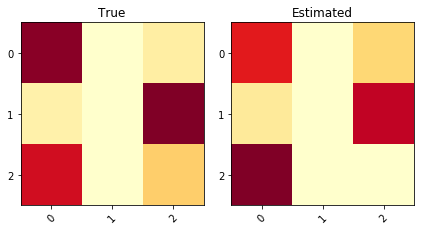

KL divergence: 1.2267	Pearson Correlation between diagonals: 0.9597


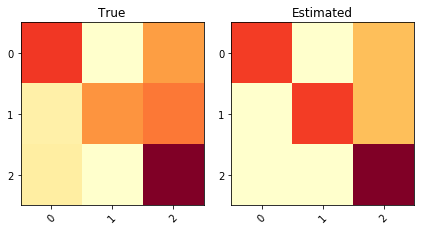

KL divergence: 0.8700	Pearson Correlation between diagonals: 0.9225


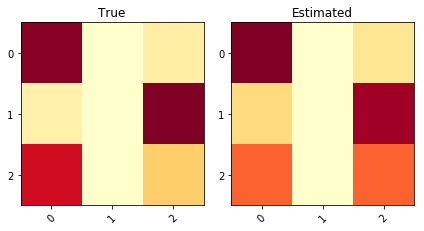

KL divergence: 0.0590	Pearson Correlation between diagonals: 0.9445


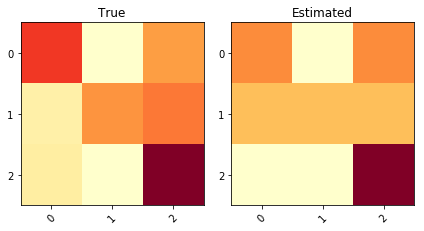

KL divergence: 0.5162	Pearson Correlation between diagonals: 0.9882


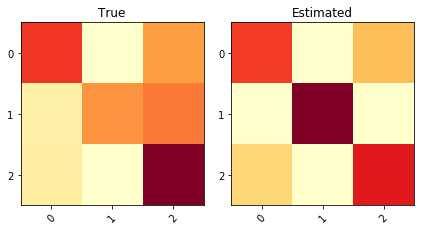

KL divergence: 2.8087	Pearson Correlation between diagonals: -0.6267


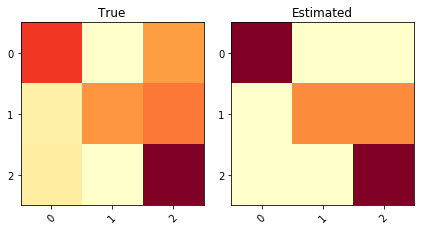

KL divergence: 2.7299	Pearson Correlation between diagonals: 0.7955


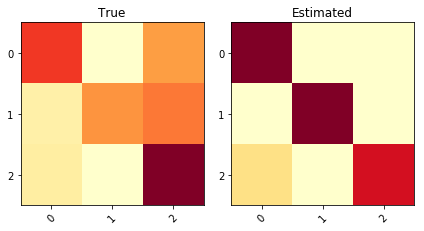

KL divergence: 4.6821	Pearson Correlation between diagonals: -0.9225


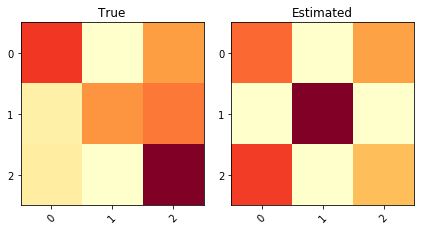

KL divergence: 3.0144	Pearson Correlation between diagonals: -0.9580


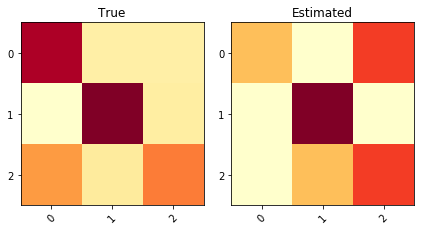

KL divergence: 3.0167	Pearson Correlation between diagonals: 0.1924


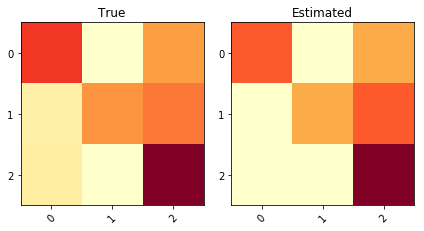

KL divergence: 0.8446	Pearson Correlation between diagonals: 0.9980


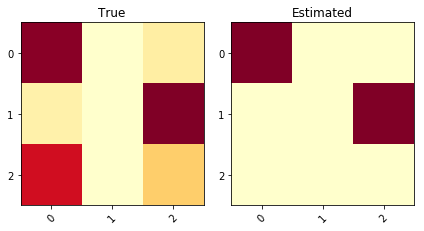

KL divergence: 0.9934	Pearson Correlation between diagonals: 0.9597


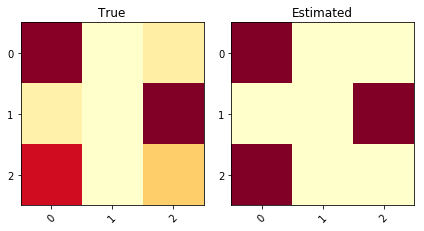

KL divergence: 2.0172	Pearson Correlation between diagonals: 0.9597


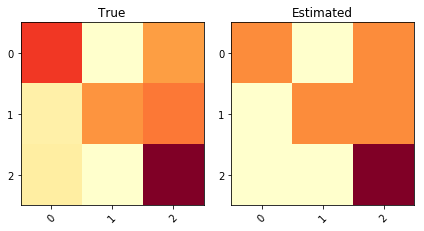

KL divergence: 0.8502	Pearson Correlation between diagonals: 0.9225


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


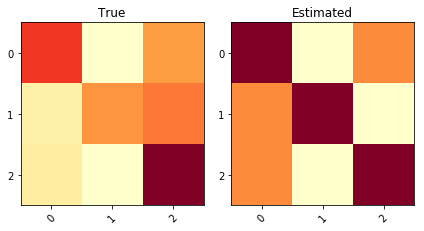

KL divergence: 2.4342	Pearson Correlation between diagonals: nan


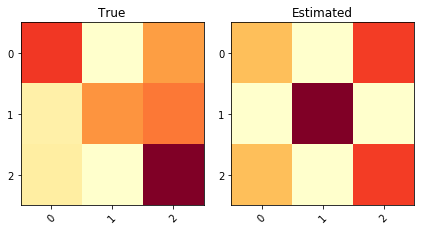

KL divergence: 2.8832	Pearson Correlation between diagonals: -0.3860
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.932031 |     0.932031 |      2.16908 |                   nan |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.946276 |     0.946276 |
+----+--------+------------+--------------+


In [28]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


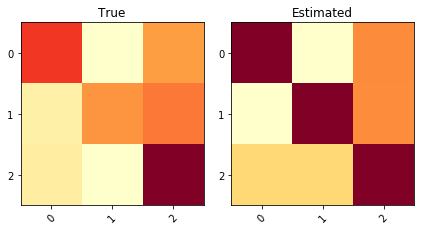

KL divergence: 0.2229	Pearson Correlation between diagonals: -0.1327


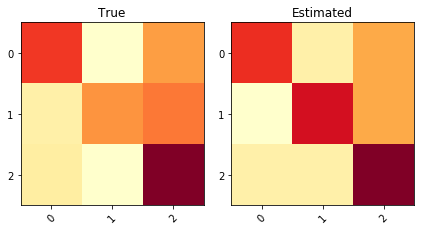

KL divergence: 0.1488	Pearson Correlation between diagonals: 0.7454


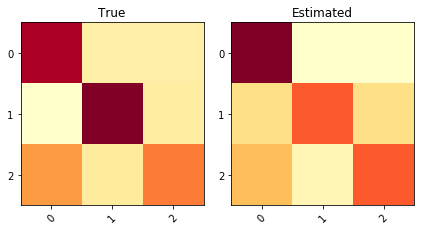

KL divergence: 0.1513	Pearson Correlation between diagonals: 0.3240


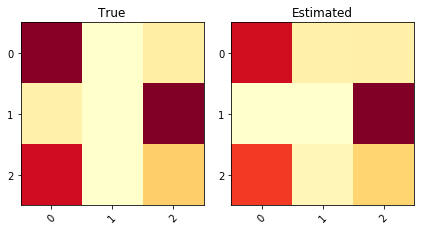

KL divergence: 0.1639	Pearson Correlation between diagonals: 0.9992


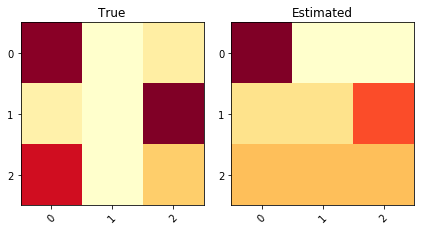

KL divergence: 0.3853	Pearson Correlation between diagonals: 0.9933


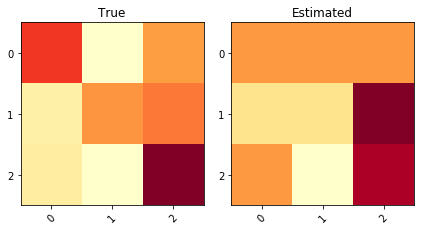

KL divergence: 0.2924	Pearson Correlation between diagonals: 0.9999


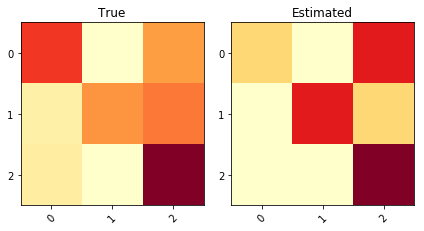

KL divergence: 0.1896	Pearson Correlation between diagonals: 0.4447


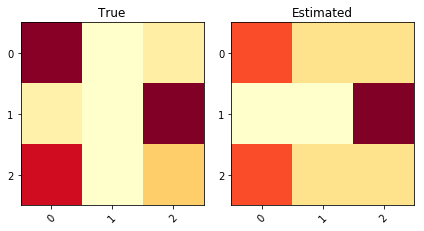

KL divergence: 0.3040	Pearson Correlation between diagonals: 0.9999


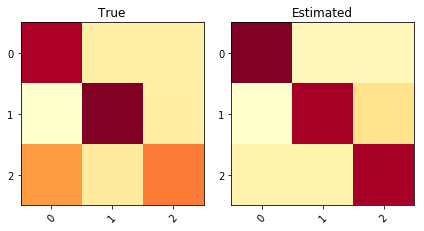

KL divergence: 0.1220	Pearson Correlation between diagonals: 0.3326


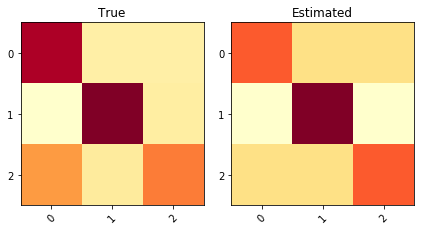

KL divergence: 0.1423	Pearson Correlation between diagonals: 0.6573


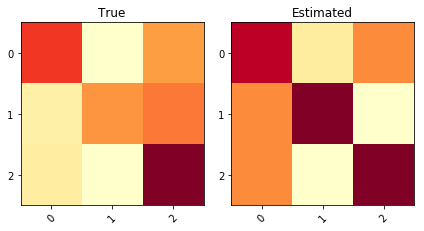

KL divergence: 0.3230	Pearson Correlation between diagonals: 0.1270


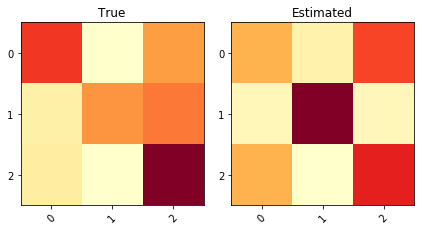

KL divergence: 0.3016	Pearson Correlation between diagonals: -0.2958


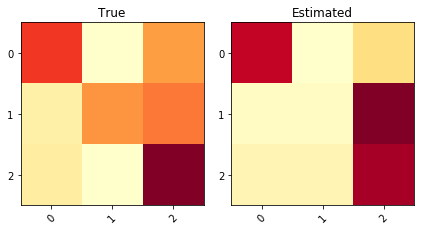

KL divergence: 0.2024	Pearson Correlation between diagonals: 0.8368


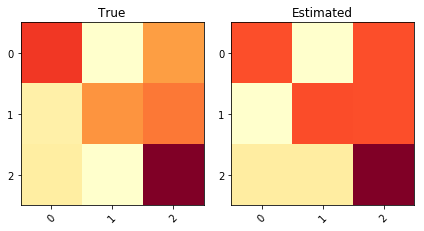

KL divergence: 0.1605	Pearson Correlation between diagonals: 0.9225


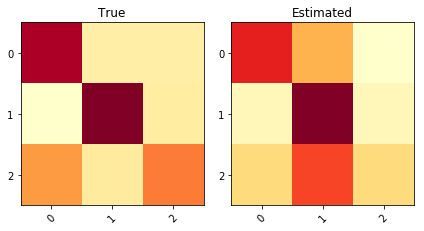

KL divergence: 0.2223	Pearson Correlation between diagonals: 0.9889


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.626374 |     0.626374 |     0.236337 |                   nan |       0.192491 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.688195 |               0.837098 |
+----+-------------------------+------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.650794 |     0.650794 |

In [29]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


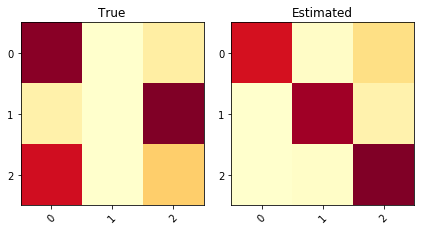

KL divergence: 2.0650	Pearson Correlation between diagonals: -0.8129


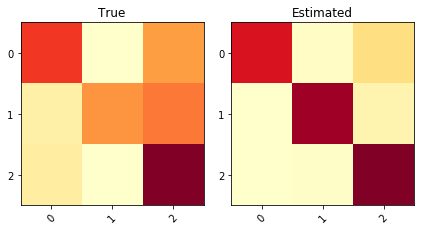

KL divergence: 0.4551	Pearson Correlation between diagonals: 0.4069


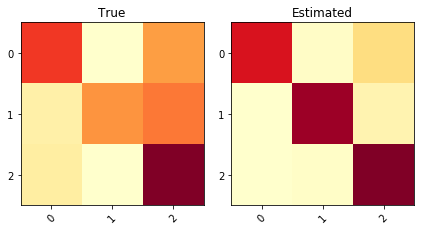

KL divergence: 0.4572	Pearson Correlation between diagonals: 0.3955


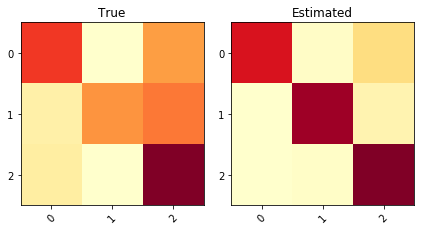

KL divergence: 0.4559	Pearson Correlation between diagonals: 0.4018


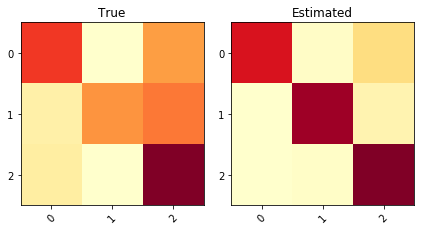

KL divergence: 0.4558	Pearson Correlation between diagonals: 0.4031


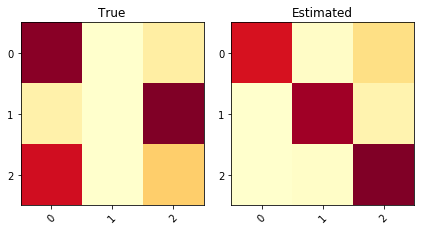

KL divergence: 2.0693	Pearson Correlation between diagonals: -0.8173


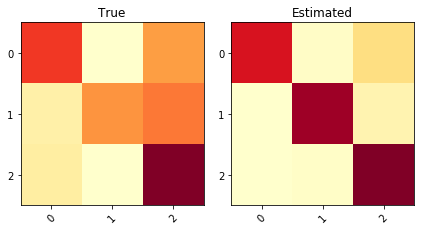

KL divergence: 0.4542	Pearson Correlation between diagonals: 0.4120


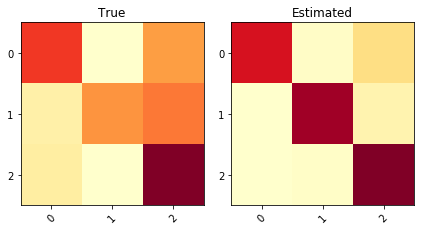

KL divergence: 0.4510	Pearson Correlation between diagonals: 0.4291


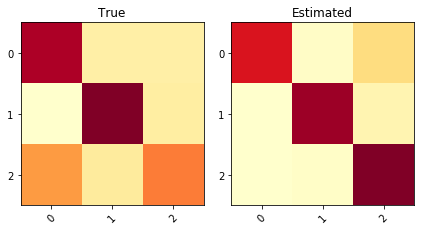

KL divergence: 0.6401	Pearson Correlation between diagonals: -0.5604


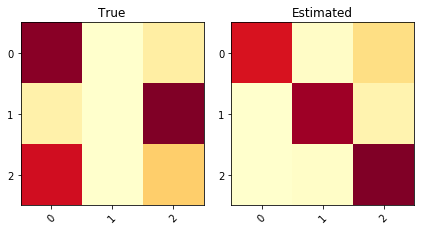

KL divergence: 2.0808	Pearson Correlation between diagonals: -0.8284


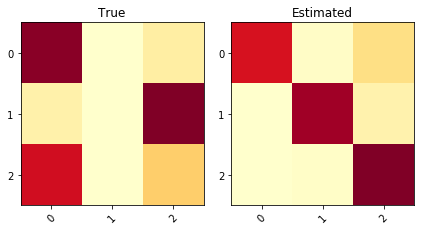

KL divergence: 2.0668	Pearson Correlation between diagonals: -0.8148


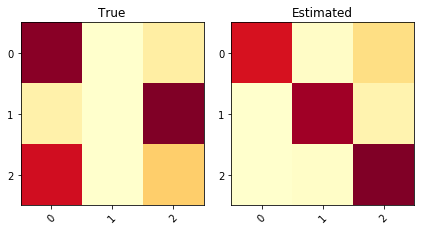

KL divergence: 2.0762	Pearson Correlation between diagonals: -0.8241


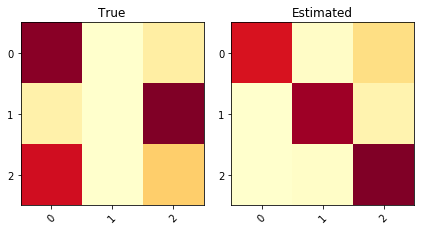

KL divergence: 2.0795	Pearson Correlation between diagonals: -0.8271


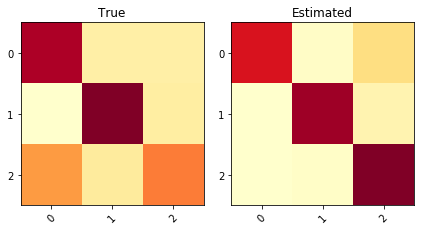

KL divergence: 0.6388	Pearson Correlation between diagonals: -0.5789


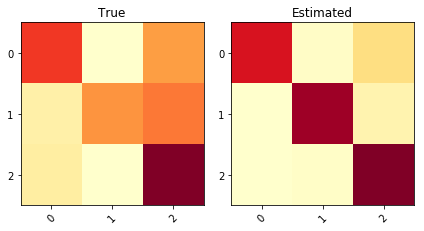

KL divergence: 0.4530	Pearson Correlation between diagonals: 0.4180
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.877493 |     0.877493 |     0.813015 |             -0.077447 |       0.214268 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.602366 |               0.804609 |
+----+-------------------------+------------------------+
Test


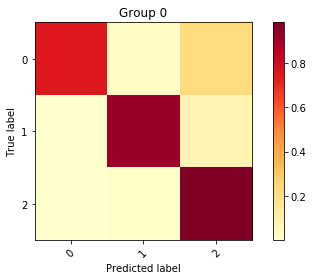

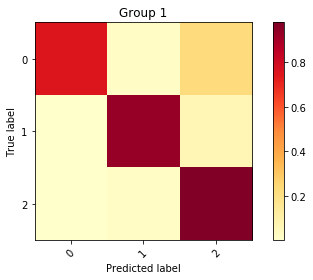

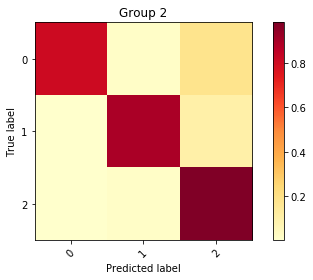

Inertia: 0.0008368157626440128
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.249351 |   2493 |  0.332172 |    0.886202 |  0.127219 |           0.938482 |   0.652015 |     0.652015 |
|  1 |        1 | 0.411    |   4109 |  0.331039 |    0.888618 |  0.124286 |           0.939867 |   0.664225 |     0.664225 |
|  2 |        2 | 0.339648 |   3395 |  0.323196 |    0.89638  |  0.112622 |           0.945049 |   0.655678 |     0.655678 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |  

In [30]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


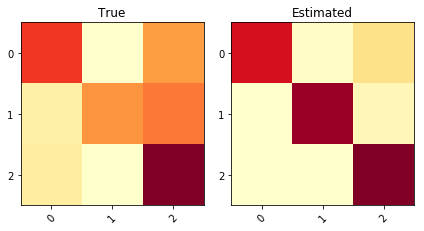

KL divergence: 0.4908	Pearson Correlation between diagonals: 0.3845


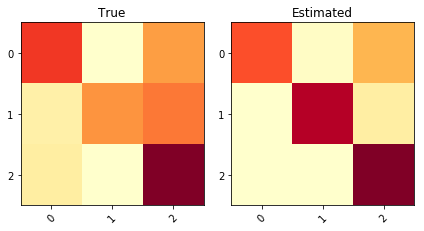

KL divergence: 0.3370	Pearson Correlation between diagonals: 0.4049


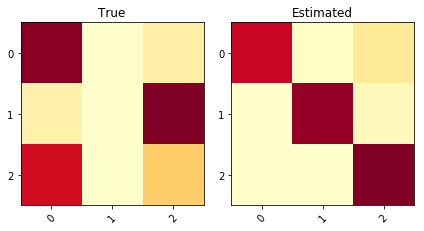

KL divergence: 2.3273	Pearson Correlation between diagonals: -0.8470


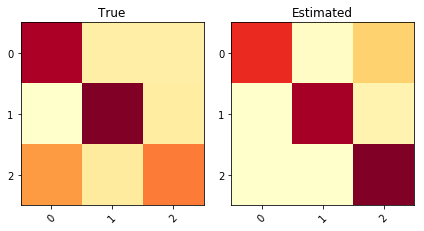

KL divergence: 0.7295	Pearson Correlation between diagonals: -0.5693


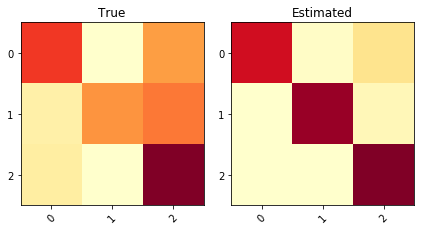

KL divergence: 0.5105	Pearson Correlation between diagonals: 0.3857


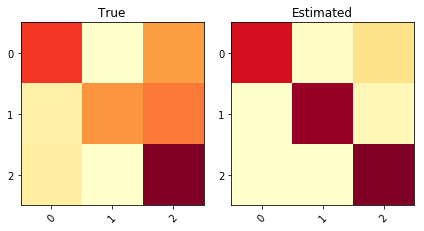

KL divergence: 0.4967	Pearson Correlation between diagonals: 0.3821


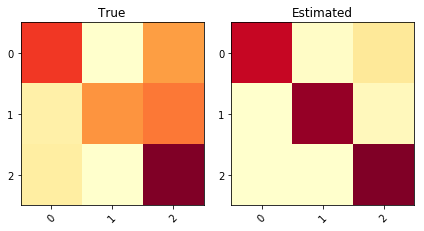

KL divergence: 0.5572	Pearson Correlation between diagonals: 0.3918


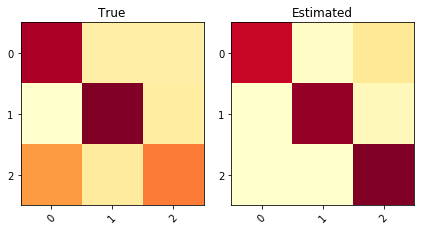

KL divergence: 0.7722	Pearson Correlation between diagonals: -0.5684


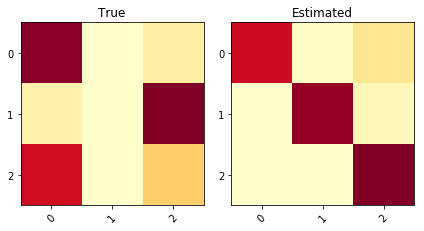

KL divergence: 2.2972	Pearson Correlation between diagonals: -0.8493


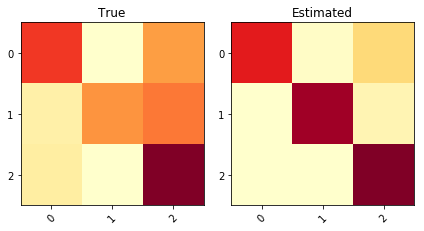

KL divergence: 0.4379	Pearson Correlation between diagonals: 0.3874


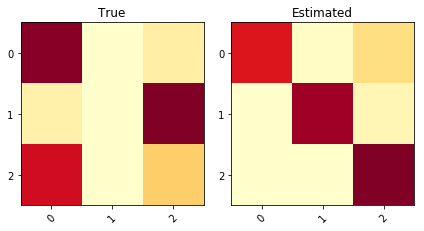

KL divergence: 2.1966	Pearson Correlation between diagonals: -0.8498


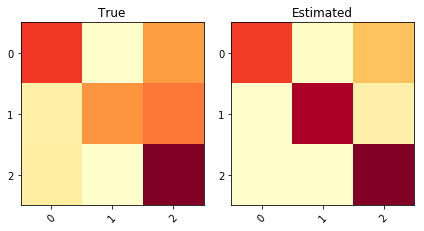

KL divergence: 0.3691	Pearson Correlation between diagonals: 0.3956


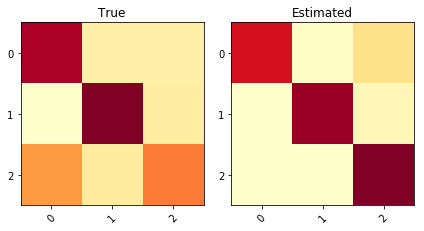

KL divergence: 0.7551	Pearson Correlation between diagonals: -0.5612


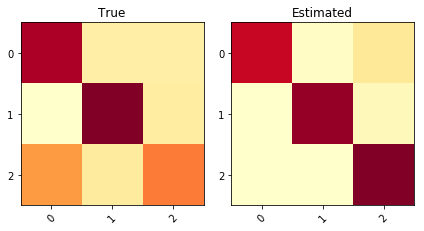

KL divergence: 0.7695	Pearson Correlation between diagonals: -0.5776


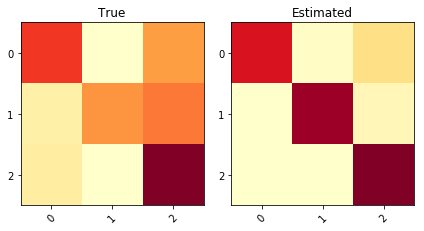

KL divergence: 0.4803	Pearson Correlation between diagonals: 0.3844
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.802198 |     0.802198 |     0.863901 |            -0.0889027 |       0.188671 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.608835 |               0.777425 |
+----+-------------------------+------------------------+
Test


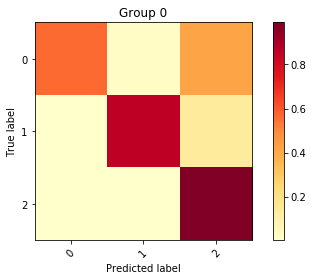

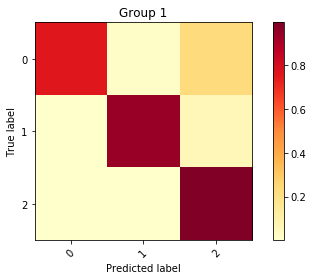

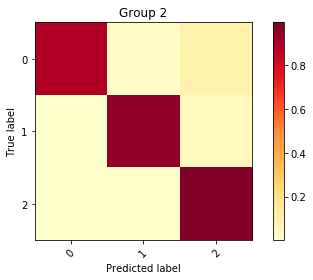

Inertia: 0.015578579700862369
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.235589 |   2355 |  0.416717 |    0.805234 | 0.243923  |           0.886548 |   0.594628 |     0.594628 |
|  1 |        1 | 0.415074 |   4149 |  0.291473 |    0.897584 | 0.114904  |           0.944495 |   0.687424 |     0.687424 |
|  2 |        2 | 0.349337 |   3492 |  0.199875 |    0.948779 | 0.0536247 |           0.973539 |   0.736264 |     0.736264 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   

In [31]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


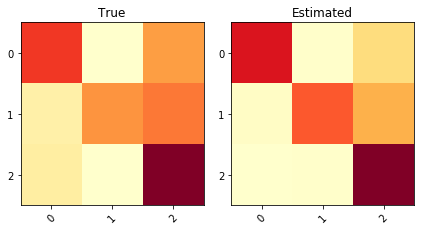

KL divergence: 0.1598	Pearson Correlation between diagonals: 0.9986


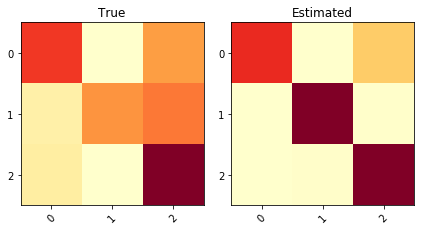

KL divergence: 0.7123	Pearson Correlation between diagonals: 0.1167


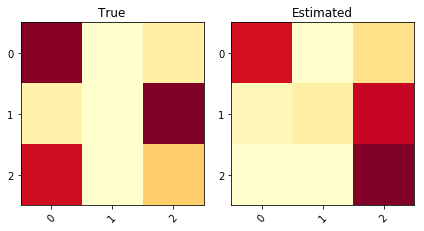

KL divergence: 1.3250	Pearson Correlation between diagonals: 0.5588


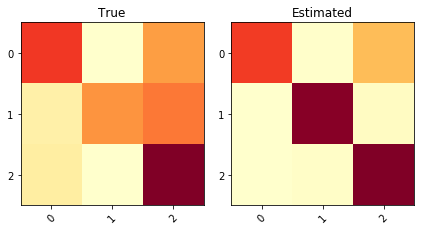

KL divergence: 0.4978	Pearson Correlation between diagonals: 0.1744


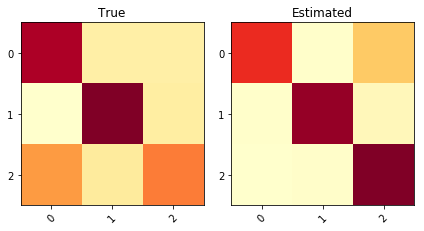

KL divergence: 0.7097	Pearson Correlation between diagonals: -0.4602


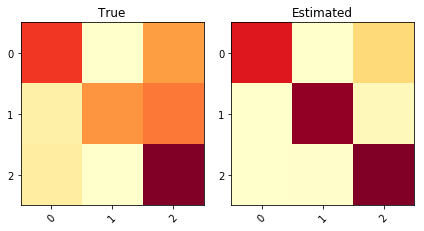

KL divergence: 0.4719	Pearson Correlation between diagonals: 0.2894


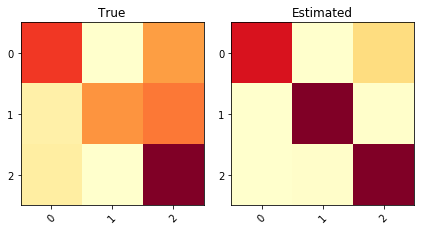

KL divergence: 0.8233	Pearson Correlation between diagonals: 0.1173


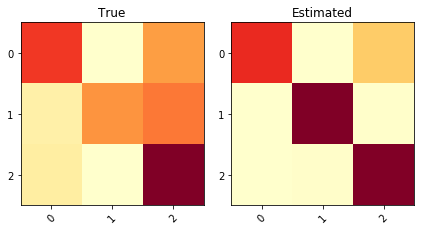

KL divergence: 0.7294	Pearson Correlation between diagonals: 0.1135


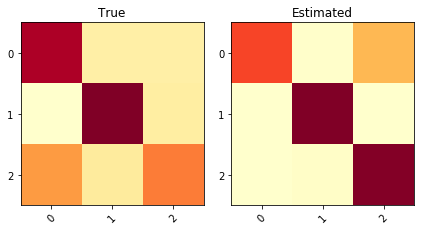

KL divergence: 0.7312	Pearson Correlation between diagonals: -0.3002


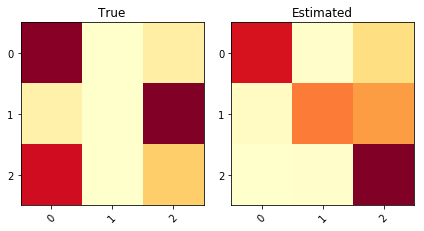

KL divergence: 1.5816	Pearson Correlation between diagonals: 0.3323


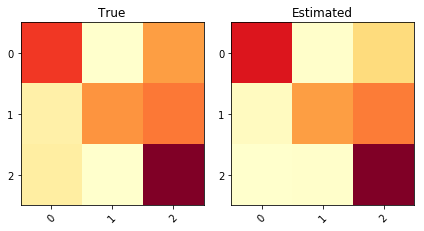

KL divergence: 0.1322	Pearson Correlation between diagonals: 0.9729


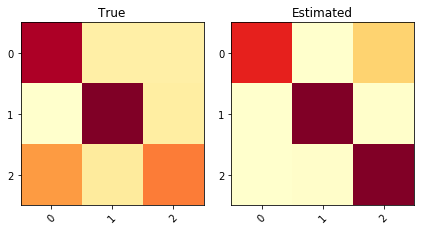

KL divergence: 0.8009	Pearson Correlation between diagonals: -0.3073


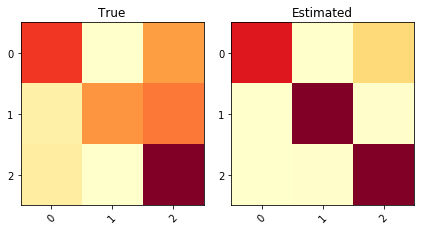

KL divergence: 0.8090	Pearson Correlation between diagonals: 0.1131


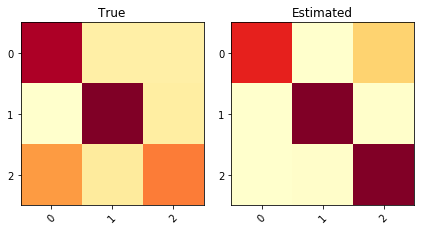

KL divergence: 0.7996	Pearson Correlation between diagonals: -0.3078


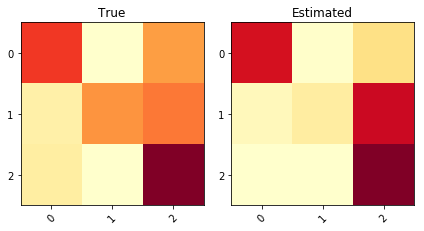

KL divergence: 0.2337	Pearson Correlation between diagonals: 0.9103
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.901913 |     0.901913 |     0.712705 |              0.265968 |       0.140693 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.681159 |               0.721124 |
+----+-------------------------+------------------------+
Test


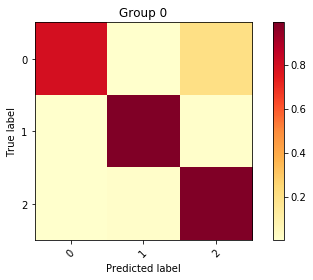

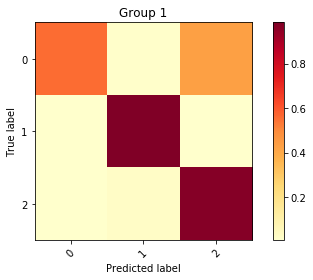

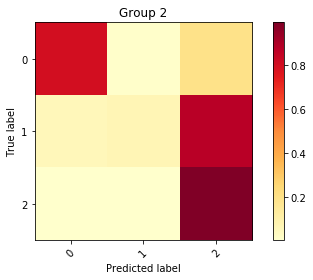

Inertia: 0.12799112731590867
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.504188 |   5040 |  0.216618 |    0.92399  | 0.0845576 |           0.959035 |   0.921856 |     0.921856 |
|  1 |        1 | 0.230281 |   2302 |  0.323808 |    0.838168 | 0.208905  |           0.903808 |   0.884005 |     0.884005 |
|  2 |        2 | 0.265531 |   2654 |  0.343347 |    0.620112 | 0.973083  |           0.690169 |   0.652015 |     0.652015 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F

In [32]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 6) configuration: Manny annot v1 bad MV ($T$ = 2000, $T_{max}$ = 20 )

In [37]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6295811518324608
